# Custom GAN Implementation for CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

In [2]:
# Define transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download CIFAR-10 Dataset
cifar10_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter out only cats and dogs
class_indices = [3, 5]  # 3: Cats, 5: Dogs
indices = [i for i, (_, label) in enumerate(cifar10_data) if label in class_indices]
cifar10_subset = Subset(cifar10_data, indices)

# Create DataLoader
dataloader = DataLoader(cifar10_subset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 48181057.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Feature extraction part for both images
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # Input (batch_size, 3, 32, 32) -> Output (batch_size, 64, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output (batch_size, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  # Output (batch_size, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),  # Output (batch_size, 512, 2, 2)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        # Fully connected layer to compute similarity score
        self.fc = nn.Sequential(
            nn.Linear(512 * 2 * 2 * 2, 1),  # Adjusted input size for concatenated features
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        # Feature extraction from both images
        f1 = self.conv(img1)  # Output shape: (batch_size, 512, 2, 2)
        f2 = self.conv(img2)  # Output shape: (batch_size, 512, 2, 2)

        # Flatten the feature maps
        f1 = f1.view(f1.size(0), -1)  # Flatten to (batch_size, 512 * 2 * 2 = 2048)
        f2 = f2.view(f2.size(0), -1)  # Flatten to (batch_size, 2048)

        # Concatenate the features along the channel axis
        combined = torch.cat([f1, f2], dim=1)  # Shape (batch_size, 2048 * 2 = 4096)

        # Pass through the fully connected layers to get similarity score
        return self.fc(combined)


In [12]:
def generator_loss(discriminator_output):
    return F.binary_cross_entropy(discriminator_output, torch.ones_like(discriminator_output))

def discriminator_loss(real_output, fake_output):
    real_loss = F.binary_cross_entropy(real_output, torch.ones_like(real_output))
    fake_loss = F.binary_cross_entropy(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

# Initialize generator, discriminator, and optimizers
latent_dim = 100
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0009, betas=(0.5, 0.999))

Epoch [0/300], Step [0/157], d_loss: 0.7174503803253174, g_loss: 20.85291290283203
Epoch [0/300], Step [100/157], d_loss: 0.0021750014275312424, g_loss: 50.404014587402344


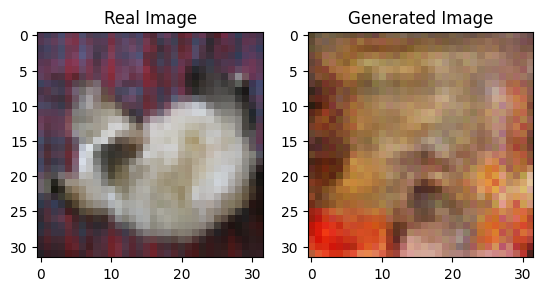

Epoch [1/300], Step [0/157], d_loss: 0.0010673473589122295, g_loss: 48.3330192565918
Epoch [1/300], Step [100/157], d_loss: 0.0004552777681965381, g_loss: 46.2534065246582


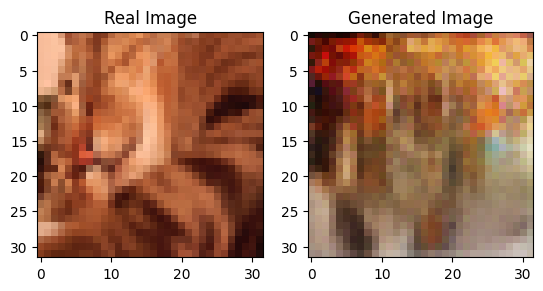

Epoch [2/300], Step [0/157], d_loss: 0.00031282700365409255, g_loss: 48.01123809814453
Epoch [2/300], Step [100/157], d_loss: 0.0005300085176713765, g_loss: 40.31462860107422


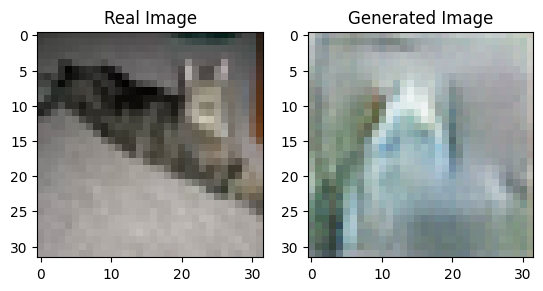

Epoch [3/300], Step [0/157], d_loss: 3.863184928894043, g_loss: 56.678524017333984
Epoch [3/300], Step [100/157], d_loss: 0.2655026912689209, g_loss: 6.513028144836426


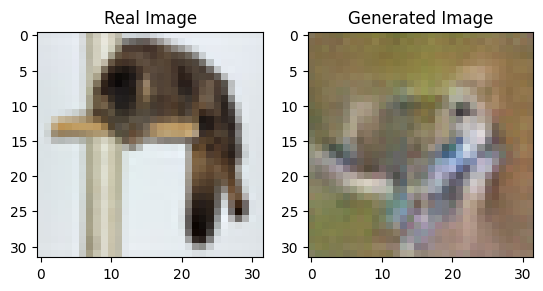

Epoch [4/300], Step [0/157], d_loss: 0.14062300324440002, g_loss: 9.133960723876953
Epoch [4/300], Step [100/157], d_loss: 0.033573586493730545, g_loss: 10.174988746643066


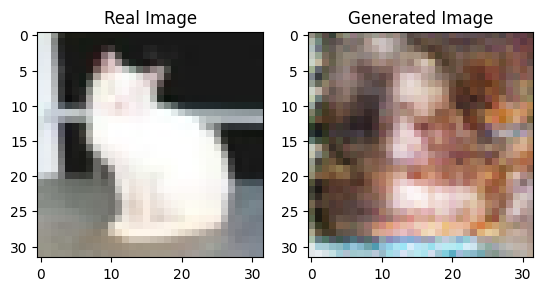

Epoch [5/300], Step [0/157], d_loss: 0.047953538596630096, g_loss: 11.730588912963867
Epoch [5/300], Step [100/157], d_loss: 0.06693204492330551, g_loss: 20.86275863647461


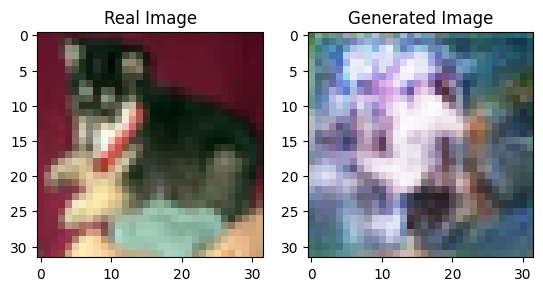

Epoch [6/300], Step [0/157], d_loss: 0.19051901996135712, g_loss: 18.424015045166016
Epoch [6/300], Step [100/157], d_loss: 0.1902407854795456, g_loss: 11.551233291625977


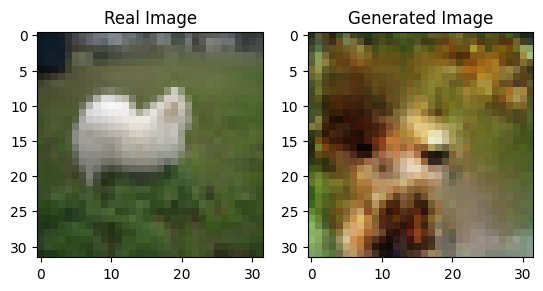

Epoch [7/300], Step [0/157], d_loss: 0.16314373910427094, g_loss: 22.501258850097656
Epoch [7/300], Step [100/157], d_loss: 0.29314252734184265, g_loss: 14.26888656616211


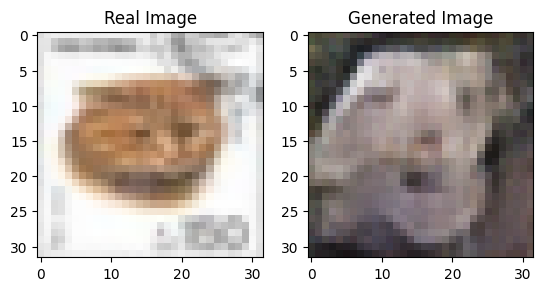

Epoch [8/300], Step [0/157], d_loss: 0.07847505807876587, g_loss: 8.92349624633789
Epoch [8/300], Step [100/157], d_loss: 0.06284432113170624, g_loss: 10.142350196838379


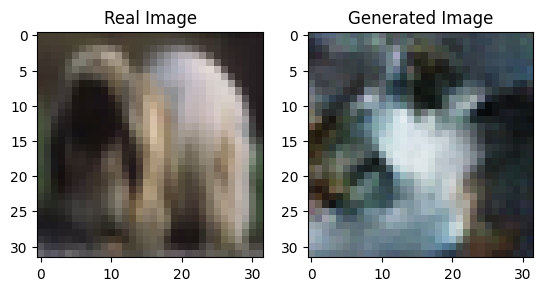

Epoch [9/300], Step [0/157], d_loss: 0.03422641381621361, g_loss: 15.008746147155762
Epoch [9/300], Step [100/157], d_loss: 0.0630153939127922, g_loss: 10.695672035217285


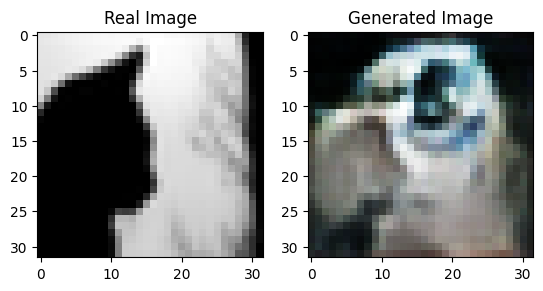

Epoch [10/300], Step [0/157], d_loss: 0.17754267156124115, g_loss: 11.24939250946045
Epoch [10/300], Step [100/157], d_loss: 0.05876985564827919, g_loss: 8.802436828613281


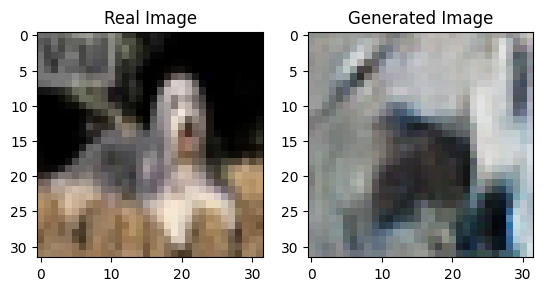

Epoch [11/300], Step [0/157], d_loss: 0.15327362716197968, g_loss: 14.775634765625
Epoch [11/300], Step [100/157], d_loss: 0.1443290412425995, g_loss: 10.337714195251465


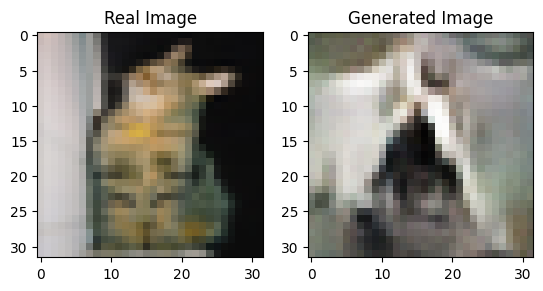

Epoch [12/300], Step [0/157], d_loss: 0.03189541772007942, g_loss: 14.2625732421875
Epoch [12/300], Step [100/157], d_loss: 0.017213620245456696, g_loss: 14.239471435546875


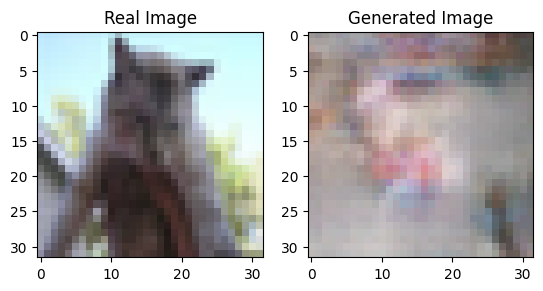

Epoch [13/300], Step [0/157], d_loss: 0.03394317999482155, g_loss: 15.653573036193848
Epoch [13/300], Step [100/157], d_loss: 0.04947669431567192, g_loss: 23.45322036743164


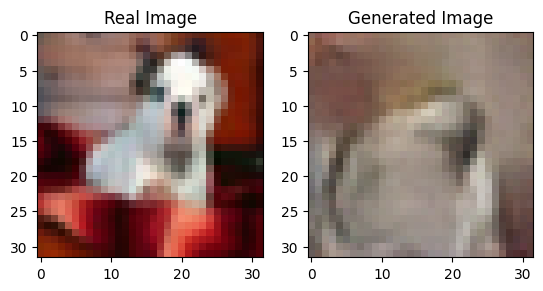

Epoch [14/300], Step [0/157], d_loss: 0.26322826743125916, g_loss: 13.13831901550293
Epoch [14/300], Step [100/157], d_loss: 0.047867514193058014, g_loss: 7.963829517364502


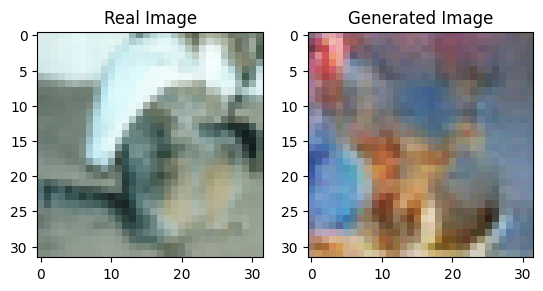

Epoch [15/300], Step [0/157], d_loss: 0.618072509765625, g_loss: 14.810070037841797
Epoch [15/300], Step [100/157], d_loss: 0.04376251623034477, g_loss: 11.894131660461426


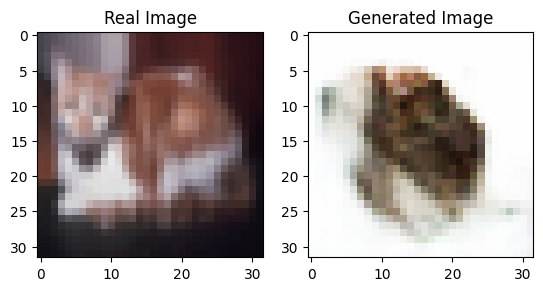

Epoch [16/300], Step [0/157], d_loss: 0.1682519018650055, g_loss: 25.854209899902344
Epoch [16/300], Step [100/157], d_loss: 0.07461356371641159, g_loss: 8.919044494628906


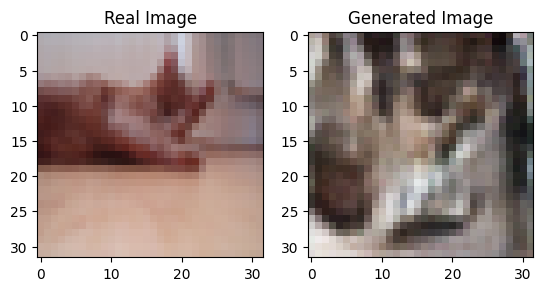

Epoch [17/300], Step [0/157], d_loss: 0.0145396264269948, g_loss: 14.501625061035156
Epoch [17/300], Step [100/157], d_loss: 0.14981621503829956, g_loss: 10.946295738220215


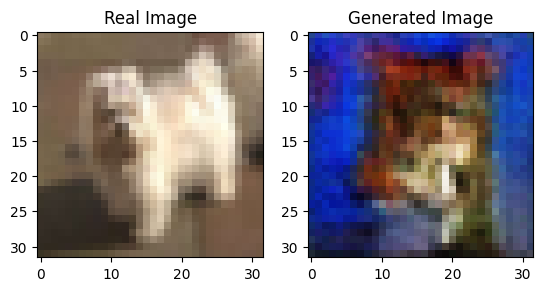

Epoch [18/300], Step [0/157], d_loss: 0.026330098509788513, g_loss: 13.838569641113281
Epoch [18/300], Step [100/157], d_loss: 0.7051306366920471, g_loss: 28.386672973632812


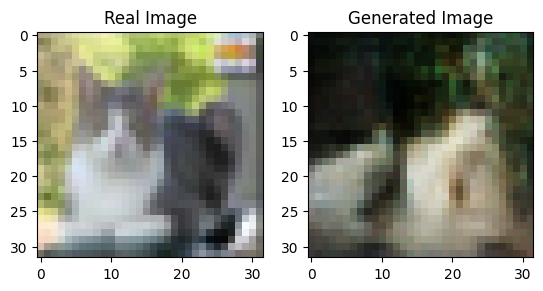

Epoch [19/300], Step [0/157], d_loss: 0.18381789326667786, g_loss: 12.209431648254395
Epoch [19/300], Step [100/157], d_loss: 0.012189595028758049, g_loss: 18.62114715576172


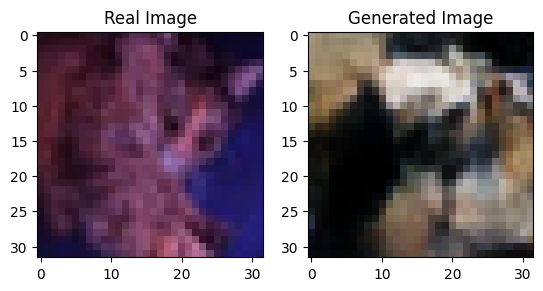

Epoch [20/300], Step [0/157], d_loss: 0.049758680164813995, g_loss: 22.773235321044922
Epoch [20/300], Step [100/157], d_loss: 0.04426617920398712, g_loss: 15.470663070678711


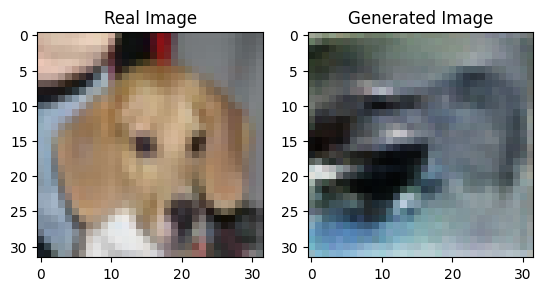

Epoch [21/300], Step [0/157], d_loss: 0.5538004636764526, g_loss: 18.04581642150879
Epoch [21/300], Step [100/157], d_loss: 0.1620020866394043, g_loss: 13.354982376098633


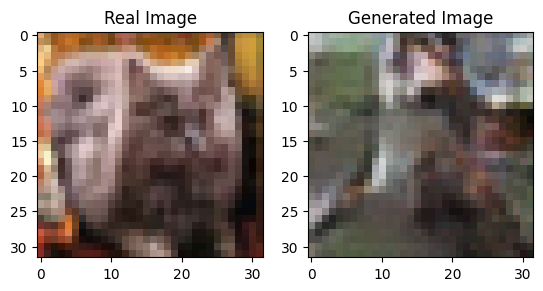

Epoch [22/300], Step [0/157], d_loss: 0.0627201572060585, g_loss: 12.249855041503906
Epoch [22/300], Step [100/157], d_loss: 0.00968169141560793, g_loss: 17.023258209228516


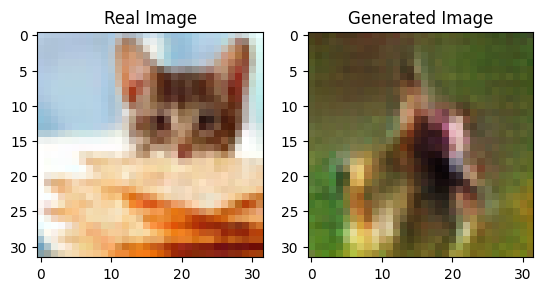

Epoch [23/300], Step [0/157], d_loss: 0.006967937108129263, g_loss: 15.587215423583984
Epoch [23/300], Step [100/157], d_loss: 0.011765901930630207, g_loss: 18.283096313476562


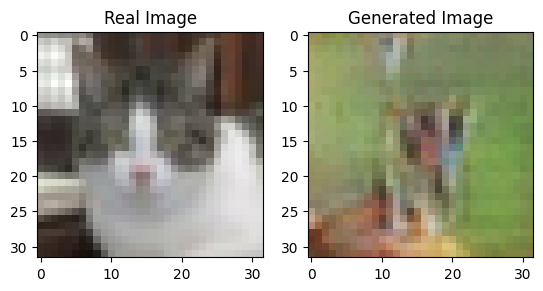

Epoch [24/300], Step [0/157], d_loss: 0.009611652232706547, g_loss: 13.333595275878906
Epoch [24/300], Step [100/157], d_loss: 0.032604046165943146, g_loss: 13.572189331054688


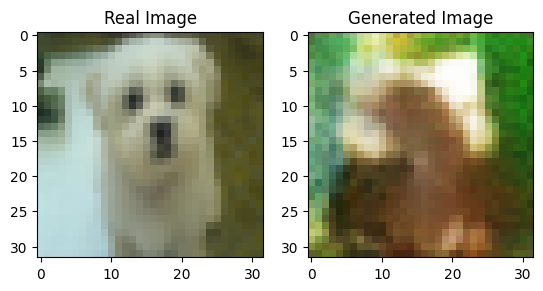

Epoch [25/300], Step [0/157], d_loss: 0.023102764040231705, g_loss: 10.063283920288086
Epoch [25/300], Step [100/157], d_loss: 0.18450172245502472, g_loss: 14.14932632446289


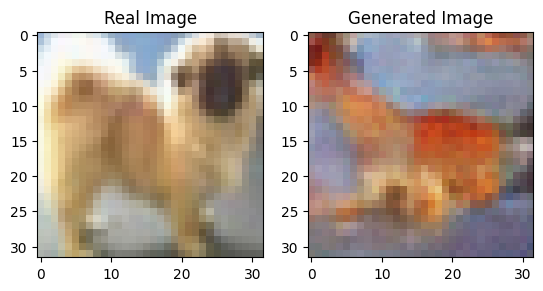

Epoch [26/300], Step [0/157], d_loss: 0.21290209889411926, g_loss: 14.833580017089844
Epoch [26/300], Step [100/157], d_loss: 0.12268026918172836, g_loss: 11.669719696044922


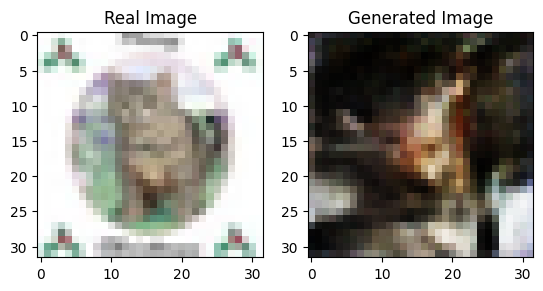

Epoch [27/300], Step [0/157], d_loss: 0.42322206497192383, g_loss: 11.888041496276855
Epoch [27/300], Step [100/157], d_loss: 3.355766773223877, g_loss: 27.82825469970703


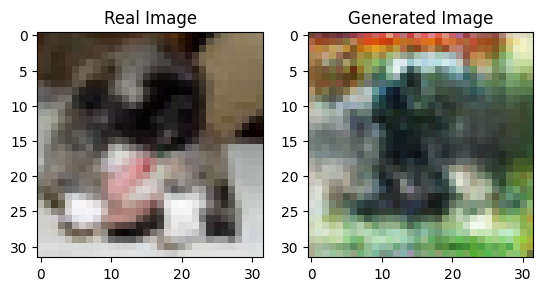

Epoch [28/300], Step [0/157], d_loss: 0.6819979548454285, g_loss: 23.35692024230957
Epoch [28/300], Step [100/157], d_loss: 0.05285104364156723, g_loss: 11.983596801757812


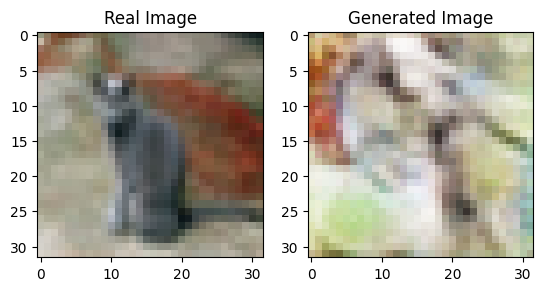

Epoch [29/300], Step [0/157], d_loss: 0.012961328029632568, g_loss: 11.982477188110352
Epoch [29/300], Step [100/157], d_loss: 0.07865002751350403, g_loss: 12.107481002807617


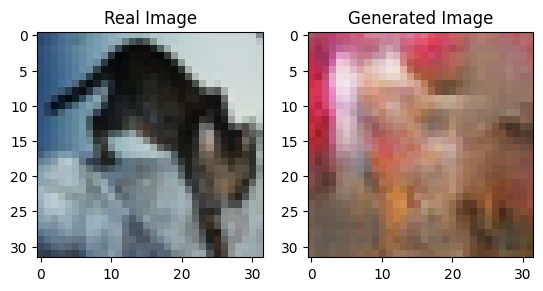

Epoch [30/300], Step [0/157], d_loss: 0.050272878259420395, g_loss: 12.66624927520752
Epoch [30/300], Step [100/157], d_loss: 0.060836292803287506, g_loss: 9.224712371826172


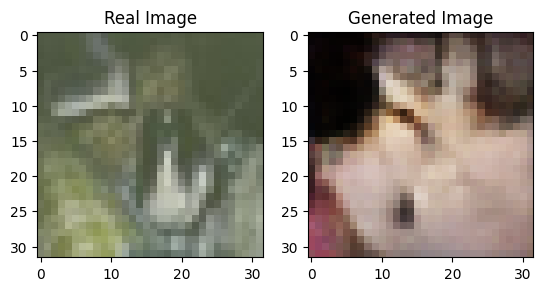

Epoch [31/300], Step [0/157], d_loss: 0.04433491826057434, g_loss: 9.567972183227539
Epoch [31/300], Step [100/157], d_loss: 0.7459115982055664, g_loss: 19.701492309570312


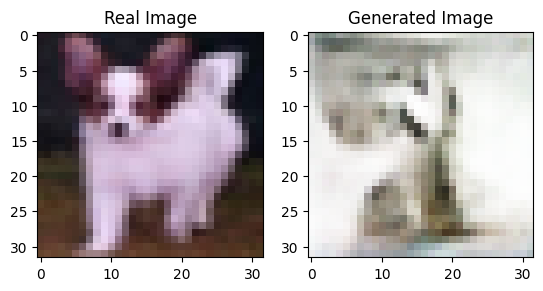

Epoch [32/300], Step [0/157], d_loss: 0.06514866650104523, g_loss: 16.161073684692383
Epoch [32/300], Step [100/157], d_loss: 0.025052279233932495, g_loss: 10.208884239196777


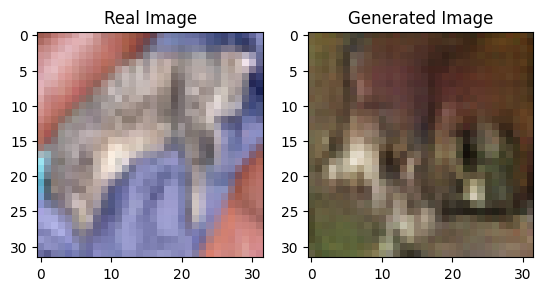

Epoch [33/300], Step [0/157], d_loss: 0.039604052901268005, g_loss: 13.699612617492676
Epoch [33/300], Step [100/157], d_loss: 0.015146107412874699, g_loss: 14.803155899047852


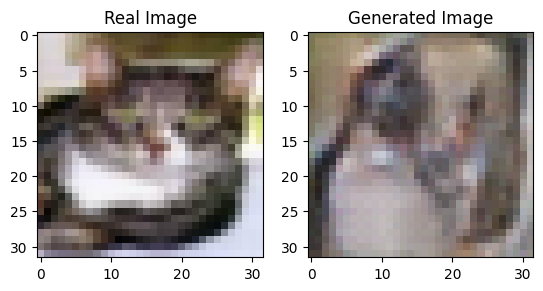

Epoch [34/300], Step [0/157], d_loss: 1.013128399848938, g_loss: 25.007007598876953
Epoch [34/300], Step [100/157], d_loss: 0.10111144930124283, g_loss: 20.318744659423828


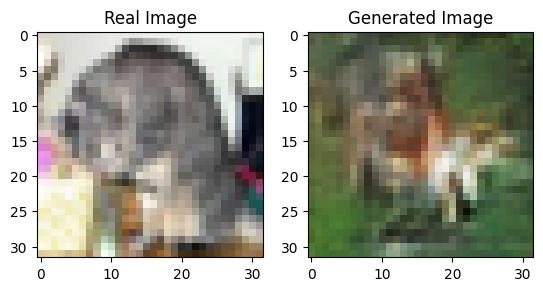

Epoch [35/300], Step [0/157], d_loss: 0.9184363484382629, g_loss: 10.67114543914795
Epoch [35/300], Step [100/157], d_loss: 0.08827321231365204, g_loss: 7.122392654418945


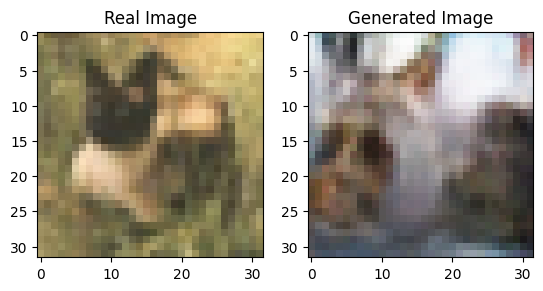

Epoch [36/300], Step [0/157], d_loss: 0.038717154413461685, g_loss: 10.122289657592773
Epoch [36/300], Step [100/157], d_loss: 0.04263697564601898, g_loss: 12.378129959106445


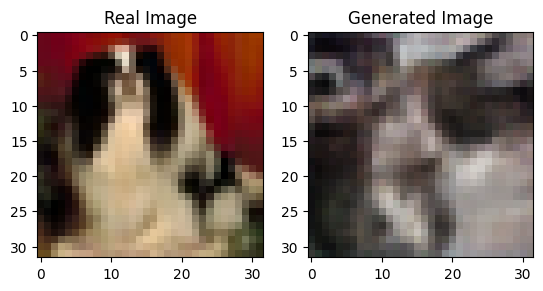

Epoch [37/300], Step [0/157], d_loss: 0.031452618539333344, g_loss: 9.660033226013184
Epoch [37/300], Step [100/157], d_loss: 0.3828888535499573, g_loss: 16.536699295043945


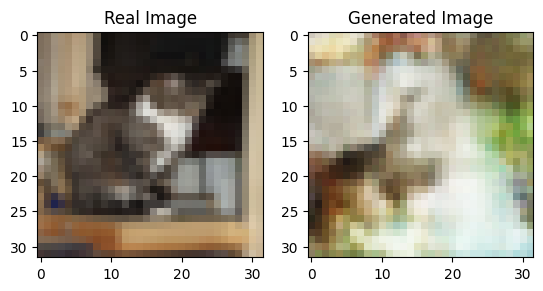

Epoch [38/300], Step [0/157], d_loss: 0.04696334898471832, g_loss: 13.914752006530762
Epoch [38/300], Step [100/157], d_loss: 0.04671463370323181, g_loss: 11.1753568649292


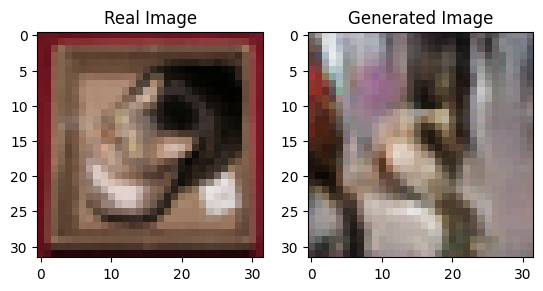

Epoch [39/300], Step [0/157], d_loss: 0.07797584682703018, g_loss: 14.341447830200195
Epoch [39/300], Step [100/157], d_loss: 0.010503994300961494, g_loss: 11.872986793518066


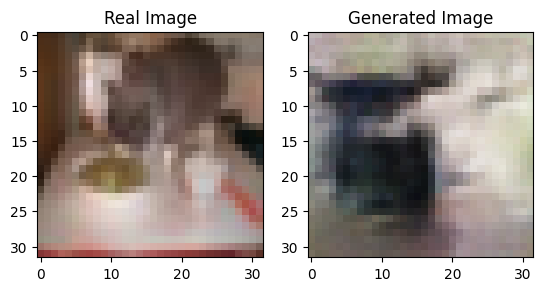

Epoch [40/300], Step [0/157], d_loss: 0.4110797643661499, g_loss: 9.52305793762207
Epoch [40/300], Step [100/157], d_loss: 0.07151142507791519, g_loss: 11.972901344299316


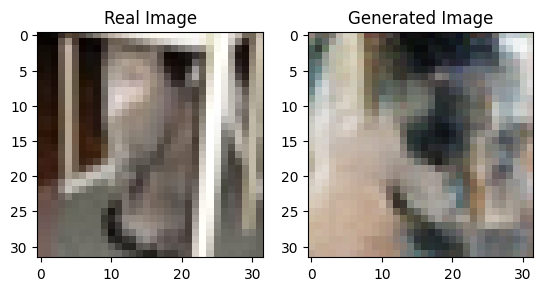

Epoch [41/300], Step [0/157], d_loss: 0.04004344344139099, g_loss: 16.133251190185547
Epoch [41/300], Step [100/157], d_loss: 0.19886459410190582, g_loss: 25.392574310302734


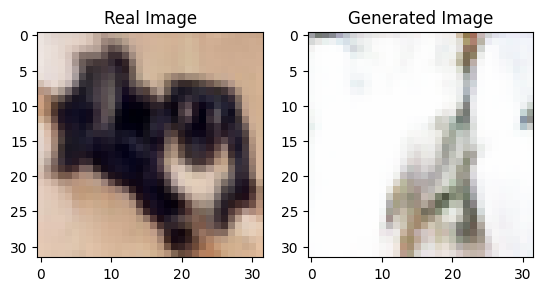

Epoch [42/300], Step [0/157], d_loss: 0.05410408973693848, g_loss: 19.029356002807617
Epoch [42/300], Step [100/157], d_loss: 0.08716120570898056, g_loss: 14.097782135009766


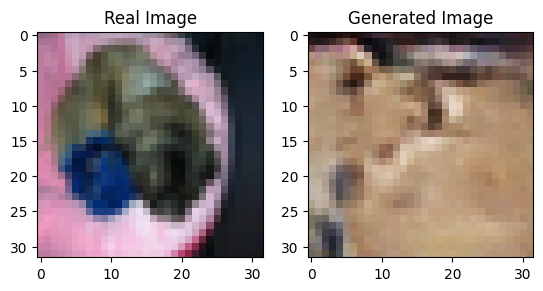

Epoch [43/300], Step [0/157], d_loss: 0.020380351692438126, g_loss: 13.026530265808105
Epoch [43/300], Step [100/157], d_loss: 0.16136187314987183, g_loss: 12.857660293579102


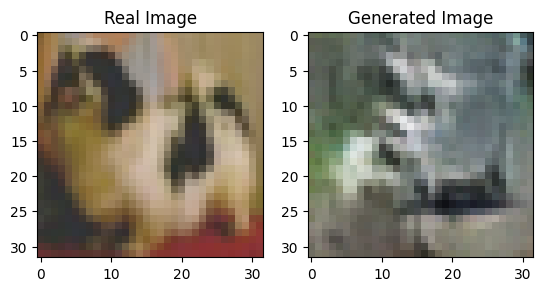

Epoch [44/300], Step [0/157], d_loss: 0.04475218802690506, g_loss: 15.481050491333008
Epoch [44/300], Step [100/157], d_loss: 0.057135310024023056, g_loss: 11.904364585876465


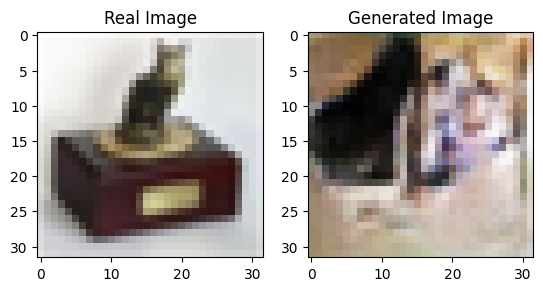

Epoch [45/300], Step [0/157], d_loss: 0.03974343091249466, g_loss: 22.306514739990234
Epoch [45/300], Step [100/157], d_loss: 0.10394620895385742, g_loss: 20.147783279418945


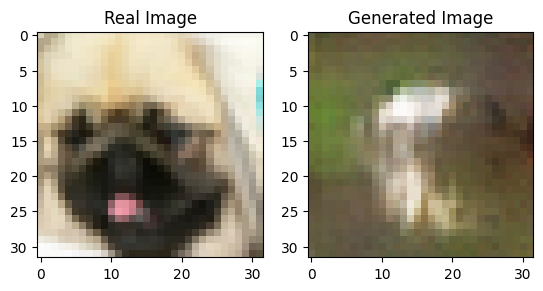

Epoch [46/300], Step [0/157], d_loss: 0.029354004189372063, g_loss: 20.987720489501953
Epoch [46/300], Step [100/157], d_loss: 0.18234989047050476, g_loss: 12.22628402709961


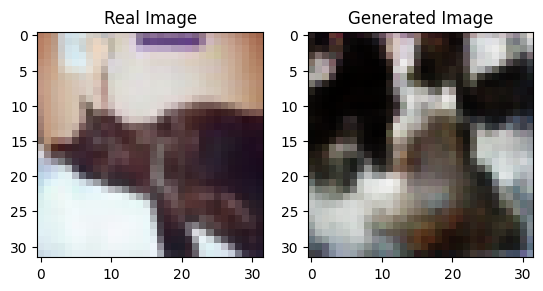

Epoch [47/300], Step [0/157], d_loss: 0.018641484901309013, g_loss: 13.469962120056152
Epoch [47/300], Step [100/157], d_loss: 0.046238772571086884, g_loss: 10.69359302520752


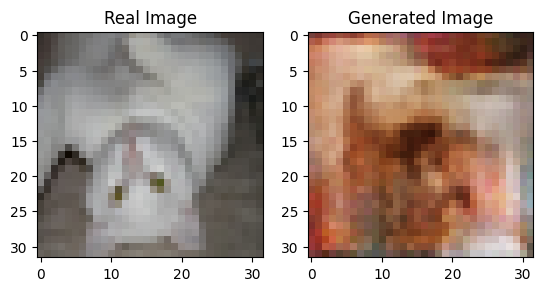

Epoch [48/300], Step [0/157], d_loss: 0.009314309805631638, g_loss: 20.754905700683594
Epoch [48/300], Step [100/157], d_loss: 0.019785042852163315, g_loss: 11.884937286376953


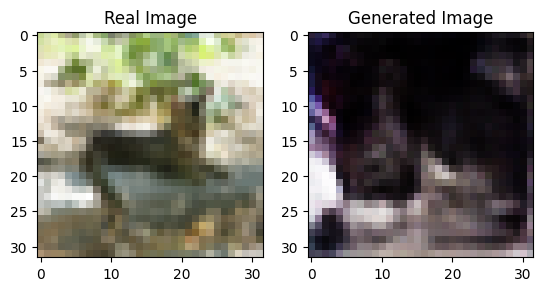

Epoch [49/300], Step [0/157], d_loss: 0.9728516340255737, g_loss: 16.802875518798828
Epoch [49/300], Step [100/157], d_loss: 0.4206004738807678, g_loss: 13.010802268981934


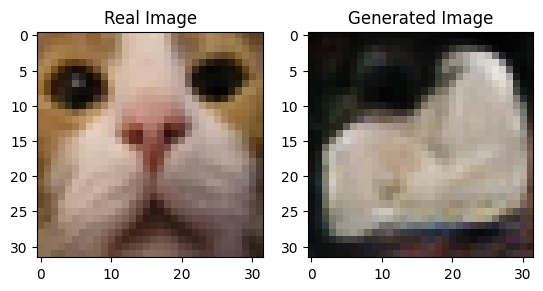

Epoch [50/300], Step [0/157], d_loss: 0.1317128688097, g_loss: 12.658491134643555
Epoch [50/300], Step [100/157], d_loss: 0.02640370838344097, g_loss: 17.83930778503418


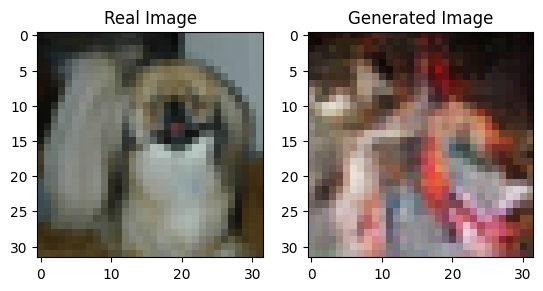

Epoch [51/300], Step [0/157], d_loss: 0.051741115748882294, g_loss: 13.30724811553955
Epoch [51/300], Step [100/157], d_loss: 0.15059232711791992, g_loss: 19.182987213134766


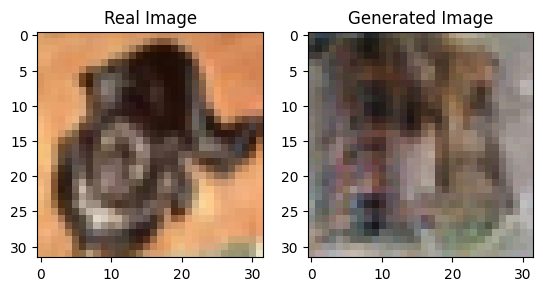

Epoch [52/300], Step [0/157], d_loss: 0.3262111246585846, g_loss: 18.72046661376953
Epoch [52/300], Step [100/157], d_loss: 0.027393007650971413, g_loss: 8.894248962402344


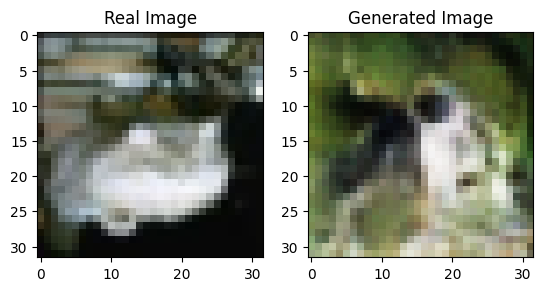

Epoch [53/300], Step [0/157], d_loss: 0.11198068410158157, g_loss: 11.003692626953125
Epoch [53/300], Step [100/157], d_loss: 0.030444949865341187, g_loss: 16.709951400756836


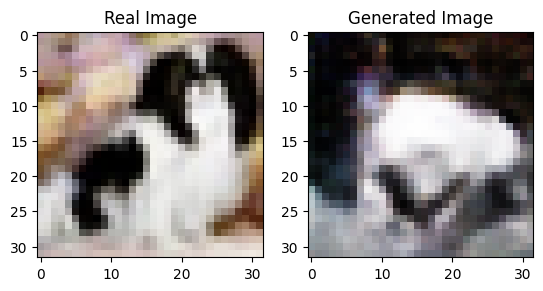

Epoch [54/300], Step [0/157], d_loss: 0.021648148074746132, g_loss: 15.042478561401367
Epoch [54/300], Step [100/157], d_loss: 0.013358458876609802, g_loss: 17.21761703491211


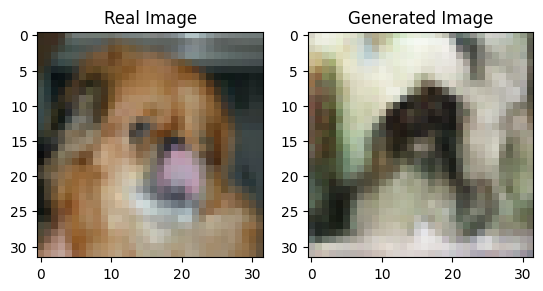

Epoch [55/300], Step [0/157], d_loss: 0.040952350944280624, g_loss: 12.006156921386719
Epoch [55/300], Step [100/157], d_loss: 0.01038375310599804, g_loss: 14.507650375366211


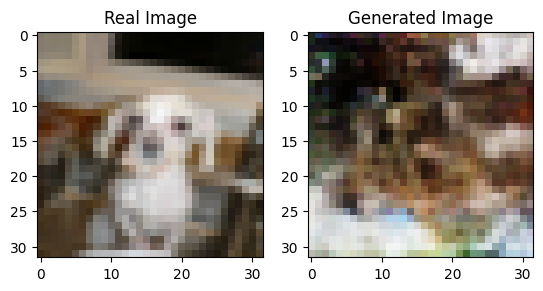

Epoch [56/300], Step [0/157], d_loss: 0.023130904883146286, g_loss: 14.193429946899414
Epoch [56/300], Step [100/157], d_loss: 0.038007333874702454, g_loss: 27.47168731689453


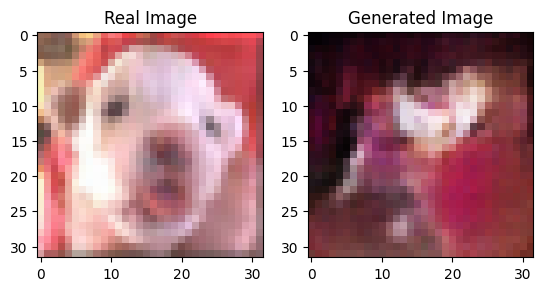

Epoch [57/300], Step [0/157], d_loss: 0.29190611839294434, g_loss: 13.672605514526367
Epoch [57/300], Step [100/157], d_loss: 0.03413141518831253, g_loss: 14.944679260253906


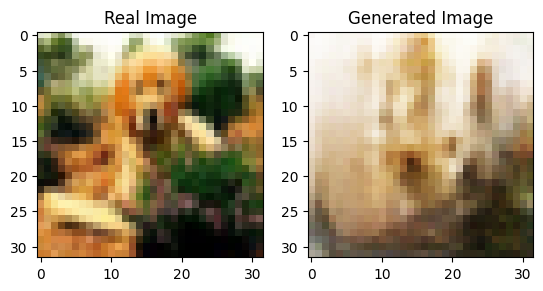

Epoch [58/300], Step [0/157], d_loss: 0.3733521103858948, g_loss: 21.602624893188477
Epoch [58/300], Step [100/157], d_loss: 0.13242888450622559, g_loss: 24.98638153076172


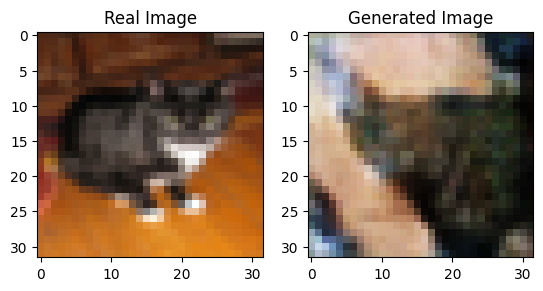

Epoch [59/300], Step [0/157], d_loss: 0.022073233500123024, g_loss: 13.417478561401367
Epoch [59/300], Step [100/157], d_loss: 0.010767593048512936, g_loss: 14.785271644592285


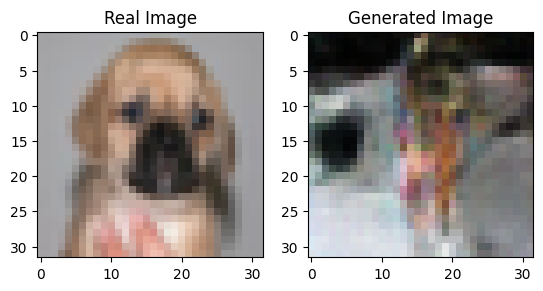

Epoch [60/300], Step [0/157], d_loss: 0.7094718813896179, g_loss: 8.75587272644043
Epoch [60/300], Step [100/157], d_loss: 0.18611443042755127, g_loss: 10.8191499710083


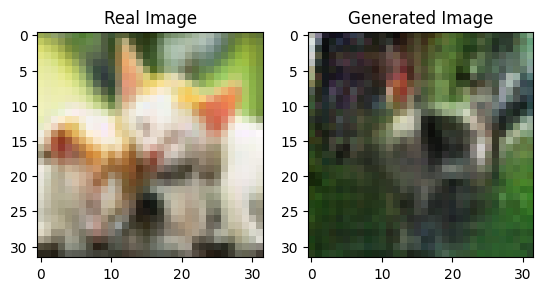

Epoch [61/300], Step [0/157], d_loss: 0.11117640137672424, g_loss: 17.05171012878418
Epoch [61/300], Step [100/157], d_loss: 0.023473002016544342, g_loss: 10.692960739135742


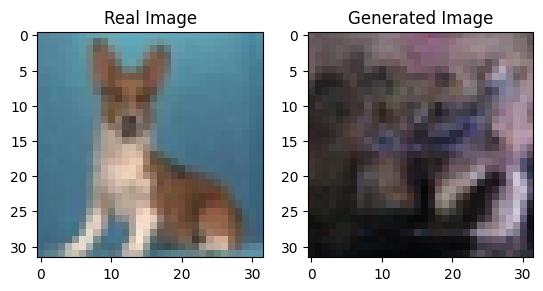

Epoch [62/300], Step [0/157], d_loss: 0.24381783604621887, g_loss: 14.418124198913574
Epoch [62/300], Step [100/157], d_loss: 0.7486459612846375, g_loss: 13.984525680541992


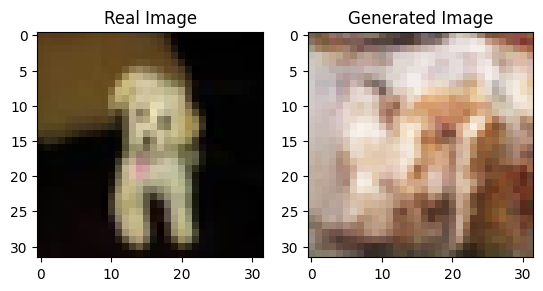

Epoch [63/300], Step [0/157], d_loss: 0.1512530893087387, g_loss: 11.584939002990723
Epoch [63/300], Step [100/157], d_loss: 0.016169212758541107, g_loss: 8.08088207244873


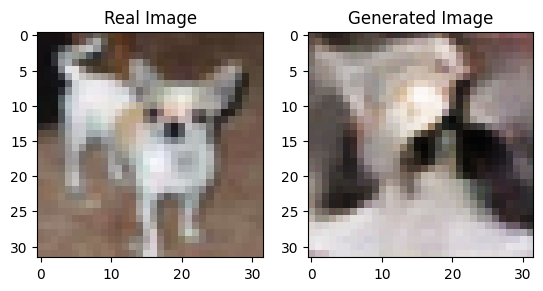

Epoch [64/300], Step [0/157], d_loss: 0.049657467752695084, g_loss: 21.023174285888672
Epoch [64/300], Step [100/157], d_loss: 0.057473376393318176, g_loss: 12.365620613098145


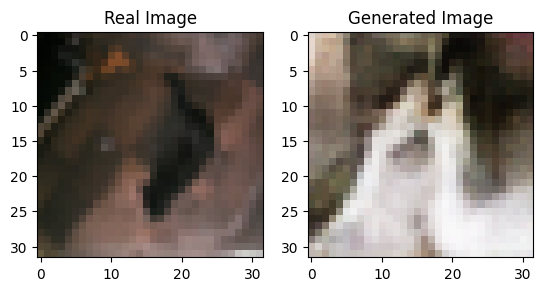

Epoch [65/300], Step [0/157], d_loss: 0.015190917067229748, g_loss: 22.01299285888672
Epoch [65/300], Step [100/157], d_loss: 0.0410287119448185, g_loss: 13.539920806884766


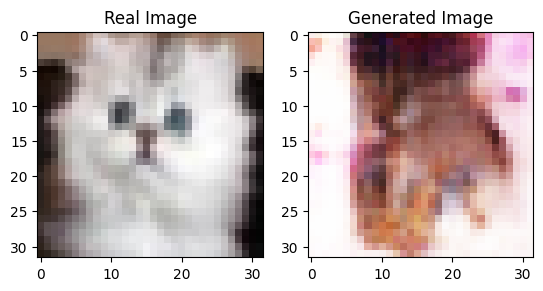

Epoch [66/300], Step [0/157], d_loss: 0.05968103185296059, g_loss: 10.048510551452637
Epoch [66/300], Step [100/157], d_loss: 0.13308417797088623, g_loss: 10.625186920166016


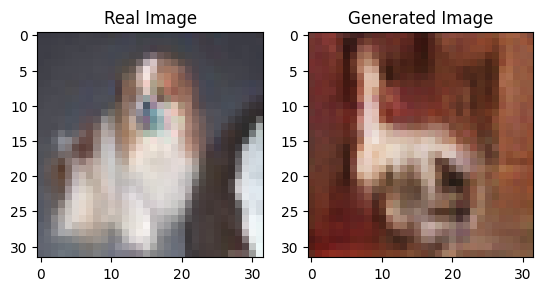

Epoch [67/300], Step [0/157], d_loss: 0.15395063161849976, g_loss: 14.380353927612305
Epoch [67/300], Step [100/157], d_loss: 0.11996831744909286, g_loss: 18.613107681274414


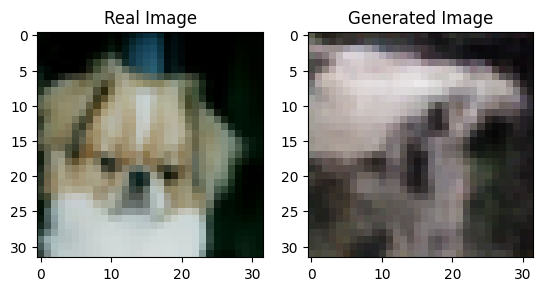

Epoch [68/300], Step [0/157], d_loss: 0.1599283218383789, g_loss: 9.839631080627441
Epoch [68/300], Step [100/157], d_loss: 0.09248229116201401, g_loss: 12.30999755859375


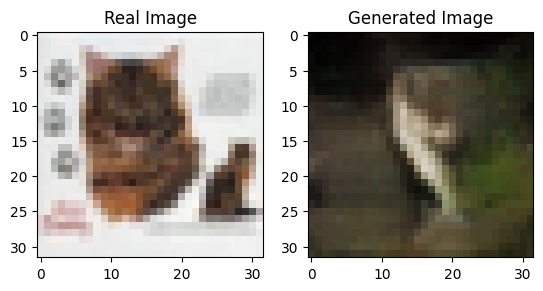

Epoch [69/300], Step [0/157], d_loss: 0.015887489542365074, g_loss: 25.24866485595703
Epoch [69/300], Step [100/157], d_loss: 0.01626509428024292, g_loss: 14.809524536132812


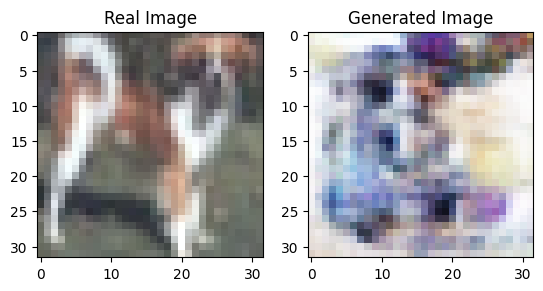

Epoch [70/300], Step [0/157], d_loss: 0.013909172266721725, g_loss: 12.455822944641113
Epoch [70/300], Step [100/157], d_loss: 0.01237864512950182, g_loss: 13.236542701721191


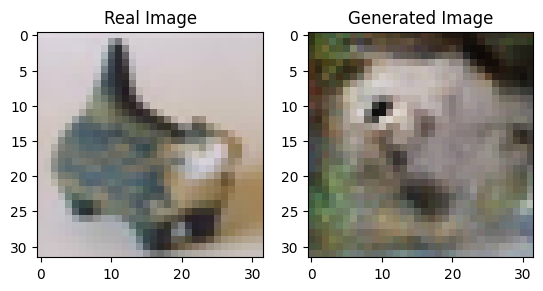

Epoch [71/300], Step [0/157], d_loss: 0.08377253264188766, g_loss: 12.554717063903809
Epoch [71/300], Step [100/157], d_loss: 0.017836520448327065, g_loss: 14.230247497558594


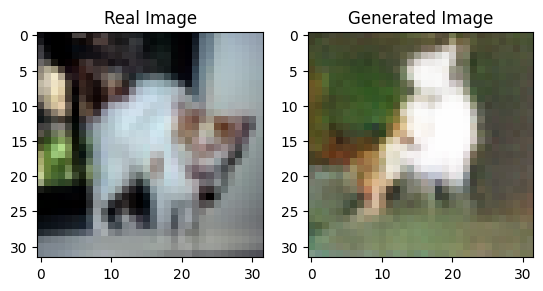

Epoch [72/300], Step [0/157], d_loss: 0.015154010616242886, g_loss: 15.221504211425781
Epoch [72/300], Step [100/157], d_loss: 0.04553649574518204, g_loss: 9.74100399017334


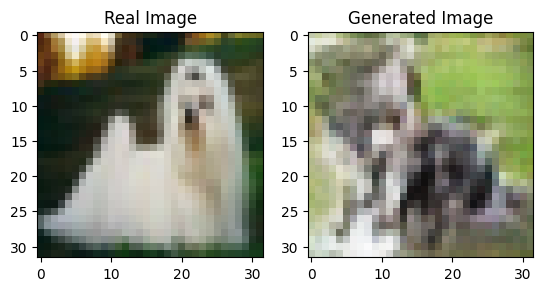

Epoch [73/300], Step [0/157], d_loss: 0.3230431377887726, g_loss: 22.735435485839844
Epoch [73/300], Step [100/157], d_loss: 0.01320530567318201, g_loss: 9.769474983215332


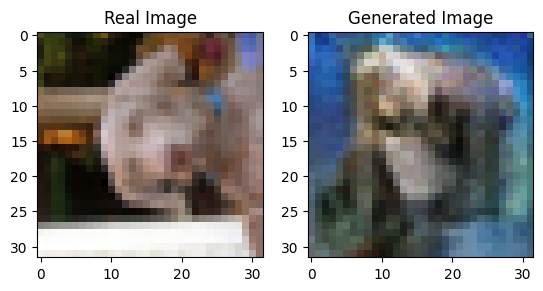

Epoch [74/300], Step [0/157], d_loss: 0.031952932476997375, g_loss: 10.806438446044922
Epoch [74/300], Step [100/157], d_loss: 0.18953008949756622, g_loss: 16.461610794067383


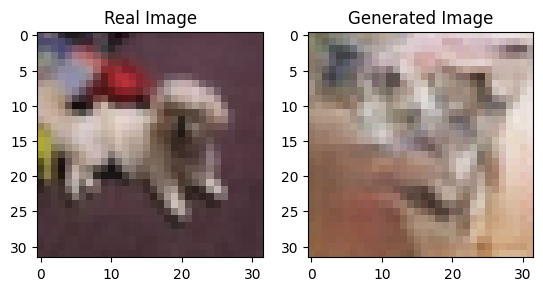

Epoch [75/300], Step [0/157], d_loss: 0.03944975137710571, g_loss: 14.426877975463867
Epoch [75/300], Step [100/157], d_loss: 1.1635921001434326, g_loss: 21.725830078125


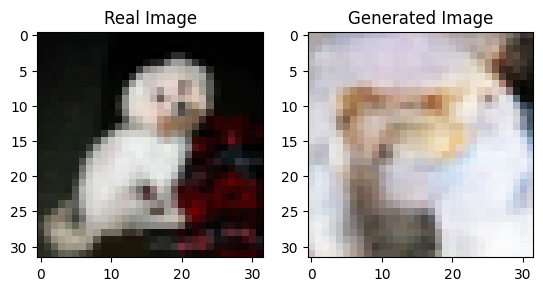

Epoch [76/300], Step [0/157], d_loss: 0.054738737642765045, g_loss: 11.123870849609375
Epoch [76/300], Step [100/157], d_loss: 0.019218599423766136, g_loss: 13.438611030578613


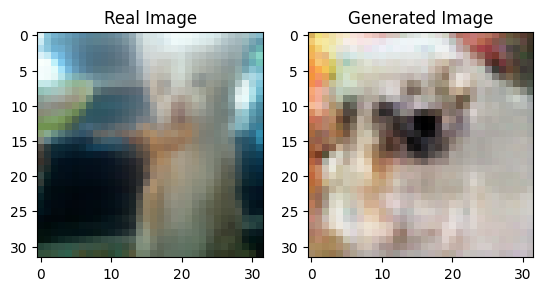

Epoch [77/300], Step [0/157], d_loss: 0.02424900233745575, g_loss: 11.056568145751953
Epoch [77/300], Step [100/157], d_loss: 0.020201051607728004, g_loss: 12.52590560913086


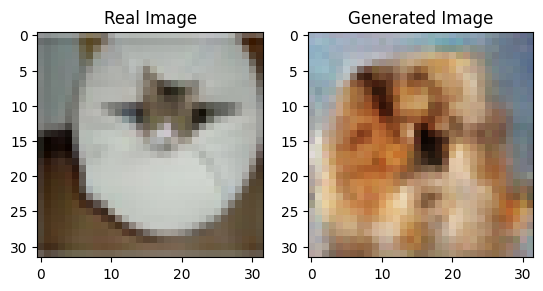

Epoch [78/300], Step [0/157], d_loss: 0.5046703815460205, g_loss: 28.179656982421875
Epoch [78/300], Step [100/157], d_loss: 0.03983667492866516, g_loss: 14.590425491333008


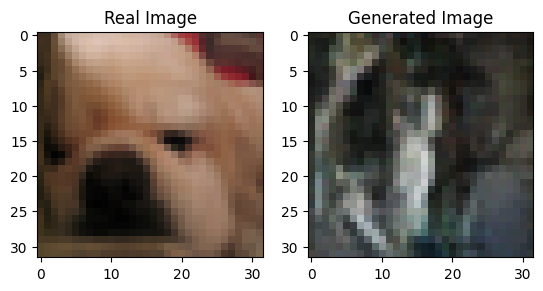

Epoch [79/300], Step [0/157], d_loss: 0.521125078201294, g_loss: 9.88364315032959
Epoch [79/300], Step [100/157], d_loss: 0.20389211177825928, g_loss: 12.084580421447754


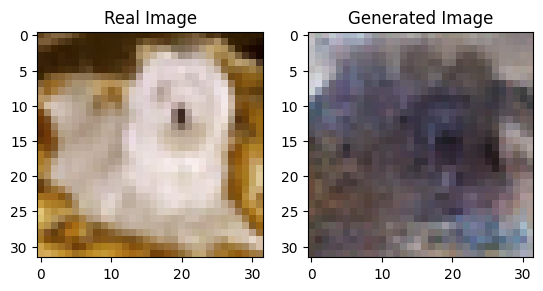

Epoch [80/300], Step [0/157], d_loss: 0.3513926863670349, g_loss: 14.473160743713379
Epoch [80/300], Step [100/157], d_loss: 0.011001067236065865, g_loss: 12.129312515258789


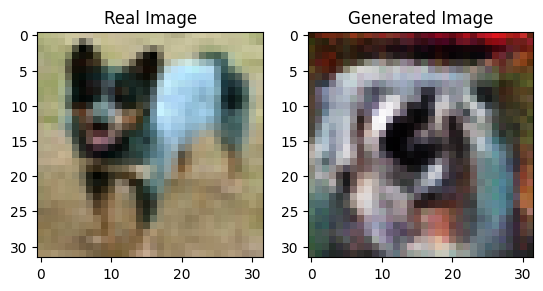

Epoch [81/300], Step [0/157], d_loss: 0.019347386434674263, g_loss: 12.730001449584961
Epoch [81/300], Step [100/157], d_loss: 0.027451980859041214, g_loss: 12.481451034545898


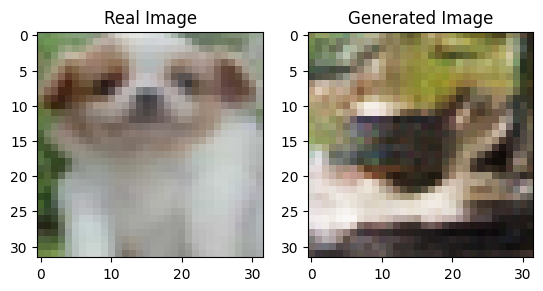

Epoch [82/300], Step [0/157], d_loss: 0.18835490942001343, g_loss: 17.578758239746094
Epoch [82/300], Step [100/157], d_loss: 0.009203160181641579, g_loss: 12.047477722167969


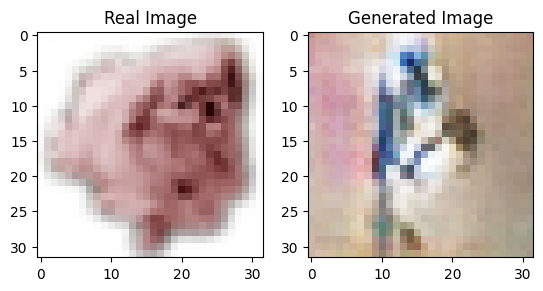

Epoch [83/300], Step [0/157], d_loss: 1.0008156299591064, g_loss: 13.869494438171387
Epoch [83/300], Step [100/157], d_loss: 0.025780513882637024, g_loss: 18.285011291503906


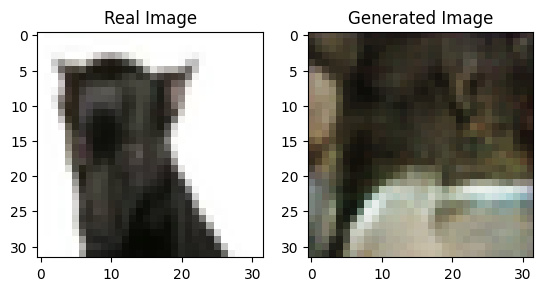

Epoch [84/300], Step [0/157], d_loss: 0.027788864448666573, g_loss: 12.141220092773438
Epoch [84/300], Step [100/157], d_loss: 0.017465975135564804, g_loss: 13.585315704345703


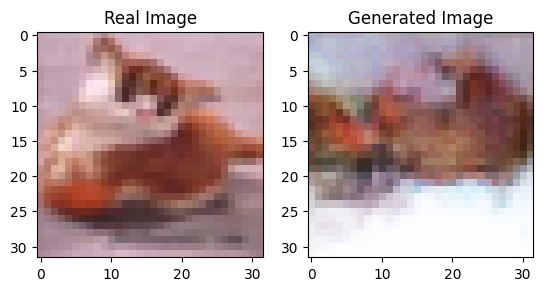

Epoch [85/300], Step [0/157], d_loss: 0.06721457839012146, g_loss: 11.612804412841797
Epoch [85/300], Step [100/157], d_loss: 0.021602053195238113, g_loss: 12.461114883422852


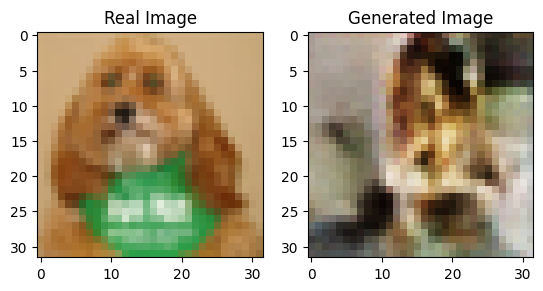

Epoch [86/300], Step [0/157], d_loss: 0.022656602784991264, g_loss: 13.740995407104492
Epoch [86/300], Step [100/157], d_loss: 0.027377773076295853, g_loss: 9.422627449035645


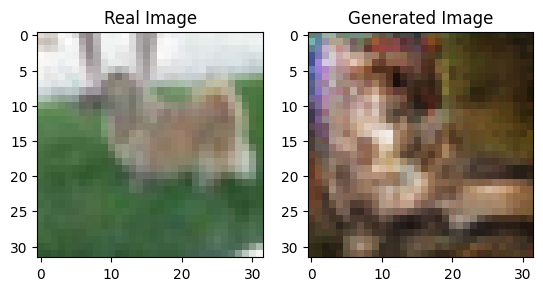

Epoch [87/300], Step [0/157], d_loss: 0.015221040695905685, g_loss: 10.830591201782227
Epoch [87/300], Step [100/157], d_loss: 0.03721623495221138, g_loss: 11.27341079711914


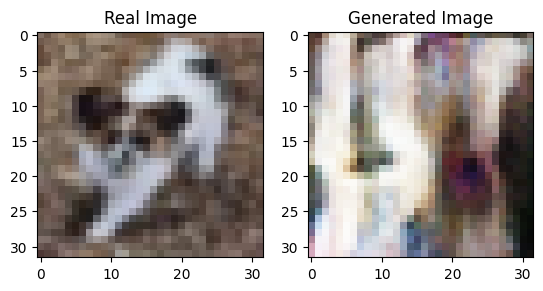

Epoch [88/300], Step [0/157], d_loss: 0.039920125156641006, g_loss: 24.484895706176758
Epoch [88/300], Step [100/157], d_loss: 0.18950721621513367, g_loss: 11.004941940307617


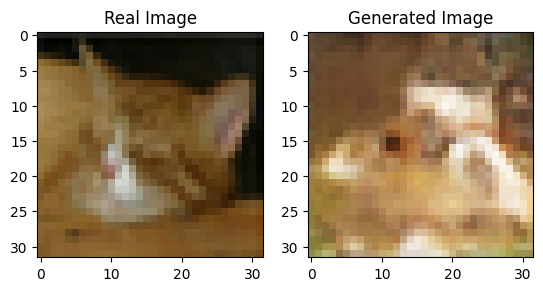

Epoch [89/300], Step [0/157], d_loss: 0.06080545485019684, g_loss: 22.388916015625
Epoch [89/300], Step [100/157], d_loss: 0.1587081402540207, g_loss: 24.79827117919922


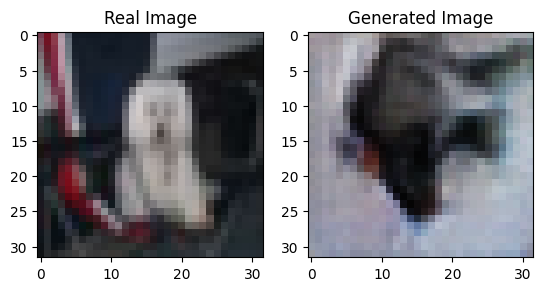

Epoch [90/300], Step [0/157], d_loss: 0.046332113444805145, g_loss: 12.007302284240723
Epoch [90/300], Step [100/157], d_loss: 0.007797911763191223, g_loss: 12.259836196899414


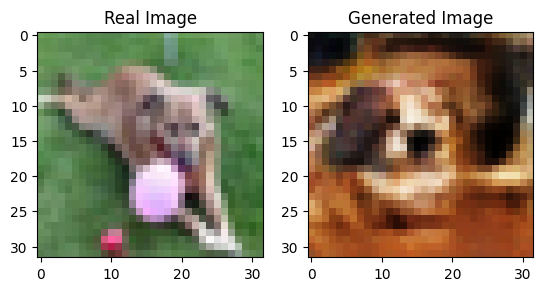

Epoch [91/300], Step [0/157], d_loss: 0.07689150422811508, g_loss: 28.816936492919922
Epoch [91/300], Step [100/157], d_loss: 0.02488725446164608, g_loss: 17.82296371459961


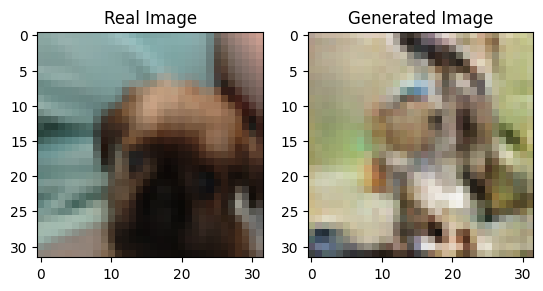

Epoch [92/300], Step [0/157], d_loss: 0.026718394830822945, g_loss: 10.533470153808594
Epoch [92/300], Step [100/157], d_loss: 0.15535613894462585, g_loss: 13.559313774108887


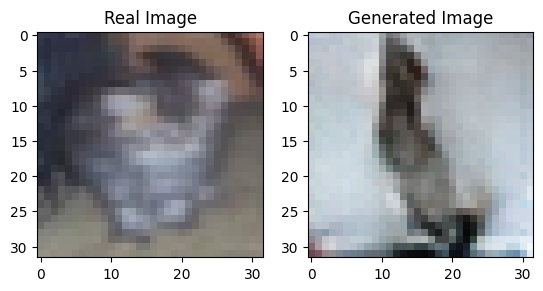

Epoch [93/300], Step [0/157], d_loss: 0.008944790810346603, g_loss: 14.275617599487305
Epoch [93/300], Step [100/157], d_loss: 0.006258421111851931, g_loss: 16.347461700439453


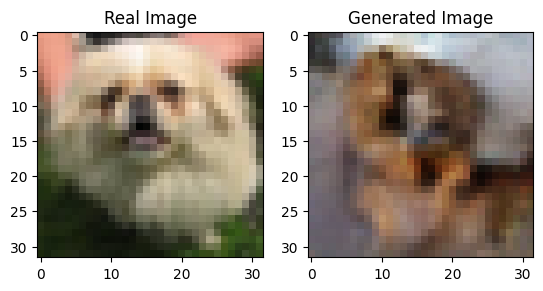

Epoch [94/300], Step [0/157], d_loss: 0.005390808917582035, g_loss: 16.151859283447266
Epoch [94/300], Step [100/157], d_loss: 0.003145815571770072, g_loss: 26.321372985839844


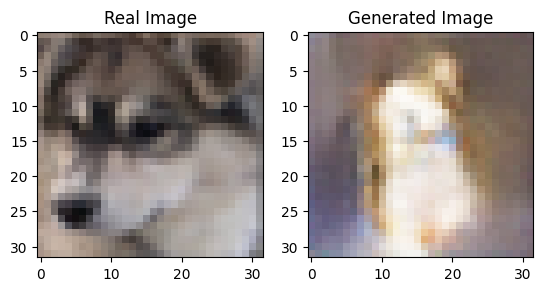

Epoch [95/300], Step [0/157], d_loss: 0.00419590575620532, g_loss: 14.95366382598877
Epoch [95/300], Step [100/157], d_loss: 0.0036542373709380627, g_loss: 17.991640090942383


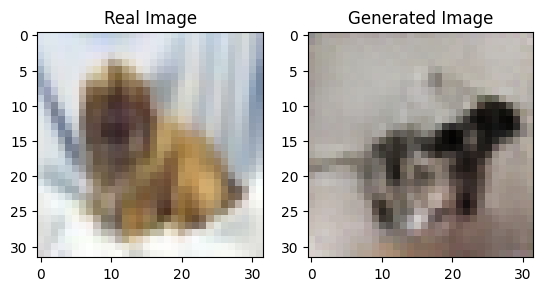

Epoch [96/300], Step [0/157], d_loss: 0.019238756969571114, g_loss: 17.7978515625
Epoch [96/300], Step [100/157], d_loss: 0.6224125027656555, g_loss: 18.542903900146484


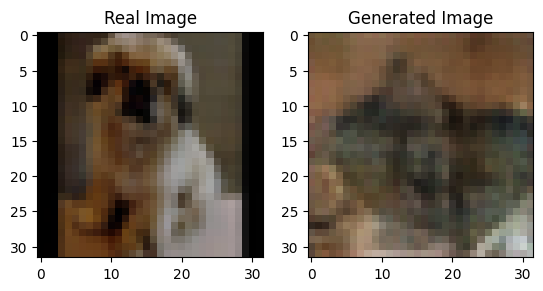

Epoch [97/300], Step [0/157], d_loss: 0.14824530482292175, g_loss: 12.268356323242188
Epoch [97/300], Step [100/157], d_loss: 0.006760274525731802, g_loss: 16.70646858215332


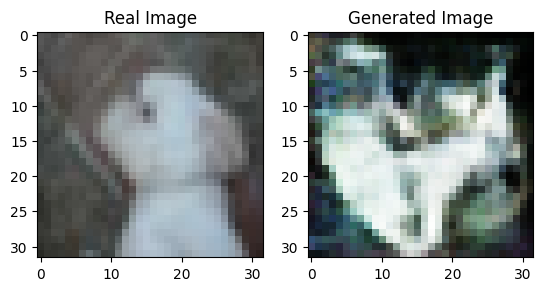

Epoch [98/300], Step [0/157], d_loss: 0.09202016890048981, g_loss: 15.52529525756836
Epoch [98/300], Step [100/157], d_loss: 0.014492669142782688, g_loss: 13.922399520874023


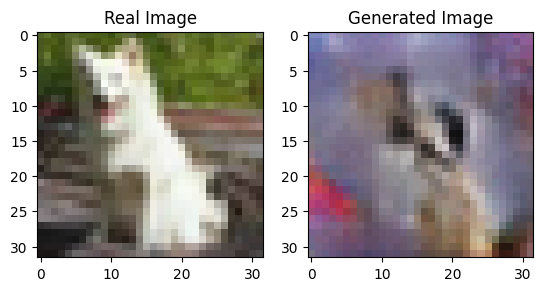

Epoch [99/300], Step [0/157], d_loss: 0.04960330203175545, g_loss: 20.511398315429688
Epoch [99/300], Step [100/157], d_loss: 0.009294266812503338, g_loss: 17.934894561767578


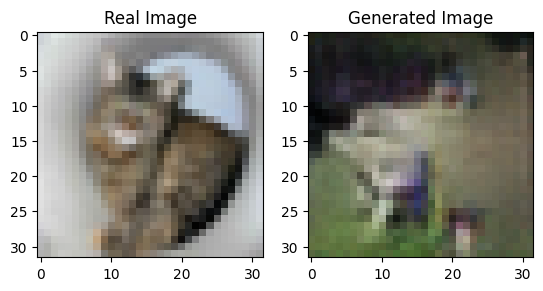

Epoch [100/300], Step [0/157], d_loss: 0.0052004652097821236, g_loss: 23.324817657470703
Epoch [100/300], Step [100/157], d_loss: 0.15864644944667816, g_loss: 19.19084930419922


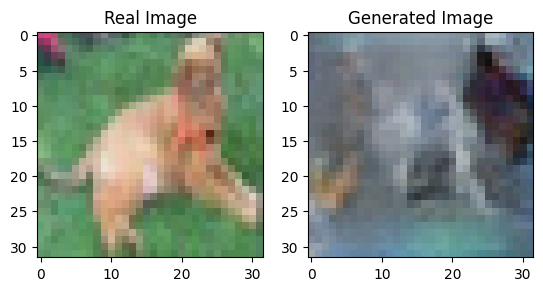

Epoch [101/300], Step [0/157], d_loss: 0.03514106571674347, g_loss: 27.927005767822266
Epoch [101/300], Step [100/157], d_loss: 0.004666193388402462, g_loss: 22.990036010742188


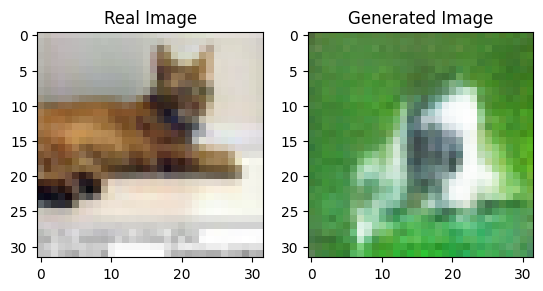

Epoch [102/300], Step [0/157], d_loss: 0.09958592057228088, g_loss: 14.704263687133789
Epoch [102/300], Step [100/157], d_loss: 0.04436305910348892, g_loss: 17.262187957763672


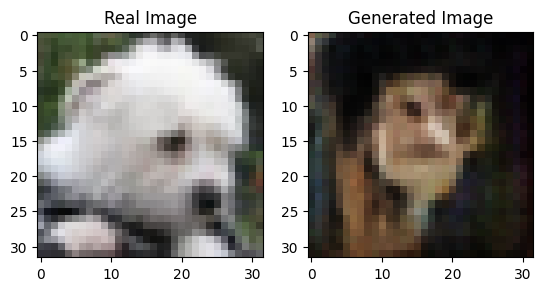

Epoch [103/300], Step [0/157], d_loss: 0.2497088760137558, g_loss: 25.701995849609375
Epoch [103/300], Step [100/157], d_loss: 0.05562741309404373, g_loss: 10.716114044189453


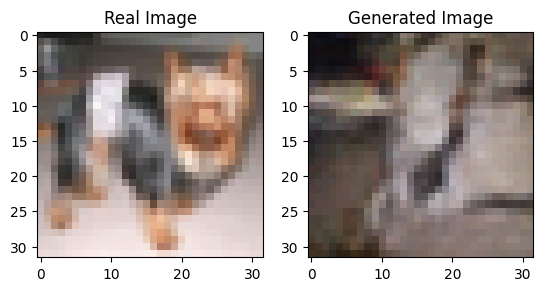

Epoch [104/300], Step [0/157], d_loss: 0.09405162930488586, g_loss: 24.231060028076172
Epoch [104/300], Step [100/157], d_loss: 0.07349139451980591, g_loss: 17.29822540283203


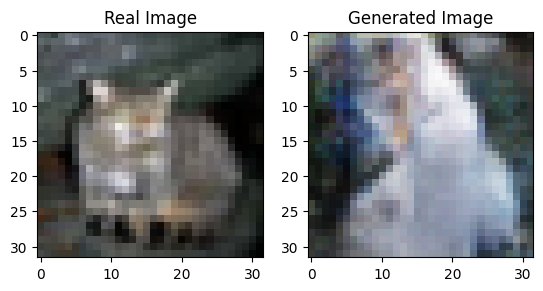

Epoch [105/300], Step [0/157], d_loss: 0.3890553116798401, g_loss: 27.897621154785156
Epoch [105/300], Step [100/157], d_loss: 0.05852987617254257, g_loss: 8.828691482543945


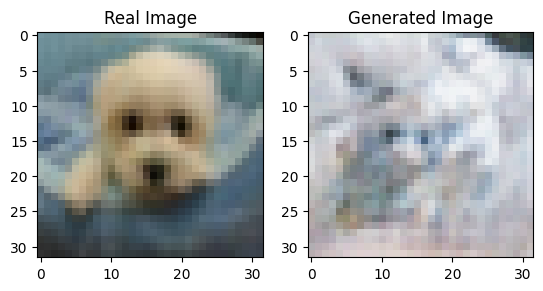

Epoch [106/300], Step [0/157], d_loss: 0.1632501482963562, g_loss: 11.703329086303711
Epoch [106/300], Step [100/157], d_loss: 0.005805669352412224, g_loss: 18.857004165649414


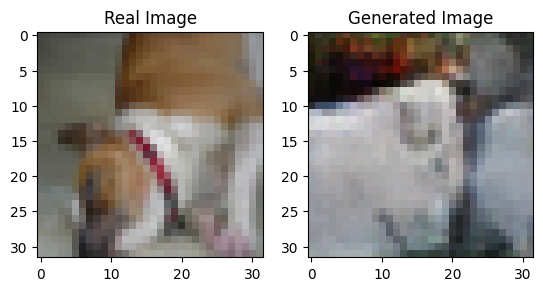

Epoch [107/300], Step [0/157], d_loss: 0.12506301701068878, g_loss: 10.678086280822754
Epoch [107/300], Step [100/157], d_loss: 0.006789865903556347, g_loss: 12.727283477783203


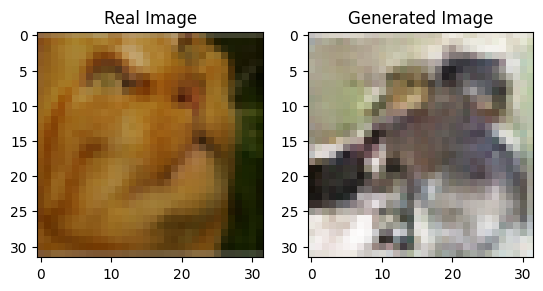

Epoch [108/300], Step [0/157], d_loss: 0.14069396257400513, g_loss: 25.942214965820312
Epoch [108/300], Step [100/157], d_loss: 0.01756015606224537, g_loss: 17.617752075195312


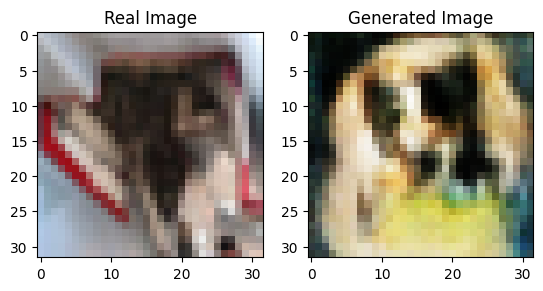

Epoch [109/300], Step [0/157], d_loss: 1.3672831058502197, g_loss: 32.88677978515625
Epoch [109/300], Step [100/157], d_loss: 0.045497827231884, g_loss: 13.433652877807617


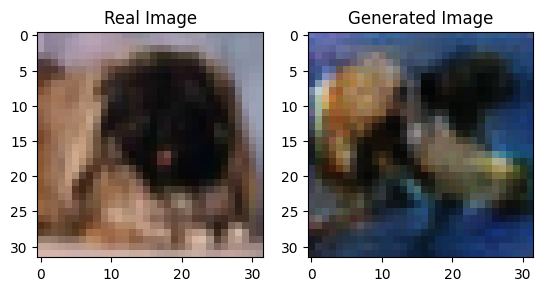

Epoch [110/300], Step [0/157], d_loss: 0.1198417916893959, g_loss: 13.774452209472656
Epoch [110/300], Step [100/157], d_loss: 0.01310255378484726, g_loss: 15.629837036132812


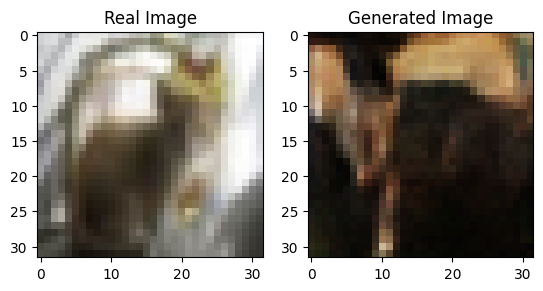

Epoch [111/300], Step [0/157], d_loss: 0.15963180363178253, g_loss: 31.174598693847656
Epoch [111/300], Step [100/157], d_loss: 0.04331177473068237, g_loss: 12.83375358581543


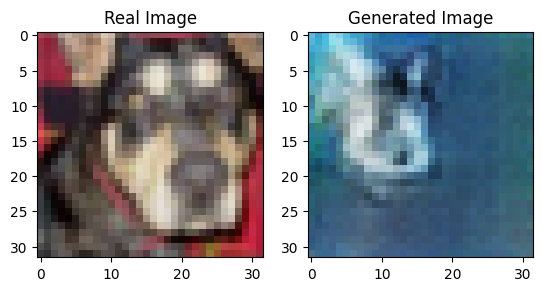

Epoch [112/300], Step [0/157], d_loss: 0.06282635778188705, g_loss: 13.053010940551758
Epoch [112/300], Step [100/157], d_loss: 0.07781034708023071, g_loss: 13.77657699584961


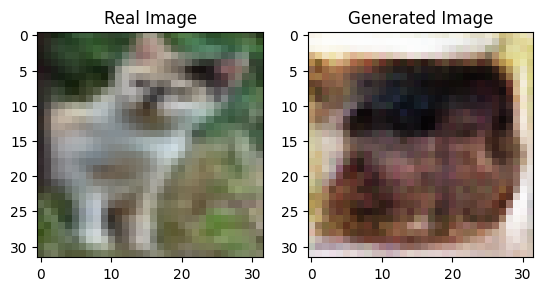

Epoch [113/300], Step [0/157], d_loss: 0.027645964175462723, g_loss: 12.573566436767578
Epoch [113/300], Step [100/157], d_loss: 0.004063480067998171, g_loss: 20.247278213500977


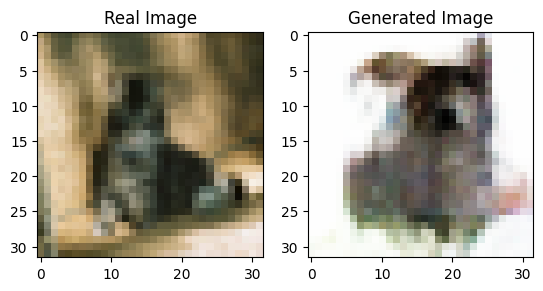

Epoch [114/300], Step [0/157], d_loss: 0.23737241327762604, g_loss: 7.416646957397461
Epoch [114/300], Step [100/157], d_loss: 0.012869969941675663, g_loss: 20.11074447631836


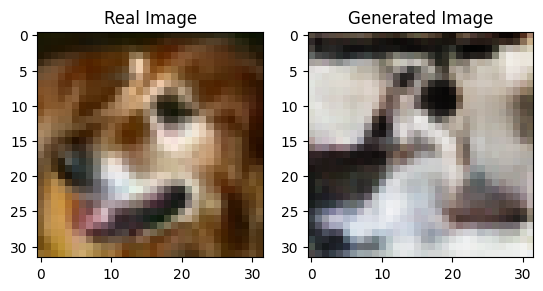

Epoch [115/300], Step [0/157], d_loss: 0.009226774796843529, g_loss: 20.328598022460938
Epoch [115/300], Step [100/157], d_loss: 0.07246402651071548, g_loss: 13.156011581420898


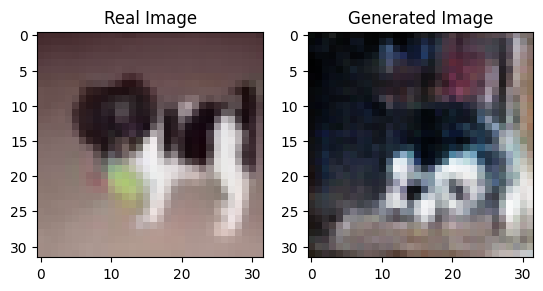

Epoch [116/300], Step [0/157], d_loss: 0.11375449597835541, g_loss: 9.954521179199219
Epoch [116/300], Step [100/157], d_loss: 0.04036096855998039, g_loss: 10.405523300170898


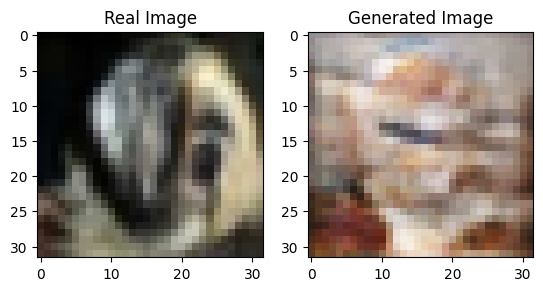

Epoch [117/300], Step [0/157], d_loss: 0.02106153778731823, g_loss: 17.423568725585938
Epoch [117/300], Step [100/157], d_loss: 0.08655833452939987, g_loss: 13.176630020141602


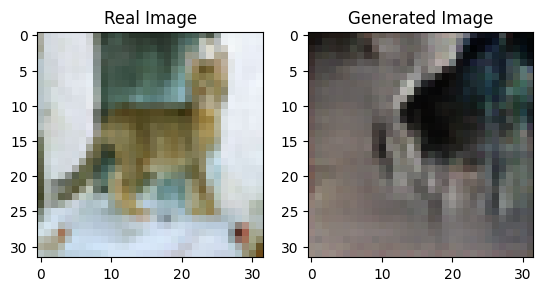

Epoch [118/300], Step [0/157], d_loss: 0.03258971497416496, g_loss: 19.287004470825195
Epoch [118/300], Step [100/157], d_loss: 0.021981632336974144, g_loss: 12.61424446105957


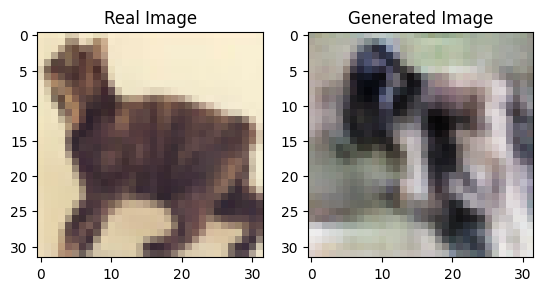

Epoch [119/300], Step [0/157], d_loss: 0.02023131772875786, g_loss: 15.175226211547852
Epoch [119/300], Step [100/157], d_loss: 0.0961918756365776, g_loss: 30.44422721862793


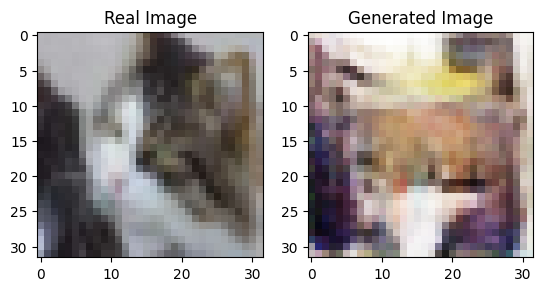

Epoch [120/300], Step [0/157], d_loss: 0.0028086011298000813, g_loss: 16.98052978515625
Epoch [120/300], Step [100/157], d_loss: 0.09694236516952515, g_loss: 12.972326278686523


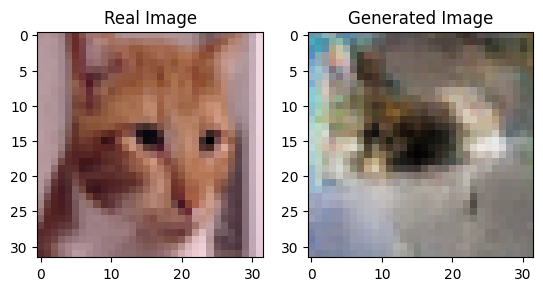

Epoch [121/300], Step [0/157], d_loss: 0.016406934708356857, g_loss: 18.80820655822754
Epoch [121/300], Step [100/157], d_loss: 0.006239949259907007, g_loss: 14.446510314941406


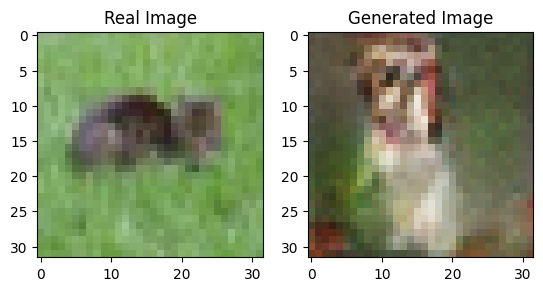

Epoch [122/300], Step [0/157], d_loss: 0.022314855828881264, g_loss: 19.474491119384766
Epoch [122/300], Step [100/157], d_loss: 0.0053156353533267975, g_loss: 17.881404876708984


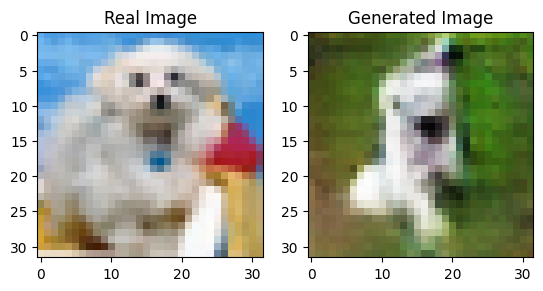

Epoch [123/300], Step [0/157], d_loss: 0.010170713067054749, g_loss: 16.324317932128906
Epoch [123/300], Step [100/157], d_loss: 0.02274041809141636, g_loss: 15.134511947631836


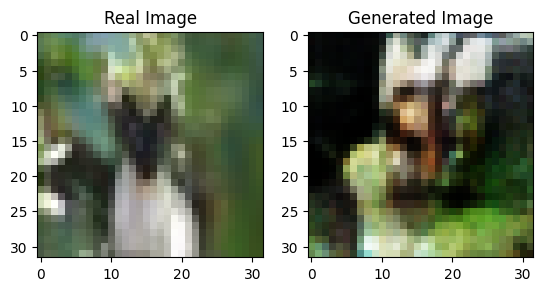

Epoch [124/300], Step [0/157], d_loss: 0.03192482143640518, g_loss: 19.922870635986328
Epoch [124/300], Step [100/157], d_loss: 0.007709961384534836, g_loss: 19.866546630859375


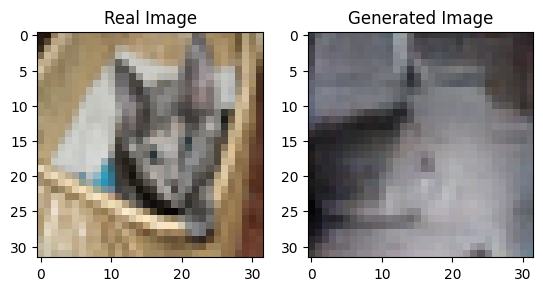

Epoch [125/300], Step [0/157], d_loss: 0.0790122002363205, g_loss: 13.759045600891113
Epoch [125/300], Step [100/157], d_loss: 0.011485878378152847, g_loss: 14.324247360229492


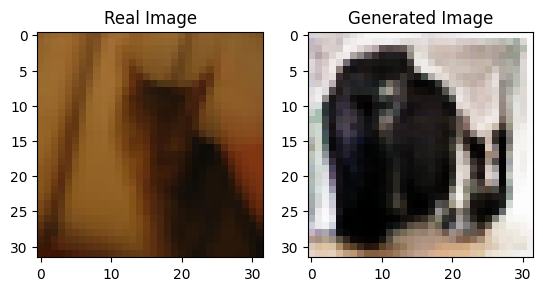

Epoch [126/300], Step [0/157], d_loss: 0.0031327130272984505, g_loss: 14.457253456115723
Epoch [126/300], Step [100/157], d_loss: 0.022282781079411507, g_loss: 12.136856079101562


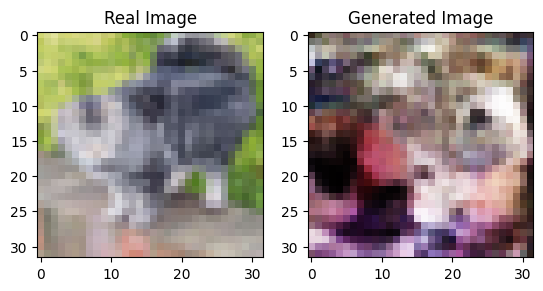

Epoch [127/300], Step [0/157], d_loss: 0.0028803241439163685, g_loss: 12.048306465148926
Epoch [127/300], Step [100/157], d_loss: 0.00257232878357172, g_loss: 27.034461975097656


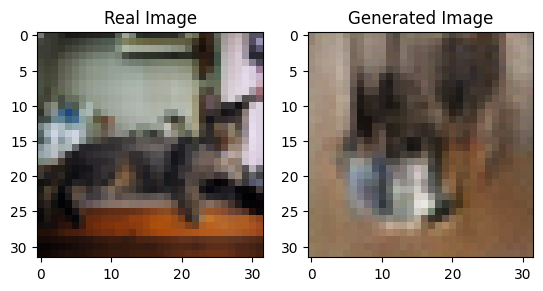

Epoch [128/300], Step [0/157], d_loss: 0.005352226551622152, g_loss: 16.214698791503906
Epoch [128/300], Step [100/157], d_loss: 0.1557007133960724, g_loss: 15.531722068786621


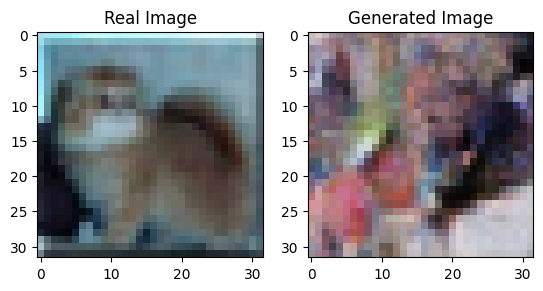

Epoch [129/300], Step [0/157], d_loss: 0.30825769901275635, g_loss: 12.366605758666992
Epoch [129/300], Step [100/157], d_loss: 0.1164293885231018, g_loss: 11.300214767456055


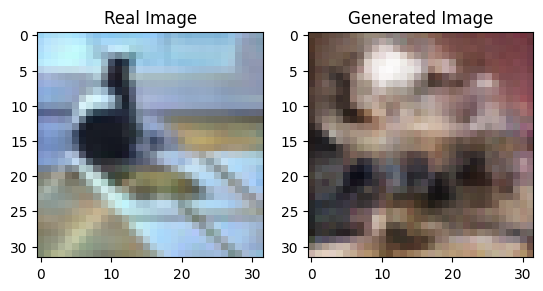

Epoch [130/300], Step [0/157], d_loss: 0.029204674065113068, g_loss: 10.744973182678223
Epoch [130/300], Step [100/157], d_loss: 0.07930026203393936, g_loss: 10.32790756225586


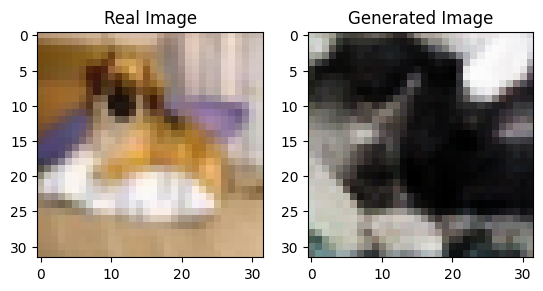

Epoch [131/300], Step [0/157], d_loss: 0.06861591339111328, g_loss: 13.667999267578125
Epoch [131/300], Step [100/157], d_loss: 0.06221863627433777, g_loss: 9.943818092346191


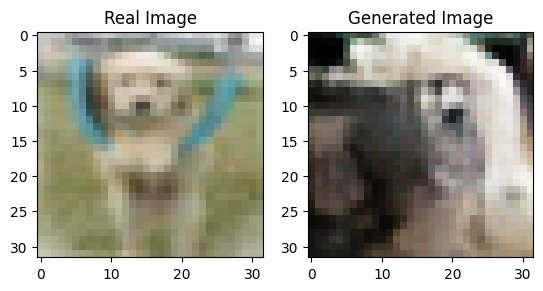

Epoch [132/300], Step [0/157], d_loss: 0.10063169151544571, g_loss: 23.80996322631836
Epoch [132/300], Step [100/157], d_loss: 0.009381082840263844, g_loss: 12.848275184631348


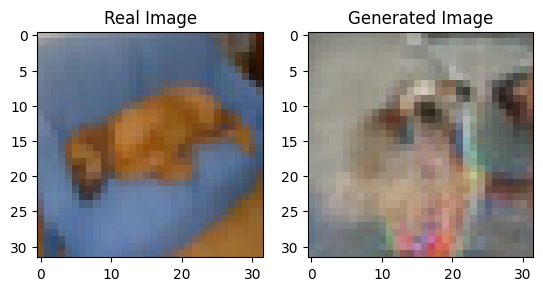

Epoch [133/300], Step [0/157], d_loss: 0.006548495497554541, g_loss: 16.249574661254883
Epoch [133/300], Step [100/157], d_loss: 0.011983862146735191, g_loss: 14.365219116210938


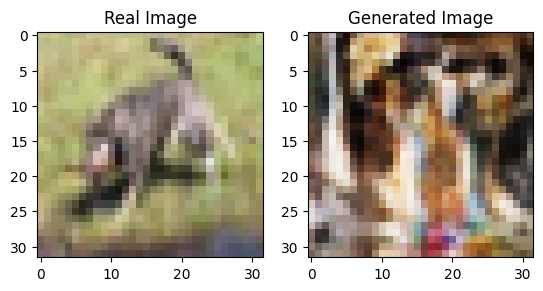

Epoch [134/300], Step [0/157], d_loss: 0.011591239832341671, g_loss: 16.936111450195312
Epoch [134/300], Step [100/157], d_loss: 0.004101461265236139, g_loss: 13.91234016418457


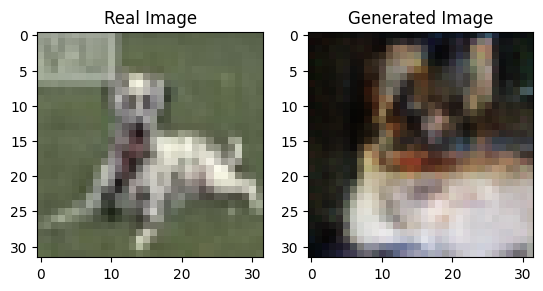

Epoch [135/300], Step [0/157], d_loss: 0.03021175041794777, g_loss: 16.471385955810547
Epoch [135/300], Step [100/157], d_loss: 0.03957962244749069, g_loss: 25.28013801574707


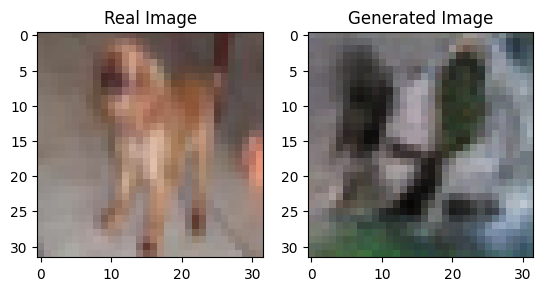

Epoch [136/300], Step [0/157], d_loss: 0.0017530735349282622, g_loss: 17.628719329833984
Epoch [136/300], Step [100/157], d_loss: 0.1304788887500763, g_loss: 18.551435470581055


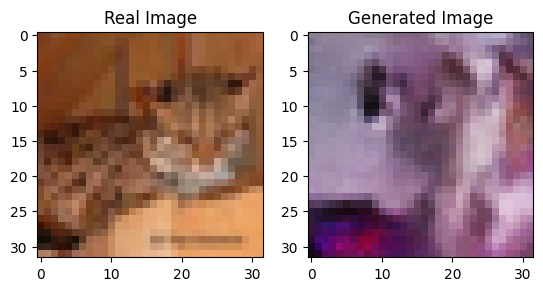

Epoch [137/300], Step [0/157], d_loss: 0.38391178846359253, g_loss: 20.434364318847656
Epoch [137/300], Step [100/157], d_loss: 0.04666696861386299, g_loss: 20.154277801513672


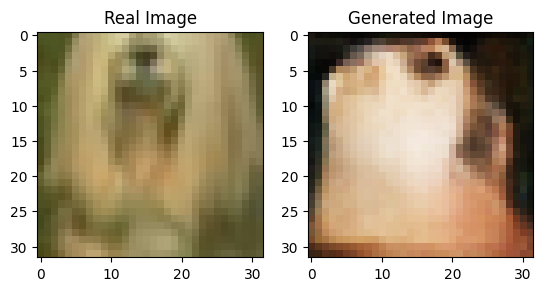

Epoch [138/300], Step [0/157], d_loss: 0.0033903641160577536, g_loss: 12.970236778259277
Epoch [138/300], Step [100/157], d_loss: 0.0025410030502825975, g_loss: 21.670372009277344


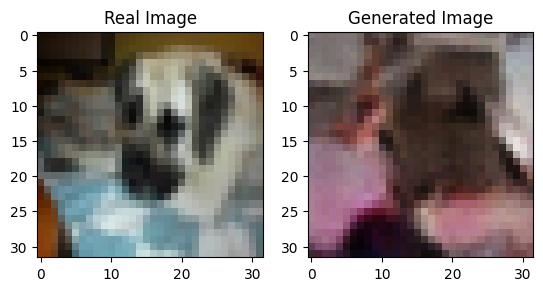

Epoch [139/300], Step [0/157], d_loss: 2.316697359085083, g_loss: 12.168139457702637
Epoch [139/300], Step [100/157], d_loss: 0.12356305122375488, g_loss: 10.831068992614746


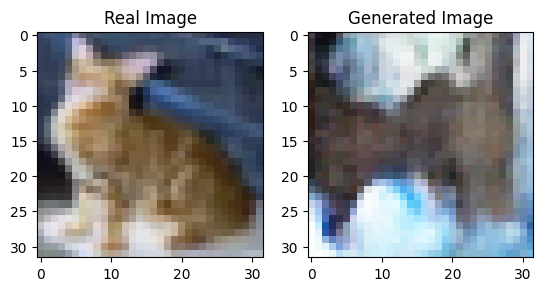

Epoch [140/300], Step [0/157], d_loss: 0.2241360992193222, g_loss: 9.934738159179688
Epoch [140/300], Step [100/157], d_loss: 0.07181791961193085, g_loss: 10.48652458190918


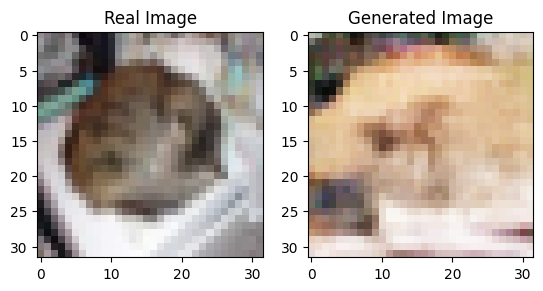

Epoch [141/300], Step [0/157], d_loss: 0.04106355831027031, g_loss: 10.012596130371094
Epoch [141/300], Step [100/157], d_loss: 0.0029681117739528418, g_loss: 22.199161529541016


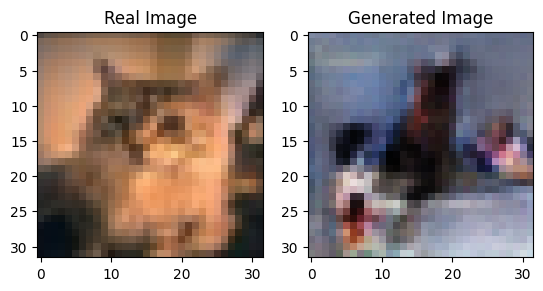

Epoch [142/300], Step [0/157], d_loss: 0.10530658066272736, g_loss: 15.05096435546875
Epoch [142/300], Step [100/157], d_loss: 0.03369200974702835, g_loss: 10.441415786743164


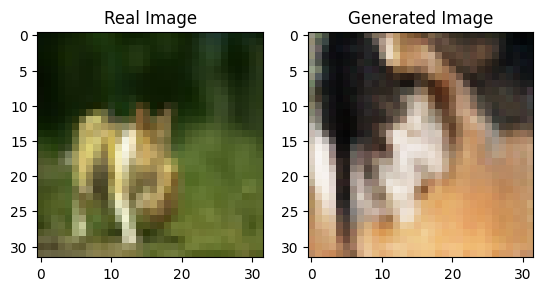

Epoch [143/300], Step [0/157], d_loss: 0.005655460990965366, g_loss: 14.067832946777344
Epoch [143/300], Step [100/157], d_loss: 0.0933031439781189, g_loss: 11.971914291381836


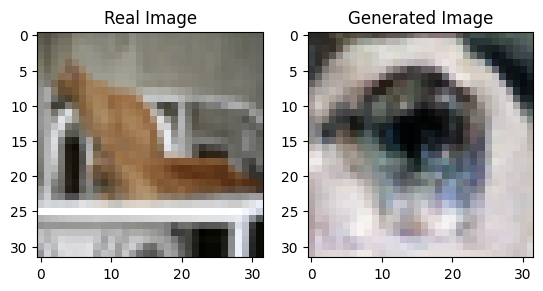

Epoch [144/300], Step [0/157], d_loss: 0.014636638574302197, g_loss: 10.635229110717773
Epoch [144/300], Step [100/157], d_loss: 0.006138667464256287, g_loss: 22.031835556030273


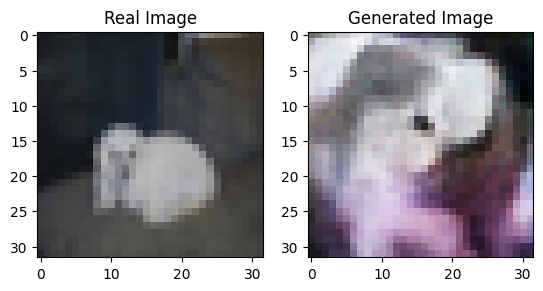

Epoch [145/300], Step [0/157], d_loss: 0.40903112292289734, g_loss: 20.308551788330078
Epoch [145/300], Step [100/157], d_loss: 0.0025252148043364286, g_loss: 19.051666259765625


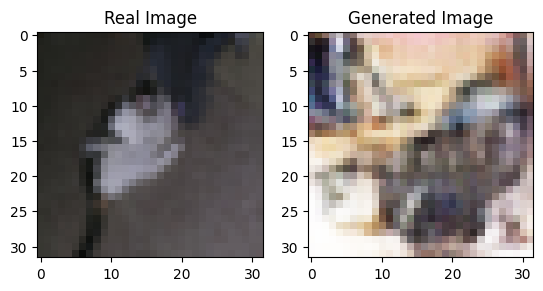

Epoch [146/300], Step [0/157], d_loss: 0.0024475627578794956, g_loss: 21.58422088623047
Epoch [146/300], Step [100/157], d_loss: 0.23832200467586517, g_loss: 17.693519592285156


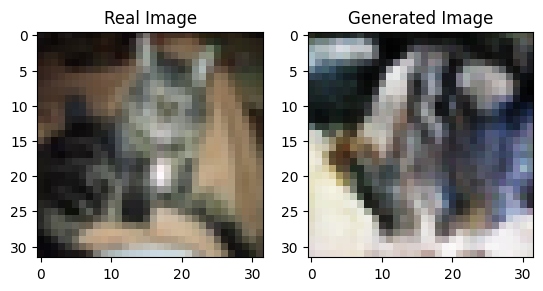

Epoch [147/300], Step [0/157], d_loss: 0.04433414340019226, g_loss: 12.207437515258789
Epoch [147/300], Step [100/157], d_loss: 0.05906778573989868, g_loss: 13.67599105834961


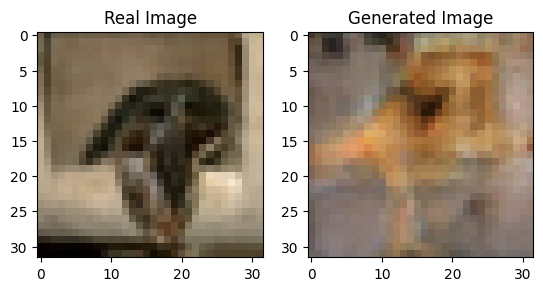

Epoch [148/300], Step [0/157], d_loss: 0.021700477227568626, g_loss: 21.19784164428711
Epoch [148/300], Step [100/157], d_loss: 0.006046399474143982, g_loss: 17.578678131103516


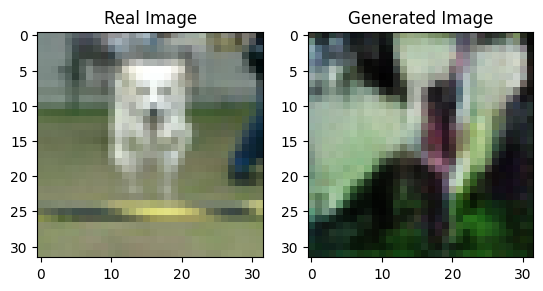

Epoch [149/300], Step [0/157], d_loss: 0.09372775256633759, g_loss: 14.882781028747559
Epoch [149/300], Step [100/157], d_loss: 0.1481008678674698, g_loss: 18.007915496826172


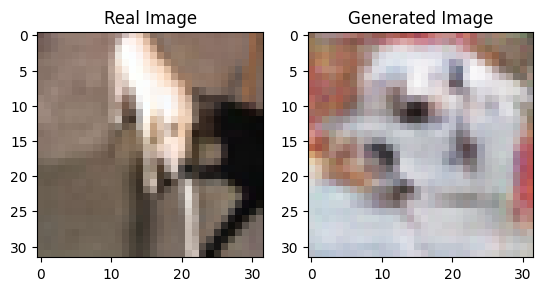

Epoch [150/300], Step [0/157], d_loss: 0.004685709252953529, g_loss: 17.70946502685547
Epoch [150/300], Step [100/157], d_loss: 0.02334485948085785, g_loss: 18.443939208984375


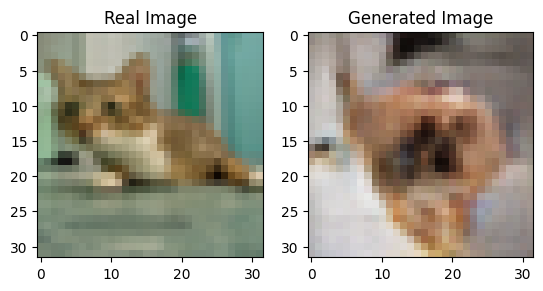

Epoch [151/300], Step [0/157], d_loss: 0.17020034790039062, g_loss: 23.4036865234375
Epoch [151/300], Step [100/157], d_loss: 0.022126568481326103, g_loss: 17.375452041625977


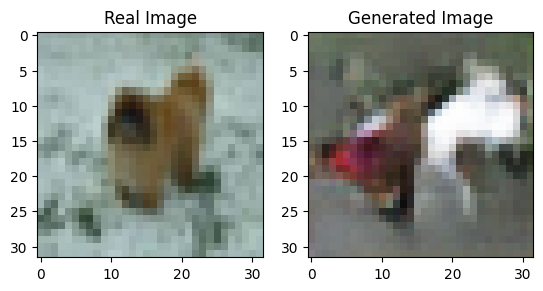

Epoch [152/300], Step [0/157], d_loss: 0.004288484808057547, g_loss: 15.529752731323242
Epoch [152/300], Step [100/157], d_loss: 0.037506263703107834, g_loss: 20.701425552368164


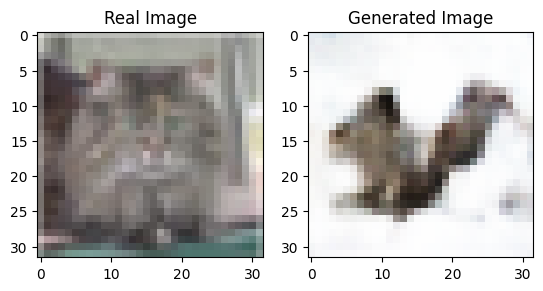

Epoch [153/300], Step [0/157], d_loss: 0.0055360738188028336, g_loss: 14.817414283752441
Epoch [153/300], Step [100/157], d_loss: 0.029661934822797775, g_loss: 18.954689025878906


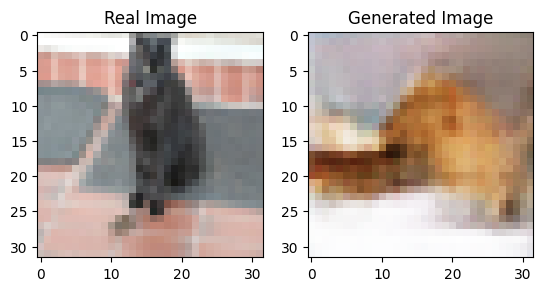

Epoch [154/300], Step [0/157], d_loss: 0.004869448021054268, g_loss: 12.989995002746582
Epoch [154/300], Step [100/157], d_loss: 0.5850086808204651, g_loss: 32.3856201171875


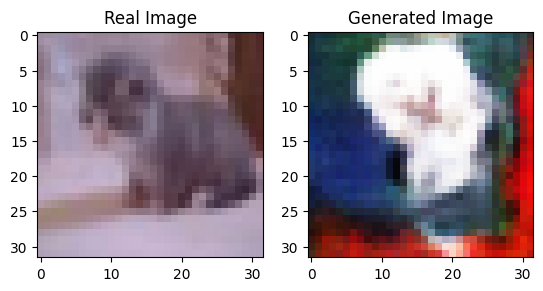

Epoch [155/300], Step [0/157], d_loss: 0.003977392800152302, g_loss: 22.59225845336914
Epoch [155/300], Step [100/157], d_loss: 0.003134804777801037, g_loss: 22.186756134033203


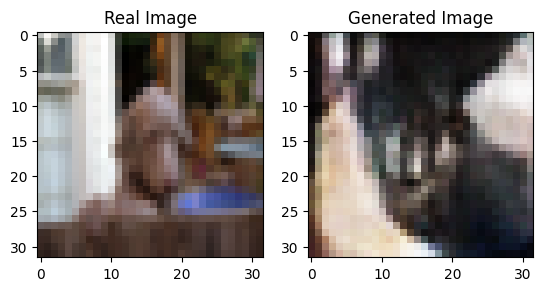

Epoch [156/300], Step [0/157], d_loss: 0.04348020255565643, g_loss: 35.434898376464844
Epoch [156/300], Step [100/157], d_loss: 0.1123720034956932, g_loss: 9.347803115844727


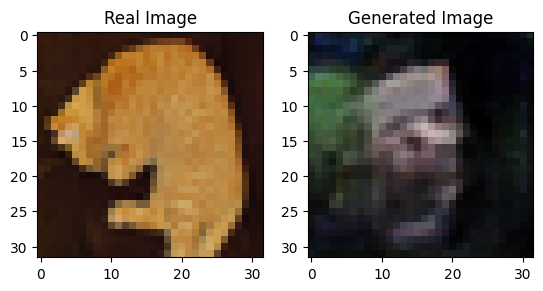

Epoch [157/300], Step [0/157], d_loss: 0.05651199817657471, g_loss: 25.89269256591797
Epoch [157/300], Step [100/157], d_loss: 0.012229178100824356, g_loss: 12.82912826538086


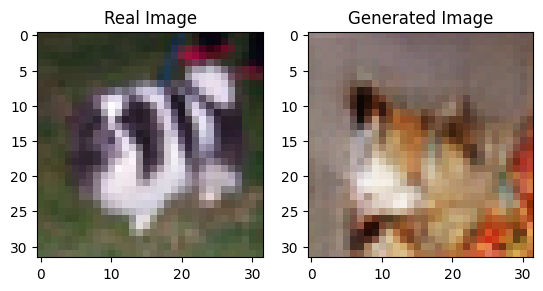

Epoch [158/300], Step [0/157], d_loss: 0.05234392359852791, g_loss: 16.936569213867188
Epoch [158/300], Step [100/157], d_loss: 0.03537150099873543, g_loss: 16.315397262573242


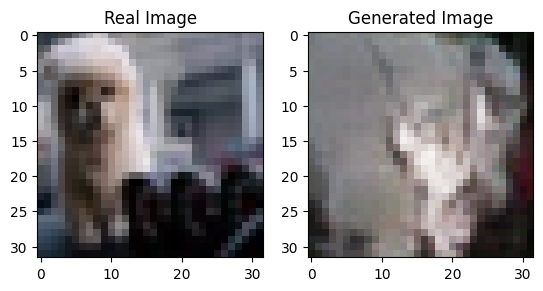

Epoch [159/300], Step [0/157], d_loss: 0.024565277621150017, g_loss: 13.179159164428711
Epoch [159/300], Step [100/157], d_loss: 0.05343560874462128, g_loss: 11.576955795288086


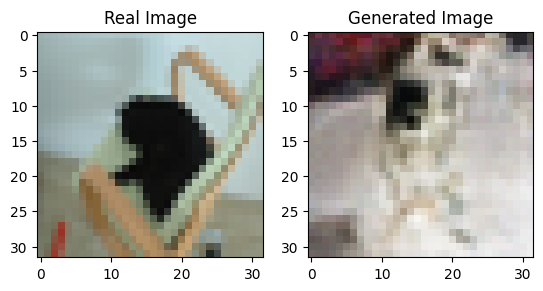

Epoch [160/300], Step [0/157], d_loss: 0.02016913890838623, g_loss: 19.835054397583008
Epoch [160/300], Step [100/157], d_loss: 0.005359831731766462, g_loss: 24.559343338012695


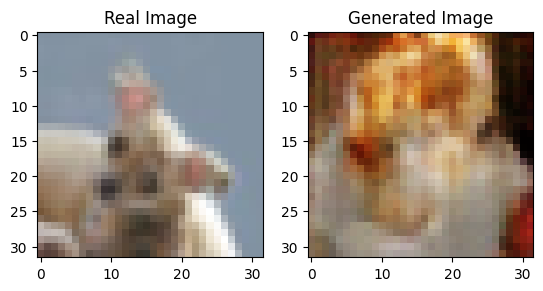

Epoch [161/300], Step [0/157], d_loss: 0.014339873567223549, g_loss: 17.372493743896484
Epoch [161/300], Step [100/157], d_loss: 0.010513675399124622, g_loss: 13.019511222839355


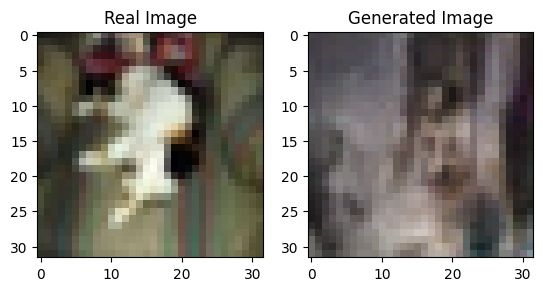

Epoch [162/300], Step [0/157], d_loss: 0.26178622245788574, g_loss: 25.101852416992188
Epoch [162/300], Step [100/157], d_loss: 0.1210050955414772, g_loss: 29.647586822509766


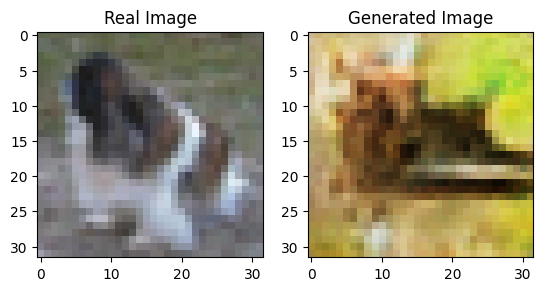

Epoch [163/300], Step [0/157], d_loss: 0.14056901633739471, g_loss: 13.995172500610352
Epoch [163/300], Step [100/157], d_loss: 0.016237203031778336, g_loss: 13.998115539550781


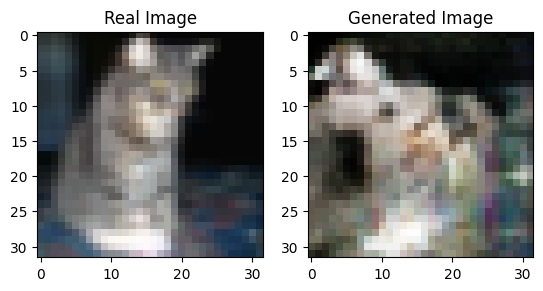

Epoch [164/300], Step [0/157], d_loss: 0.015435890294611454, g_loss: 17.449626922607422
Epoch [164/300], Step [100/157], d_loss: 0.017924446612596512, g_loss: 21.58811378479004


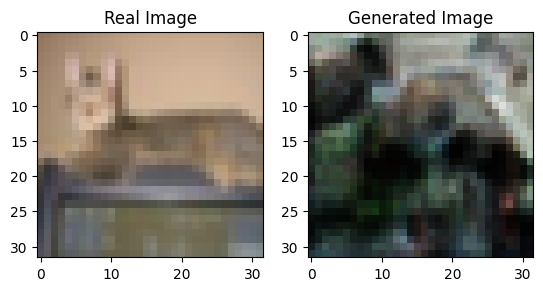

Epoch [165/300], Step [0/157], d_loss: 0.01078450120985508, g_loss: 18.148555755615234
Epoch [165/300], Step [100/157], d_loss: 0.04169546440243721, g_loss: 12.814449310302734


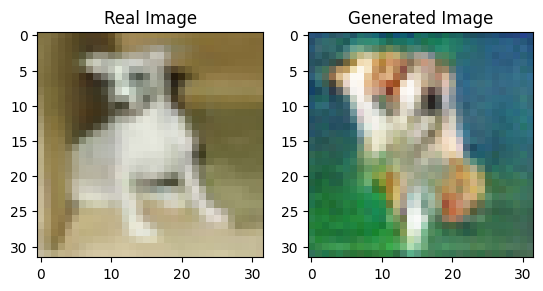

Epoch [166/300], Step [0/157], d_loss: 0.8510230779647827, g_loss: 43.191951751708984
Epoch [166/300], Step [100/157], d_loss: 0.1493728756904602, g_loss: 13.264857292175293


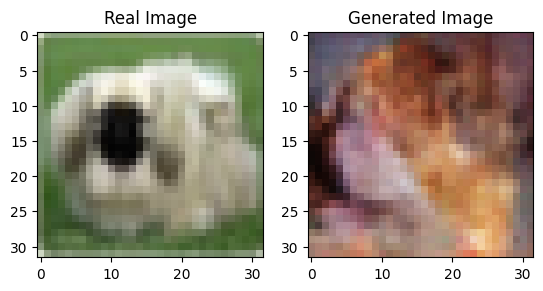

Epoch [167/300], Step [0/157], d_loss: 0.010683451779186726, g_loss: 11.82042407989502
Epoch [167/300], Step [100/157], d_loss: 0.023692917078733444, g_loss: 14.313552856445312


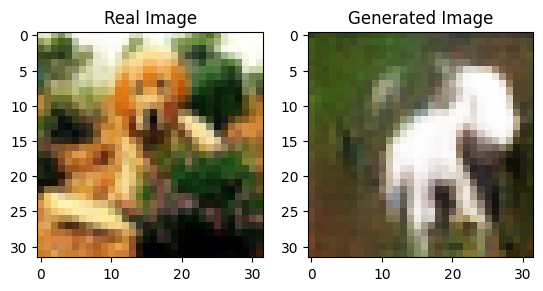

Epoch [168/300], Step [0/157], d_loss: 0.011365453712642193, g_loss: 20.685298919677734
Epoch [168/300], Step [100/157], d_loss: 0.027453850954771042, g_loss: 11.070755004882812


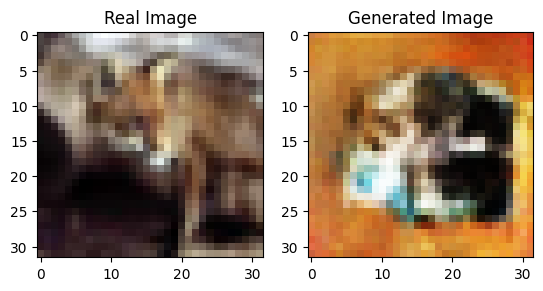

Epoch [169/300], Step [0/157], d_loss: 0.022757992148399353, g_loss: 11.625446319580078
Epoch [169/300], Step [100/157], d_loss: 0.006967099383473396, g_loss: 22.189109802246094


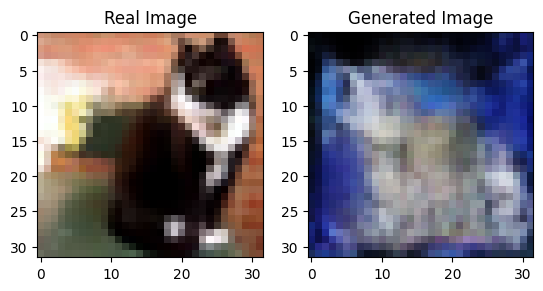

Epoch [170/300], Step [0/157], d_loss: 0.003878680057823658, g_loss: 18.102386474609375
Epoch [170/300], Step [100/157], d_loss: 0.04909675195813179, g_loss: 16.44161605834961


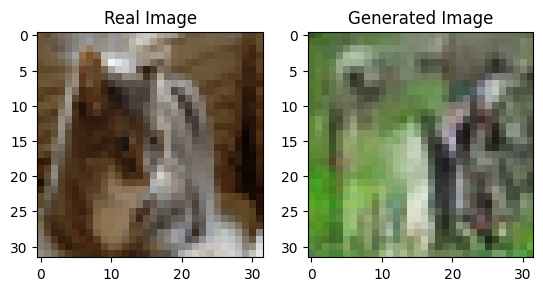

Epoch [171/300], Step [0/157], d_loss: 0.0008342589135281742, g_loss: 22.113094329833984
Epoch [171/300], Step [100/157], d_loss: 0.1525236815214157, g_loss: 18.4682559967041


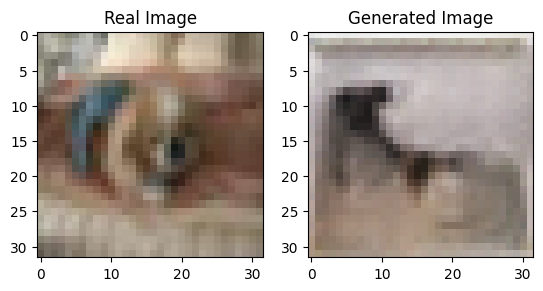

Epoch [172/300], Step [0/157], d_loss: 0.004818207584321499, g_loss: 19.229080200195312
Epoch [172/300], Step [100/157], d_loss: 0.0036534226965159178, g_loss: 23.08672332763672


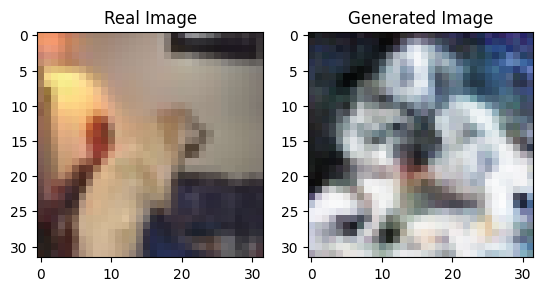

Epoch [173/300], Step [0/157], d_loss: 0.0030446937307715416, g_loss: 16.95965576171875
Epoch [173/300], Step [100/157], d_loss: 0.027111869305372238, g_loss: 12.406189918518066


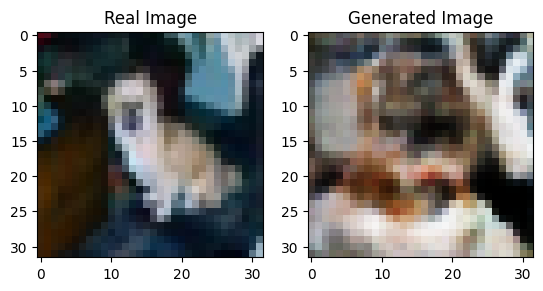

Epoch [174/300], Step [0/157], d_loss: 0.10314547270536423, g_loss: 13.17828369140625
Epoch [174/300], Step [100/157], d_loss: 4.966193675994873, g_loss: 51.135887145996094


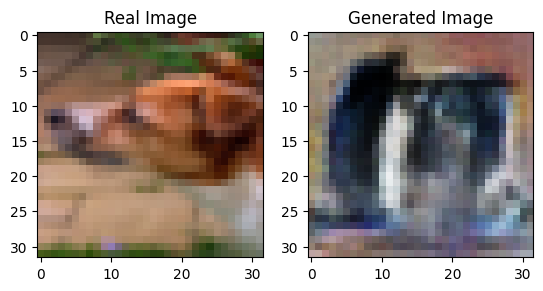

Epoch [175/300], Step [0/157], d_loss: 0.09019854664802551, g_loss: 13.047468185424805
Epoch [175/300], Step [100/157], d_loss: 0.21945327520370483, g_loss: 21.933481216430664


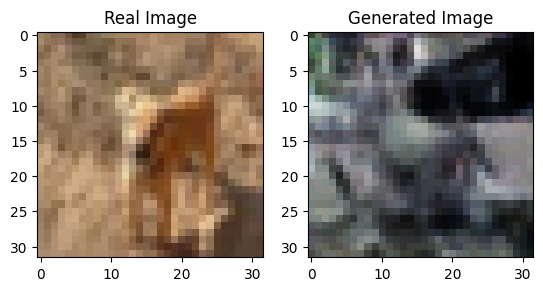

Epoch [176/300], Step [0/157], d_loss: 0.22463184595108032, g_loss: 15.693769454956055
Epoch [176/300], Step [100/157], d_loss: 0.010584907606244087, g_loss: 16.089725494384766


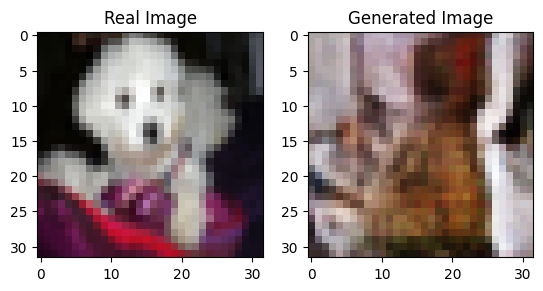

Epoch [177/300], Step [0/157], d_loss: 0.06668639183044434, g_loss: 13.623190879821777
Epoch [177/300], Step [100/157], d_loss: 0.07760974764823914, g_loss: 12.199951171875


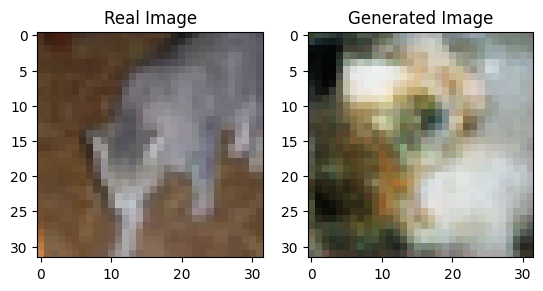

Epoch [178/300], Step [0/157], d_loss: 0.051273785531520844, g_loss: 13.772777557373047
Epoch [178/300], Step [100/157], d_loss: 0.01500718854367733, g_loss: 21.368247985839844


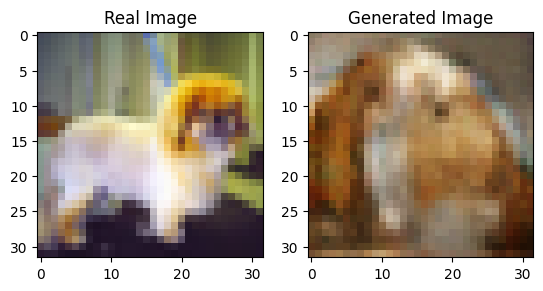

Epoch [179/300], Step [0/157], d_loss: 0.11375634372234344, g_loss: 12.423059463500977
Epoch [179/300], Step [100/157], d_loss: 0.008100229315459728, g_loss: 14.82590103149414


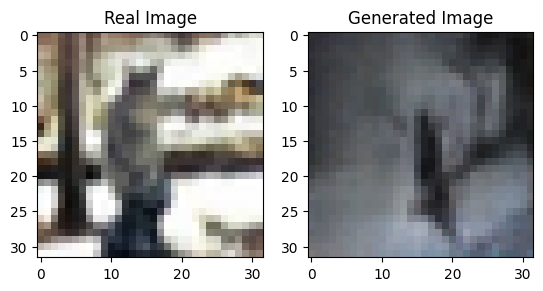

Epoch [180/300], Step [0/157], d_loss: 0.004719497170299292, g_loss: 17.86077308654785
Epoch [180/300], Step [100/157], d_loss: 0.01900692656636238, g_loss: 18.158063888549805


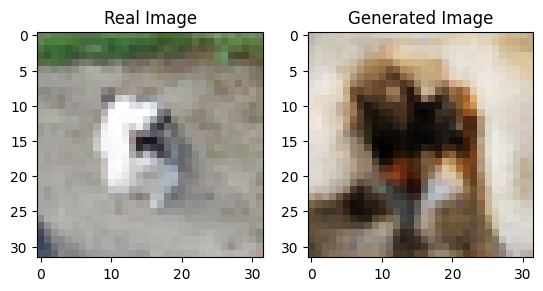

Epoch [181/300], Step [0/157], d_loss: 0.006251964718103409, g_loss: 28.114107131958008
Epoch [181/300], Step [100/157], d_loss: 0.008731028996407986, g_loss: 22.044414520263672


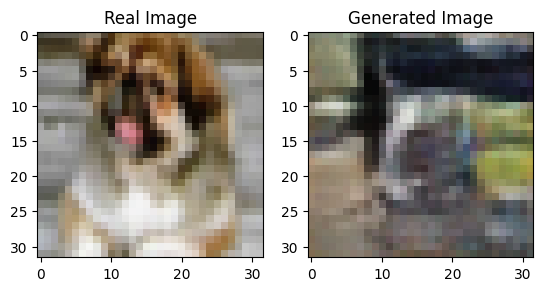

Epoch [182/300], Step [0/157], d_loss: 0.05633468180894852, g_loss: 12.653176307678223
Epoch [182/300], Step [100/157], d_loss: 0.04891740530729294, g_loss: 12.310341835021973


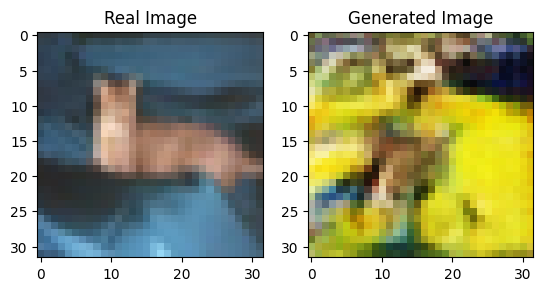

Epoch [183/300], Step [0/157], d_loss: 0.003170178970322013, g_loss: 26.354175567626953
Epoch [183/300], Step [100/157], d_loss: 0.9508178234100342, g_loss: 37.67636489868164


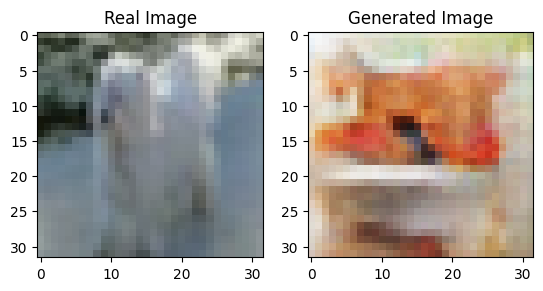

Epoch [184/300], Step [0/157], d_loss: 0.016189303249120712, g_loss: 11.55046558380127
Epoch [184/300], Step [100/157], d_loss: 0.006251464132219553, g_loss: 18.124380111694336


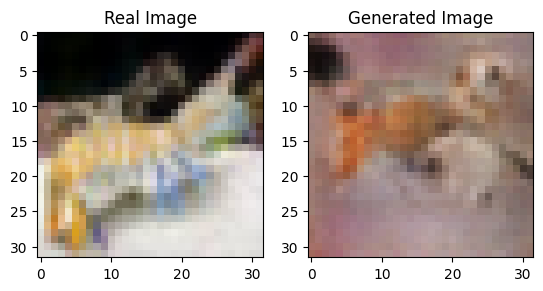

Epoch [185/300], Step [0/157], d_loss: 0.010373083874583244, g_loss: 32.704925537109375
Epoch [185/300], Step [100/157], d_loss: 0.03581114113330841, g_loss: 23.397920608520508


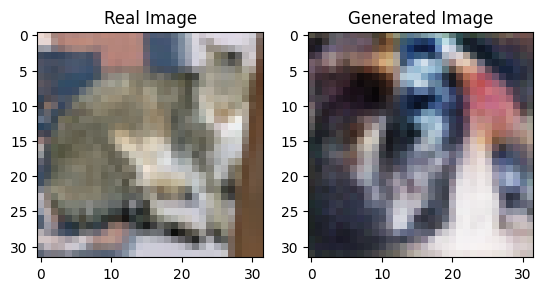

Epoch [186/300], Step [0/157], d_loss: 0.03772246092557907, g_loss: 21.115741729736328
Epoch [186/300], Step [100/157], d_loss: 0.05012829974293709, g_loss: 31.494598388671875


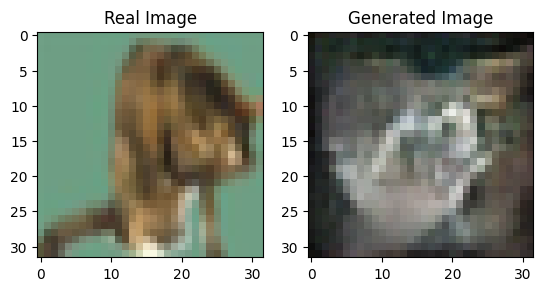

Epoch [187/300], Step [0/157], d_loss: 0.003338597947731614, g_loss: 22.63778305053711
Epoch [187/300], Step [100/157], d_loss: 0.009274709969758987, g_loss: 18.46887969970703


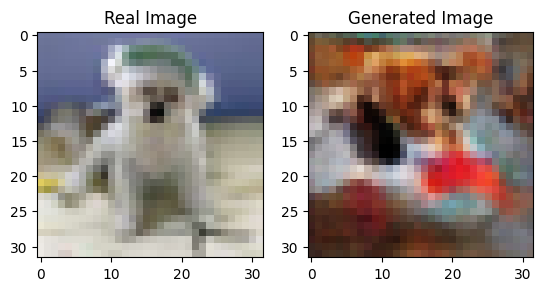

Epoch [188/300], Step [0/157], d_loss: 0.060367800295352936, g_loss: 13.118776321411133
Epoch [188/300], Step [100/157], d_loss: 0.010773304849863052, g_loss: 18.05836296081543


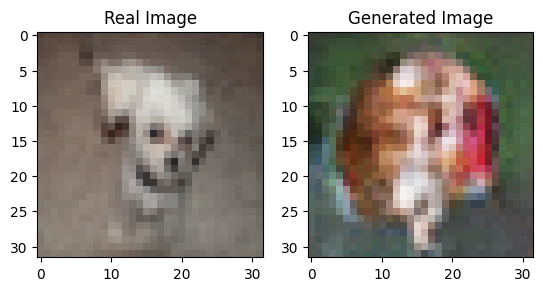

Epoch [189/300], Step [0/157], d_loss: 0.0032463883981108665, g_loss: 22.274385452270508
Epoch [189/300], Step [100/157], d_loss: 0.026558768004179, g_loss: 16.011566162109375


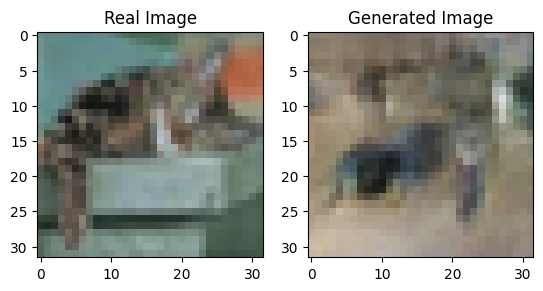

Epoch [190/300], Step [0/157], d_loss: 0.005217966623604298, g_loss: 18.717086791992188
Epoch [190/300], Step [100/157], d_loss: 0.06455033272504807, g_loss: 13.76374626159668


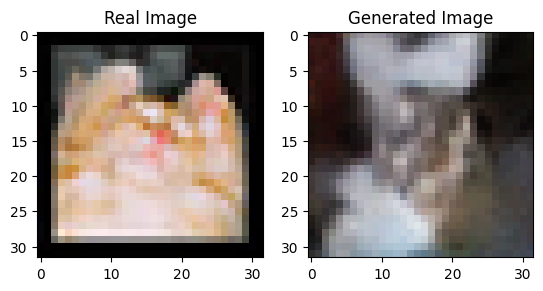

Epoch [191/300], Step [0/157], d_loss: 0.008334743790328503, g_loss: 16.52391815185547
Epoch [191/300], Step [100/157], d_loss: 0.08767656981945038, g_loss: 41.85129928588867


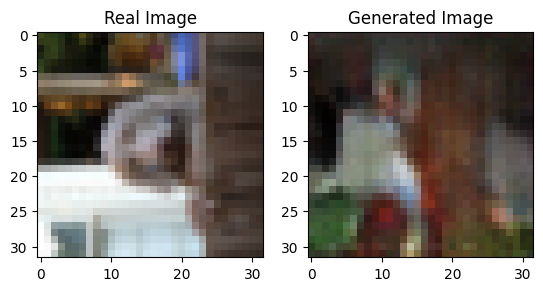

Epoch [192/300], Step [0/157], d_loss: 0.32673388719558716, g_loss: 9.551872253417969
Epoch [192/300], Step [100/157], d_loss: 0.036163706332445145, g_loss: 15.889874458312988


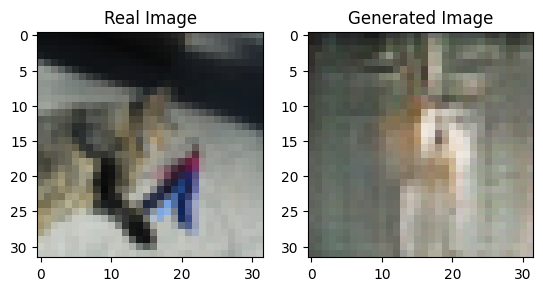

Epoch [193/300], Step [0/157], d_loss: 0.9209444522857666, g_loss: 17.016504287719727
Epoch [193/300], Step [100/157], d_loss: 0.00791093334555626, g_loss: 12.505302429199219


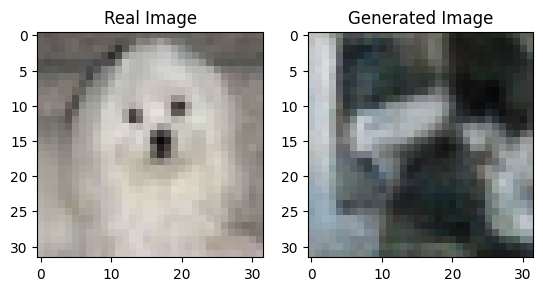

Epoch [194/300], Step [0/157], d_loss: 0.030846472829580307, g_loss: 11.700630187988281
Epoch [194/300], Step [100/157], d_loss: 0.025237007066607475, g_loss: 11.731761932373047


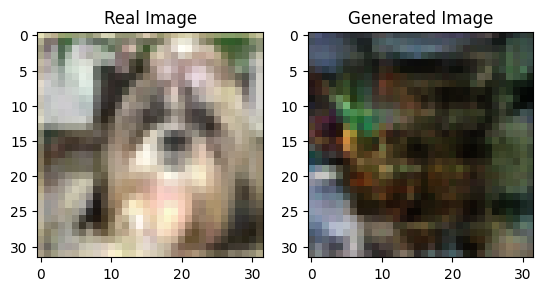

Epoch [195/300], Step [0/157], d_loss: 0.014655064791440964, g_loss: 33.734344482421875
Epoch [195/300], Step [100/157], d_loss: 0.1992122381925583, g_loss: 18.659475326538086


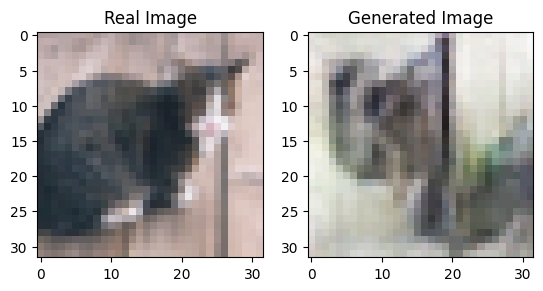

Epoch [196/300], Step [0/157], d_loss: 0.09294459223747253, g_loss: 12.419063568115234
Epoch [196/300], Step [100/157], d_loss: 0.016304077580571175, g_loss: 22.564411163330078


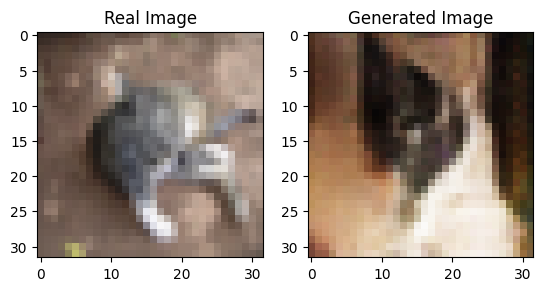

Epoch [197/300], Step [0/157], d_loss: 0.0034689356107264757, g_loss: 16.961109161376953
Epoch [197/300], Step [100/157], d_loss: 0.004468927159905434, g_loss: 26.48575210571289


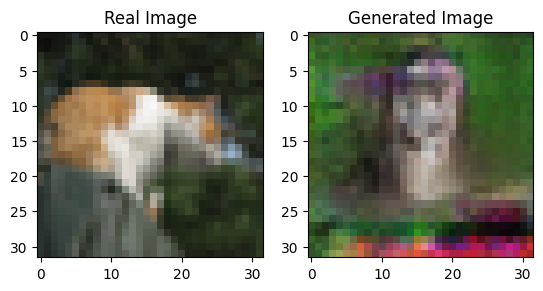

Epoch [198/300], Step [0/157], d_loss: 0.0024019626434892416, g_loss: 23.332622528076172
Epoch [198/300], Step [100/157], d_loss: 0.0019937600009143353, g_loss: 21.854156494140625


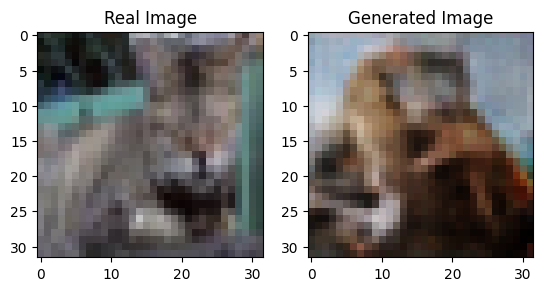

Epoch [199/300], Step [0/157], d_loss: 0.007308400236070156, g_loss: 15.088854789733887
Epoch [199/300], Step [100/157], d_loss: 0.0019156732596457005, g_loss: 19.832387924194336


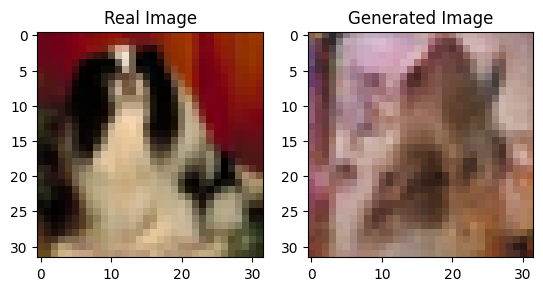

Epoch [200/300], Step [0/157], d_loss: 0.0010651596821844578, g_loss: 46.39942169189453
Epoch [200/300], Step [100/157], d_loss: 0.0035313069820404053, g_loss: 21.41143798828125


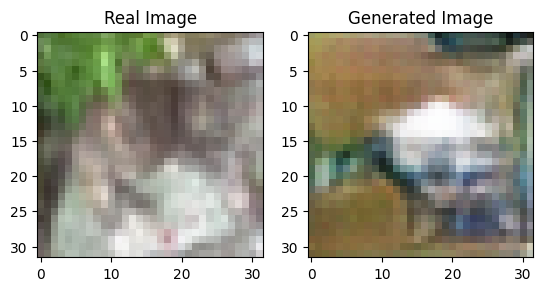

Epoch [201/300], Step [0/157], d_loss: 0.015415659174323082, g_loss: 28.8614501953125
Epoch [201/300], Step [100/157], d_loss: 0.0041766176000237465, g_loss: 21.96179962158203


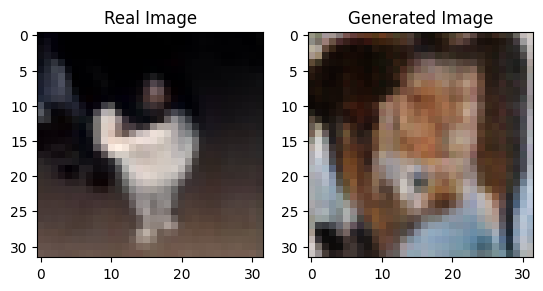

Epoch [202/300], Step [0/157], d_loss: 0.007780034095048904, g_loss: 27.186786651611328
Epoch [202/300], Step [100/157], d_loss: 0.0036978875286877155, g_loss: 29.7095947265625


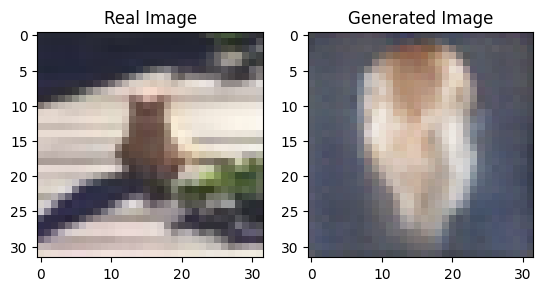

Epoch [203/300], Step [0/157], d_loss: 0.006897220853716135, g_loss: 24.726600646972656
Epoch [203/300], Step [100/157], d_loss: 0.013089284300804138, g_loss: 18.161489486694336


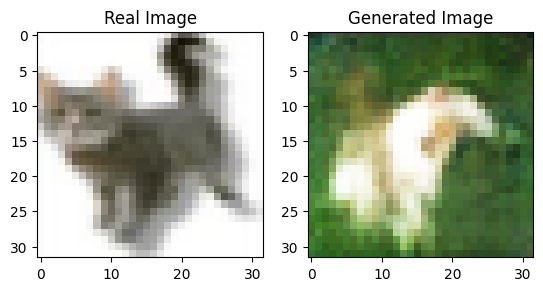

Epoch [204/300], Step [0/157], d_loss: 0.003300592303276062, g_loss: 35.69939422607422
Epoch [204/300], Step [100/157], d_loss: 0.003348075784742832, g_loss: 23.900463104248047


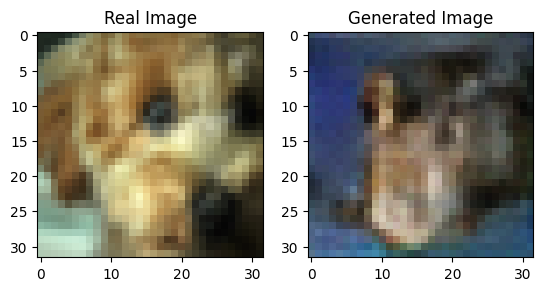

Epoch [205/300], Step [0/157], d_loss: 0.11406642943620682, g_loss: 15.683012962341309
Epoch [205/300], Step [100/157], d_loss: 0.015277871862053871, g_loss: 16.270038604736328


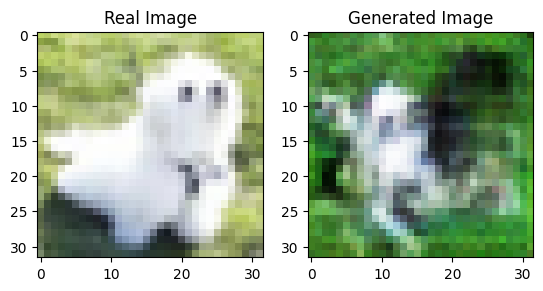

Epoch [206/300], Step [0/157], d_loss: 0.004703508224338293, g_loss: 19.043949127197266
Epoch [206/300], Step [100/157], d_loss: 0.007304267026484013, g_loss: 21.15241813659668


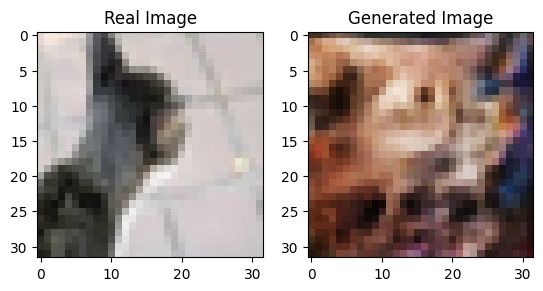

Epoch [207/300], Step [0/157], d_loss: 0.004088548943400383, g_loss: 25.18379020690918
Epoch [207/300], Step [100/157], d_loss: 0.0364389568567276, g_loss: 28.633174896240234


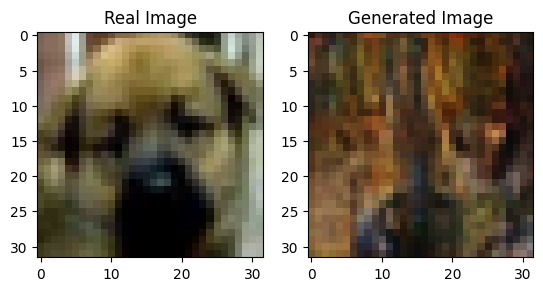

Epoch [208/300], Step [0/157], d_loss: 0.004395562224090099, g_loss: 23.326683044433594
Epoch [208/300], Step [100/157], d_loss: 0.024123545736074448, g_loss: 17.574871063232422


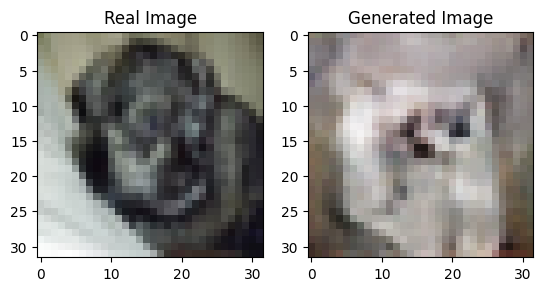

Epoch [209/300], Step [0/157], d_loss: 0.008601488545536995, g_loss: 13.962545394897461
Epoch [209/300], Step [100/157], d_loss: 0.11022103577852249, g_loss: 13.886292457580566


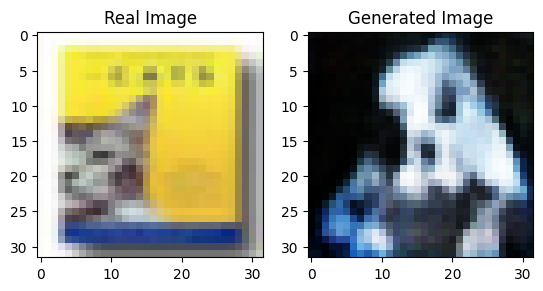

Epoch [210/300], Step [0/157], d_loss: 0.004852794110774994, g_loss: 21.355634689331055
Epoch [210/300], Step [100/157], d_loss: 0.0029272043611854315, g_loss: 21.537763595581055


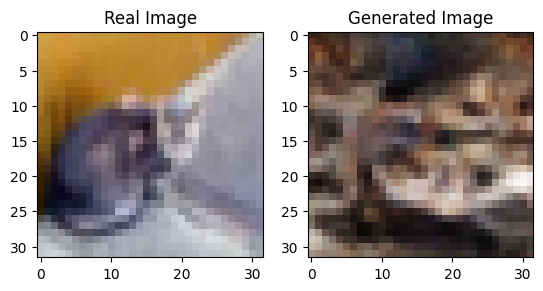

Epoch [211/300], Step [0/157], d_loss: 0.0036079881247133017, g_loss: 23.385700225830078
Epoch [211/300], Step [100/157], d_loss: 0.0015696618938818574, g_loss: 34.061492919921875


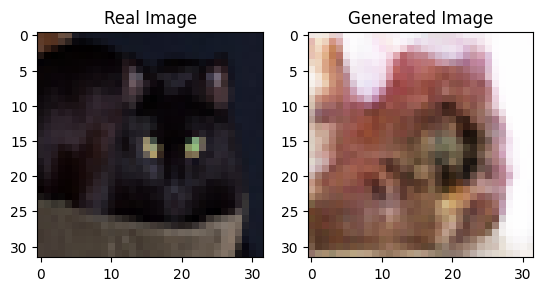

Epoch [212/300], Step [0/157], d_loss: 0.01820599101483822, g_loss: 27.136856079101562
Epoch [212/300], Step [100/157], d_loss: 0.5479589700698853, g_loss: 34.8411865234375


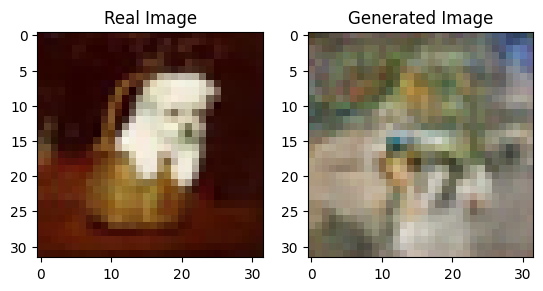

Epoch [213/300], Step [0/157], d_loss: 0.011646251194179058, g_loss: 27.18224334716797
Epoch [213/300], Step [100/157], d_loss: 0.056809209287166595, g_loss: 22.678730010986328


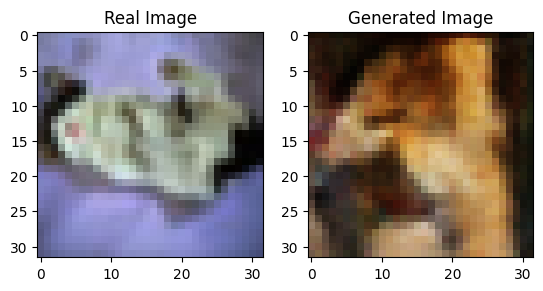

Epoch [214/300], Step [0/157], d_loss: 0.7010448575019836, g_loss: 15.453546524047852
Epoch [214/300], Step [100/157], d_loss: 0.05408234894275665, g_loss: 14.863994598388672


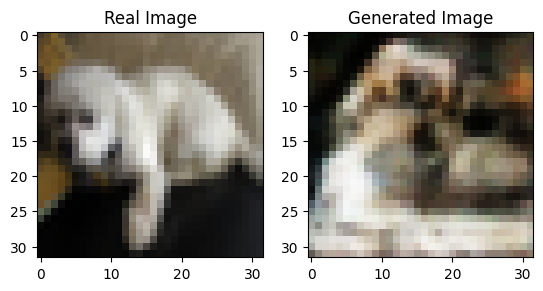

Epoch [215/300], Step [0/157], d_loss: 0.3658657371997833, g_loss: 29.373672485351562
Epoch [215/300], Step [100/157], d_loss: 0.10047672688961029, g_loss: 30.858715057373047


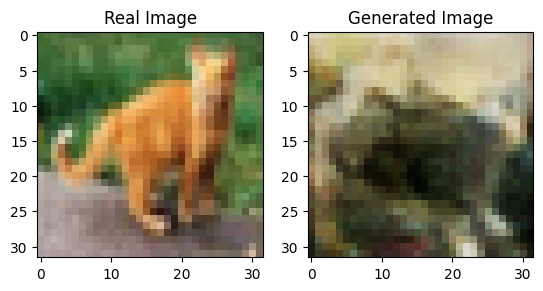

Epoch [216/300], Step [0/157], d_loss: 0.20712991058826447, g_loss: 26.134550094604492
Epoch [216/300], Step [100/157], d_loss: 0.06322842836380005, g_loss: 12.757478713989258


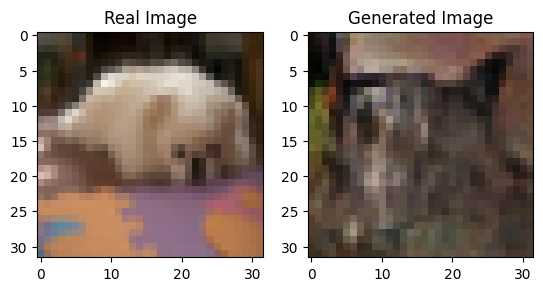

Epoch [217/300], Step [0/157], d_loss: 0.009804234839975834, g_loss: 23.706581115722656
Epoch [217/300], Step [100/157], d_loss: 0.029350075870752335, g_loss: 12.402521133422852


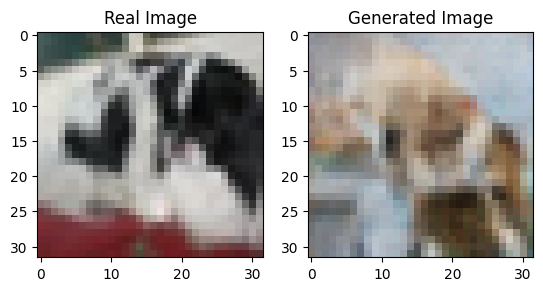

Epoch [218/300], Step [0/157], d_loss: 0.026022374629974365, g_loss: 11.535141944885254
Epoch [218/300], Step [100/157], d_loss: 0.016769973561167717, g_loss: 26.57036590576172


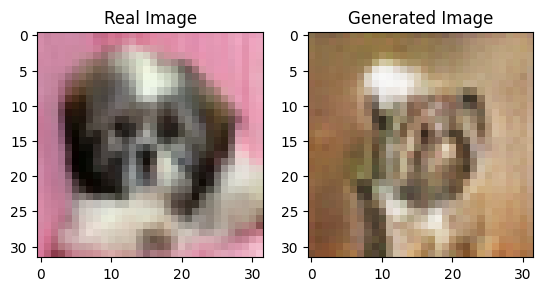

Epoch [219/300], Step [0/157], d_loss: 0.030821356922388077, g_loss: 13.988826751708984
Epoch [219/300], Step [100/157], d_loss: 0.20996904373168945, g_loss: 34.397518157958984


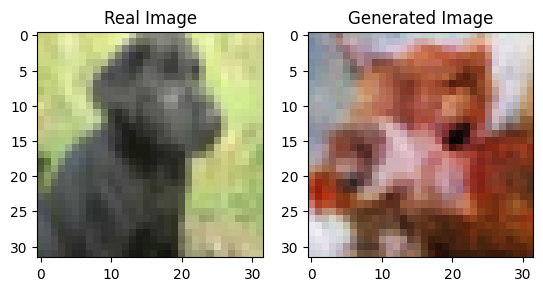

Epoch [220/300], Step [0/157], d_loss: 0.005353800021111965, g_loss: 19.193111419677734
Epoch [220/300], Step [100/157], d_loss: 0.006197222974151373, g_loss: 23.697919845581055


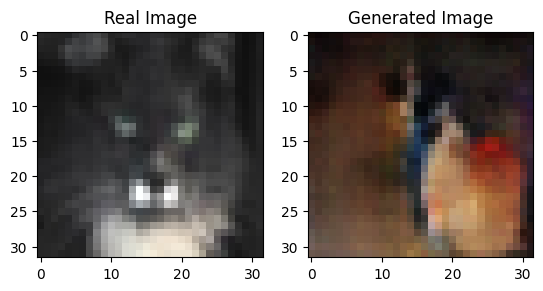

Epoch [221/300], Step [0/157], d_loss: 0.009520372375845909, g_loss: 28.69921875
Epoch [221/300], Step [100/157], d_loss: 0.007195779122412205, g_loss: 15.933943748474121


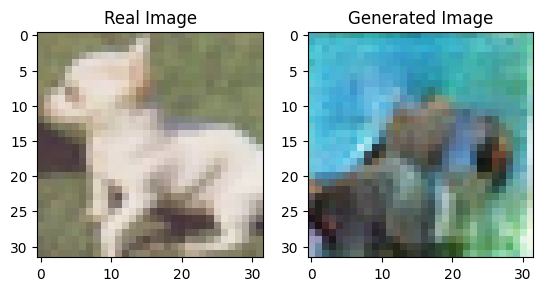

Epoch [222/300], Step [0/157], d_loss: 0.009623462334275246, g_loss: 34.081825256347656
Epoch [222/300], Step [100/157], d_loss: 0.013120830059051514, g_loss: 15.95468521118164


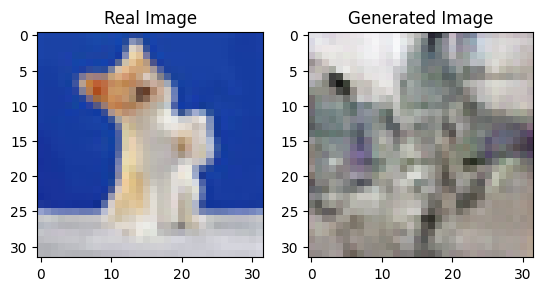

Epoch [223/300], Step [0/157], d_loss: 0.006075488869100809, g_loss: 18.402830123901367
Epoch [223/300], Step [100/157], d_loss: 0.0005742799257859588, g_loss: 27.655841827392578


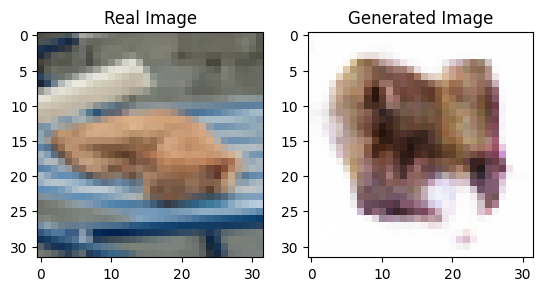

Epoch [224/300], Step [0/157], d_loss: 0.09386075288057327, g_loss: 16.303556442260742
Epoch [224/300], Step [100/157], d_loss: 0.0026042908430099487, g_loss: 16.093536376953125


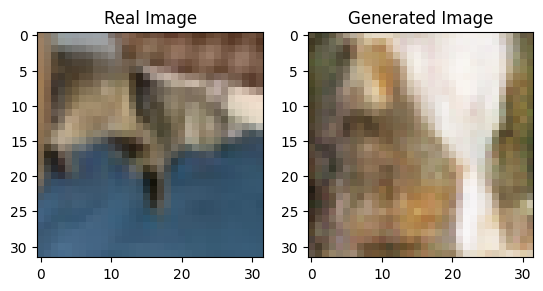

Epoch [225/300], Step [0/157], d_loss: 0.005601748824119568, g_loss: 22.034671783447266
Epoch [225/300], Step [100/157], d_loss: 0.005545441992580891, g_loss: 18.292449951171875


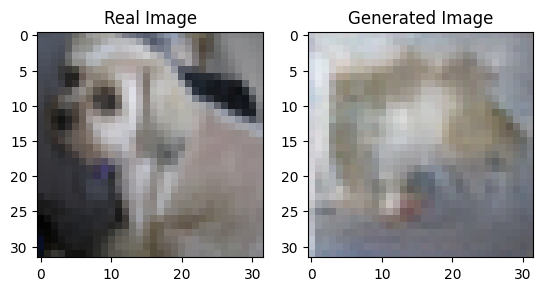

Epoch [226/300], Step [0/157], d_loss: 0.026085343211889267, g_loss: 16.441020965576172
Epoch [226/300], Step [100/157], d_loss: 0.0040054707787930965, g_loss: 28.69624137878418


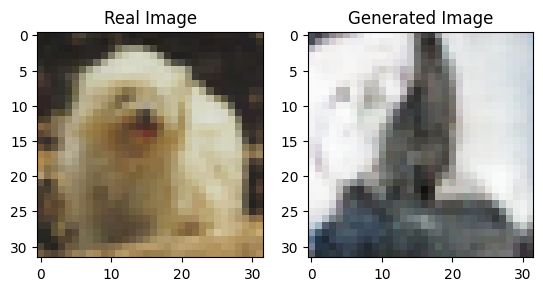

Epoch [227/300], Step [0/157], d_loss: 0.0016371725359931588, g_loss: 17.506088256835938
Epoch [227/300], Step [100/157], d_loss: 0.0039048350881785154, g_loss: 32.308265686035156


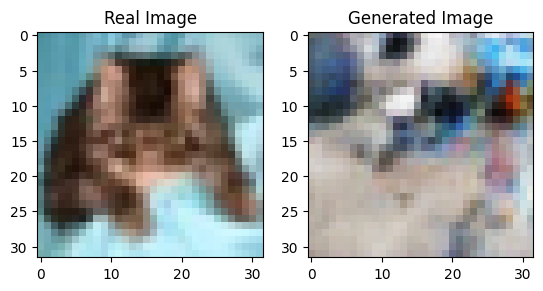

Epoch [228/300], Step [0/157], d_loss: 0.0028859435115009546, g_loss: 21.54341697692871
Epoch [228/300], Step [100/157], d_loss: 0.0074066584929823875, g_loss: 15.30989933013916


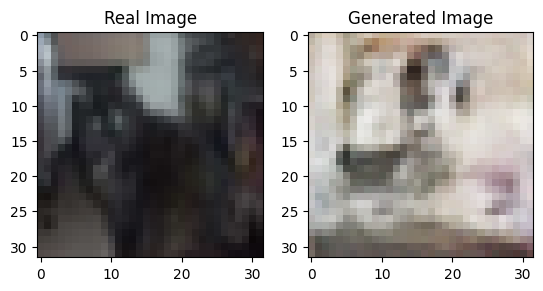

Epoch [229/300], Step [0/157], d_loss: 0.0019235555082559586, g_loss: 16.959087371826172
Epoch [229/300], Step [100/157], d_loss: 0.0024406169541180134, g_loss: 30.429052352905273


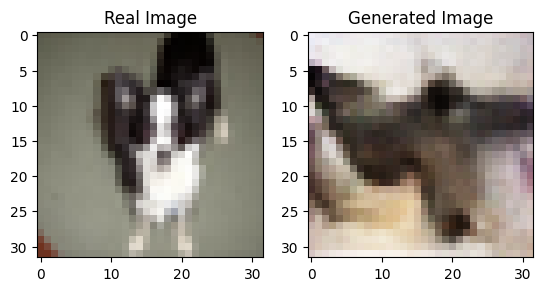

Epoch [230/300], Step [0/157], d_loss: 0.004137933254241943, g_loss: 20.13234519958496
Epoch [230/300], Step [100/157], d_loss: 0.008326942101120949, g_loss: 28.386045455932617


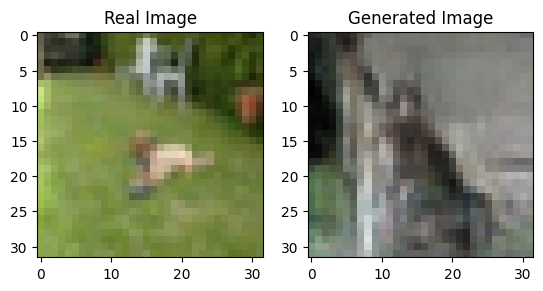

Epoch [231/300], Step [0/157], d_loss: 0.011222891509532928, g_loss: 19.421693801879883
Epoch [231/300], Step [100/157], d_loss: 0.00077160878572613, g_loss: 27.062807083129883


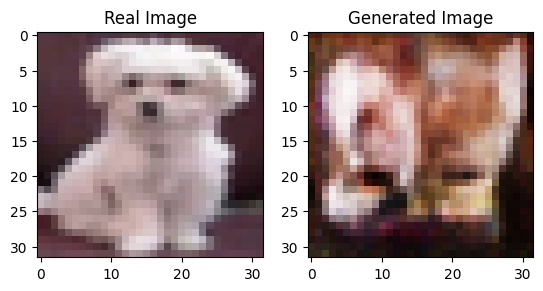

Epoch [232/300], Step [0/157], d_loss: 0.05065380781888962, g_loss: 17.475086212158203
Epoch [232/300], Step [100/157], d_loss: 0.1382426917552948, g_loss: 18.36344337463379


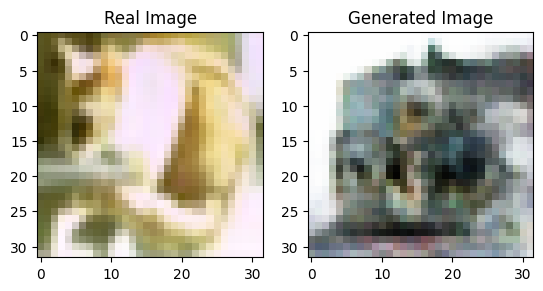

Epoch [233/300], Step [0/157], d_loss: 0.05651053786277771, g_loss: 27.196868896484375
Epoch [233/300], Step [100/157], d_loss: 0.06904523074626923, g_loss: 18.176410675048828


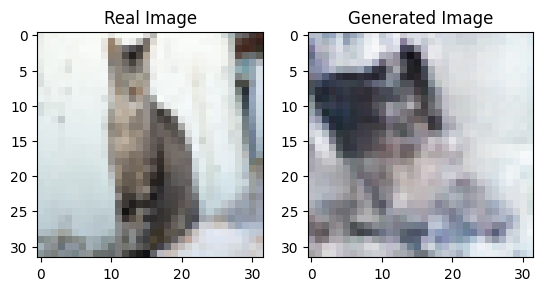

Epoch [234/300], Step [0/157], d_loss: 0.039416585117578506, g_loss: 14.791802406311035
Epoch [234/300], Step [100/157], d_loss: 0.01818116568028927, g_loss: 17.049598693847656


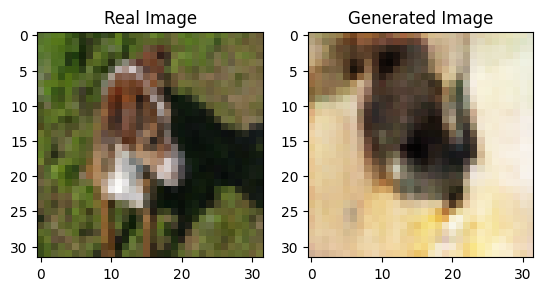

Epoch [235/300], Step [0/157], d_loss: 0.04760481044650078, g_loss: 27.801742553710938
Epoch [235/300], Step [100/157], d_loss: 0.3767920136451721, g_loss: 19.12646484375


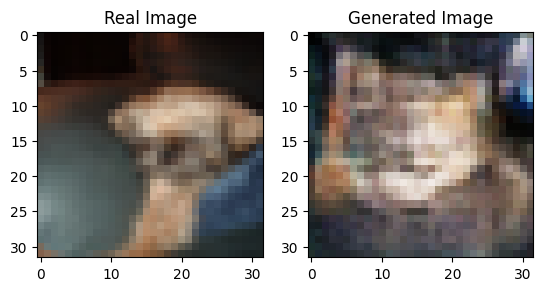

Epoch [236/300], Step [0/157], d_loss: 0.004980150610208511, g_loss: 13.404641151428223
Epoch [236/300], Step [100/157], d_loss: 0.007418070454150438, g_loss: 24.871246337890625


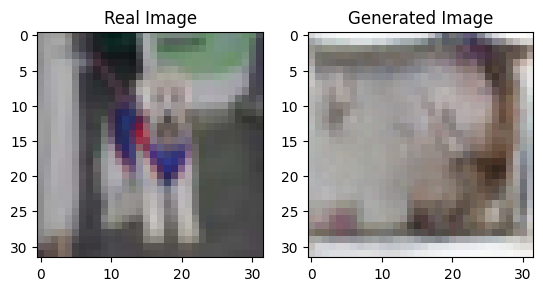

Epoch [237/300], Step [0/157], d_loss: 0.005094523075968027, g_loss: 25.081584930419922
Epoch [237/300], Step [100/157], d_loss: 0.006988869979977608, g_loss: 13.793455123901367


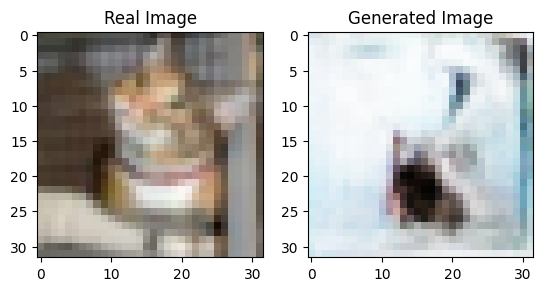

Epoch [238/300], Step [0/157], d_loss: 0.38214483857154846, g_loss: 20.55234146118164
Epoch [238/300], Step [100/157], d_loss: 0.15011896193027496, g_loss: 15.804075241088867


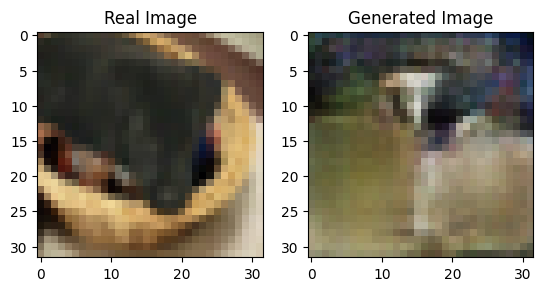

Epoch [239/300], Step [0/157], d_loss: 0.019617272540926933, g_loss: 19.46718978881836
Epoch [239/300], Step [100/157], d_loss: 0.008582469075918198, g_loss: 16.99033546447754


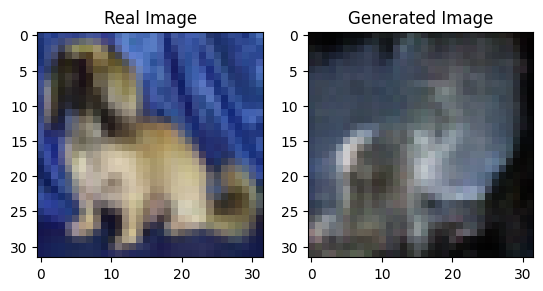

Epoch [240/300], Step [0/157], d_loss: 0.06271854788064957, g_loss: 29.405101776123047
Epoch [240/300], Step [100/157], d_loss: 0.015306567773222923, g_loss: 18.215328216552734


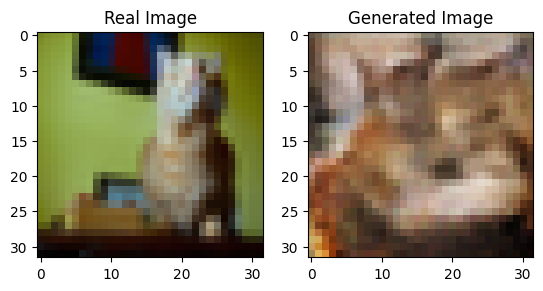

Epoch [241/300], Step [0/157], d_loss: 0.009904114529490471, g_loss: 31.26430320739746
Epoch [241/300], Step [100/157], d_loss: 0.007257807534188032, g_loss: 20.133872985839844


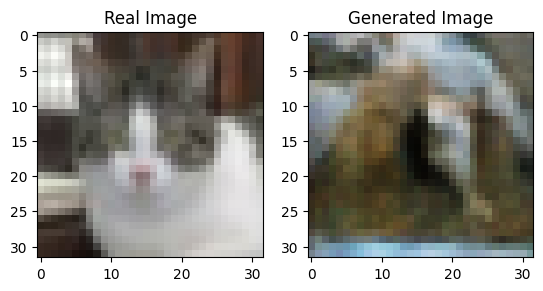

Epoch [242/300], Step [0/157], d_loss: 0.013312219642102718, g_loss: 27.58449363708496
Epoch [242/300], Step [100/157], d_loss: 0.028680404648184776, g_loss: 19.718664169311523


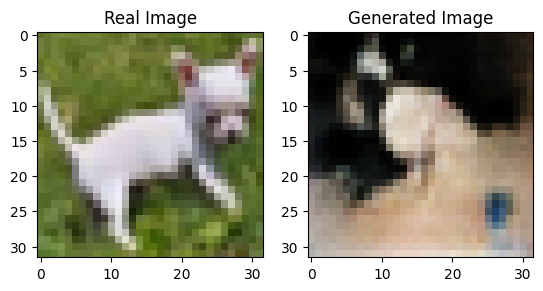

Epoch [243/300], Step [0/157], d_loss: 0.002732768189162016, g_loss: 26.169105529785156
Epoch [243/300], Step [100/157], d_loss: 0.0007527227862738073, g_loss: 40.749351501464844


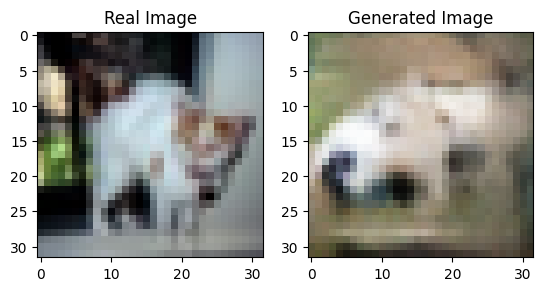

Epoch [244/300], Step [0/157], d_loss: 0.001259322976693511, g_loss: 30.57674789428711
Epoch [244/300], Step [100/157], d_loss: 0.001709031406790018, g_loss: 23.524463653564453


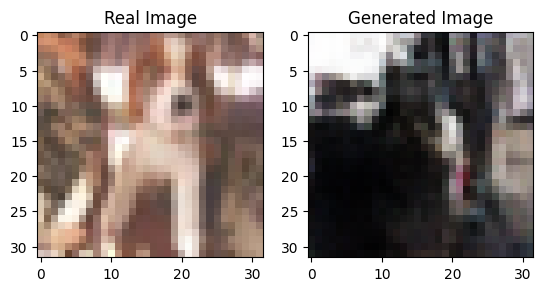

Epoch [245/300], Step [0/157], d_loss: 0.01815725490450859, g_loss: 22.046829223632812
Epoch [245/300], Step [100/157], d_loss: 0.007506443187594414, g_loss: 11.451713562011719


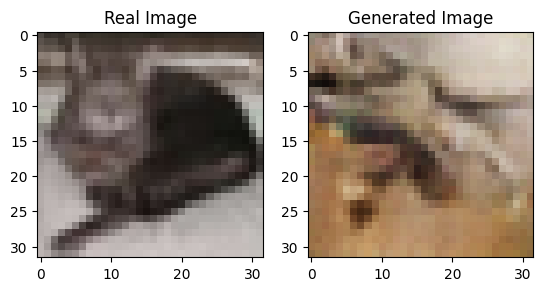

Epoch [246/300], Step [0/157], d_loss: 0.0059091574512422085, g_loss: 31.315597534179688
Epoch [246/300], Step [100/157], d_loss: 0.008459020406007767, g_loss: 17.29891586303711


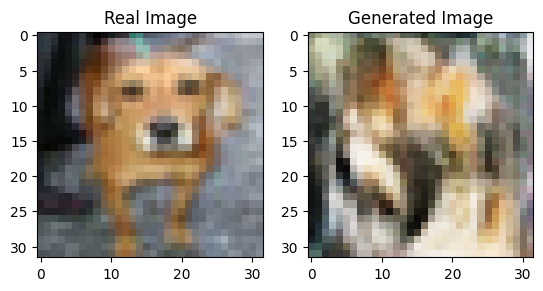

Epoch [247/300], Step [0/157], d_loss: 0.1547081023454666, g_loss: 18.018136978149414
Epoch [247/300], Step [100/157], d_loss: 0.018108950927853584, g_loss: 26.14513397216797


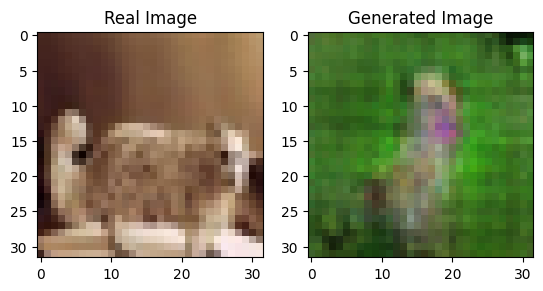

Epoch [248/300], Step [0/157], d_loss: 0.05330640450119972, g_loss: 33.117652893066406
Epoch [248/300], Step [100/157], d_loss: 0.1244020015001297, g_loss: 16.200008392333984


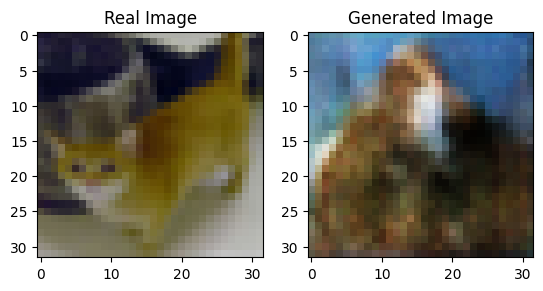

Epoch [249/300], Step [0/157], d_loss: 0.6738672852516174, g_loss: 13.756841659545898
Epoch [249/300], Step [100/157], d_loss: 0.01089659333229065, g_loss: 26.390419006347656


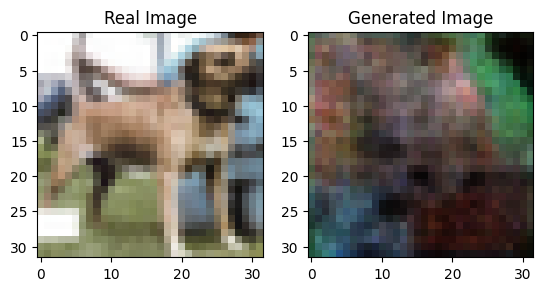

Epoch [250/300], Step [0/157], d_loss: 0.02313971146941185, g_loss: 20.779613494873047
Epoch [250/300], Step [100/157], d_loss: 0.007777920458465815, g_loss: 30.555294036865234


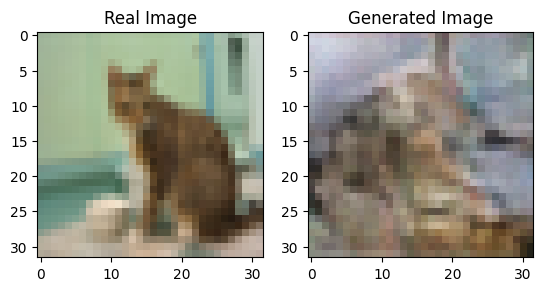

Epoch [251/300], Step [0/157], d_loss: 0.00408031465485692, g_loss: 16.98332405090332
Epoch [251/300], Step [100/157], d_loss: 0.2912636697292328, g_loss: 34.08195495605469


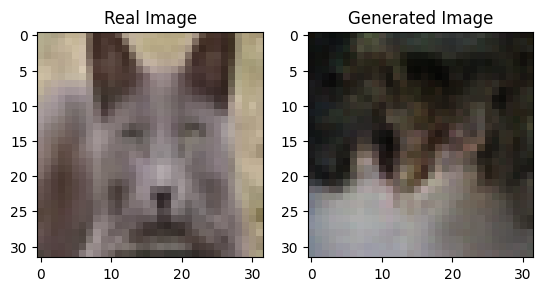

Epoch [252/300], Step [0/157], d_loss: 0.2511966824531555, g_loss: 12.715538024902344
Epoch [252/300], Step [100/157], d_loss: 0.013704823330044746, g_loss: 18.85873031616211


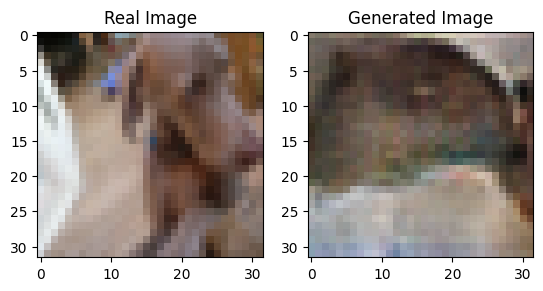

Epoch [253/300], Step [0/157], d_loss: 0.3377129137516022, g_loss: 16.735424041748047
Epoch [253/300], Step [100/157], d_loss: 0.005169618409126997, g_loss: 29.47749137878418


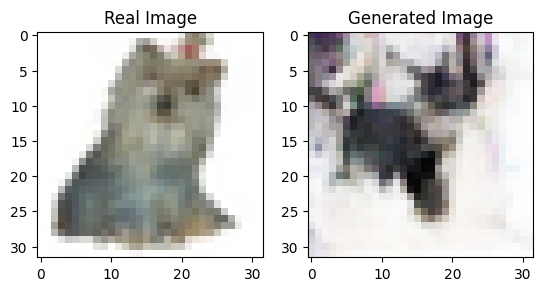

Epoch [254/300], Step [0/157], d_loss: 0.0028140523936599493, g_loss: 34.524024963378906
Epoch [254/300], Step [100/157], d_loss: 0.03098270669579506, g_loss: 11.938864707946777


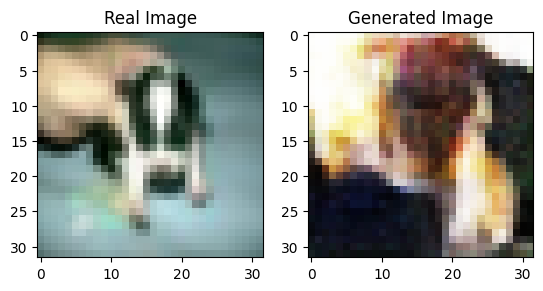

Epoch [255/300], Step [0/157], d_loss: 0.005675314925611019, g_loss: 21.072053909301758
Epoch [255/300], Step [100/157], d_loss: 0.00778373284265399, g_loss: 15.394431114196777


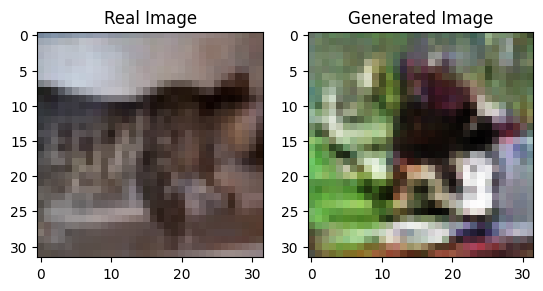

Epoch [256/300], Step [0/157], d_loss: 0.004276623018085957, g_loss: 29.01792335510254
Epoch [256/300], Step [100/157], d_loss: 0.009102891199290752, g_loss: 18.875396728515625


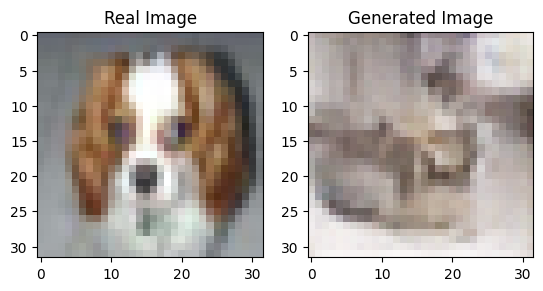

Epoch [257/300], Step [0/157], d_loss: 0.004591966979205608, g_loss: 13.187899589538574
Epoch [257/300], Step [100/157], d_loss: 0.005432597827166319, g_loss: 20.700111389160156


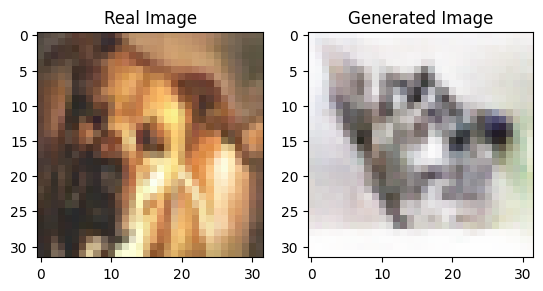

Epoch [258/300], Step [0/157], d_loss: 0.009765513241291046, g_loss: 17.65304946899414
Epoch [258/300], Step [100/157], d_loss: 0.003846710314974189, g_loss: 16.002607345581055


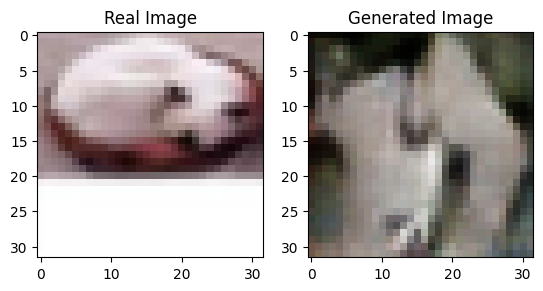

Epoch [259/300], Step [0/157], d_loss: 0.004061797168105841, g_loss: 18.41033935546875
Epoch [259/300], Step [100/157], d_loss: 0.00420854426920414, g_loss: 16.840160369873047


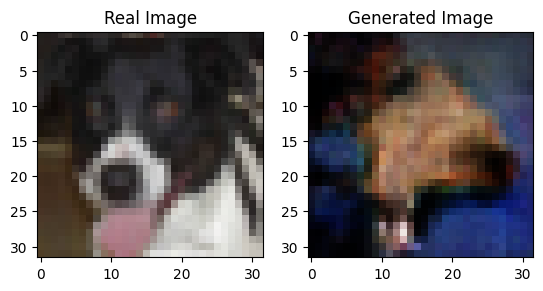

Epoch [260/300], Step [0/157], d_loss: 0.002337865298613906, g_loss: 14.296539306640625
Epoch [260/300], Step [100/157], d_loss: 0.0015875666867941618, g_loss: 22.11026382446289


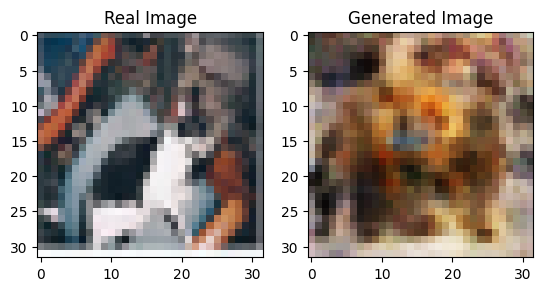

Epoch [261/300], Step [0/157], d_loss: 0.0013882853090763092, g_loss: 25.281326293945312
Epoch [261/300], Step [100/157], d_loss: 0.0006777490489184856, g_loss: 29.388132095336914


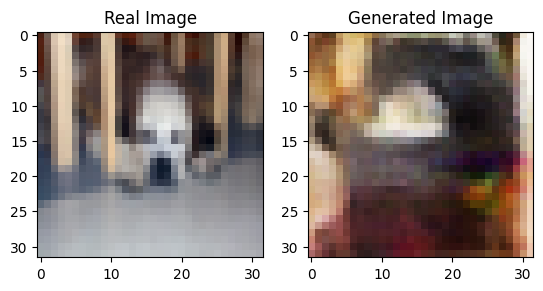

Epoch [262/300], Step [0/157], d_loss: 0.001682161702774465, g_loss: 21.199295043945312
Epoch [262/300], Step [100/157], d_loss: 0.00199548969976604, g_loss: 19.807113647460938


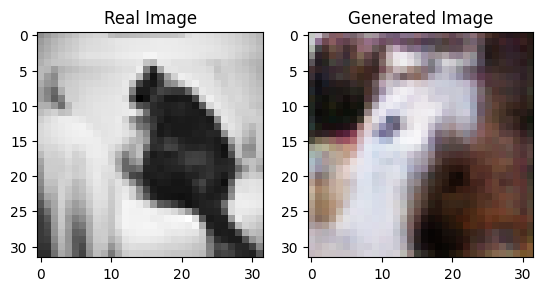

Epoch [263/300], Step [0/157], d_loss: 0.0012056719278916717, g_loss: 21.059017181396484
Epoch [263/300], Step [100/157], d_loss: 0.004108546767383814, g_loss: 24.589557647705078


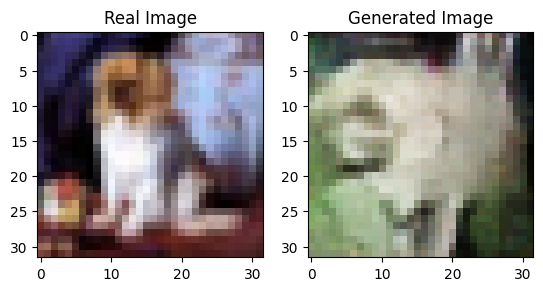

Epoch [264/300], Step [0/157], d_loss: 0.4225662350654602, g_loss: 15.30869197845459
Epoch [264/300], Step [100/157], d_loss: 0.012576853856444359, g_loss: 14.392662048339844


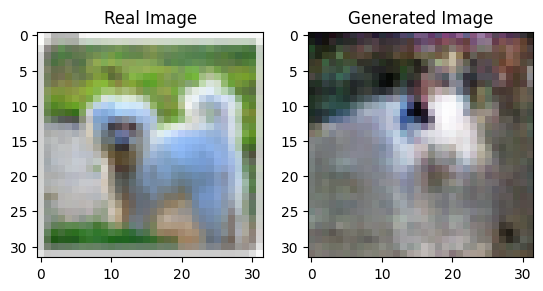

Epoch [265/300], Step [0/157], d_loss: 0.012668407522141933, g_loss: 13.571609497070312
Epoch [265/300], Step [100/157], d_loss: 0.0077479067258536816, g_loss: 11.519929885864258


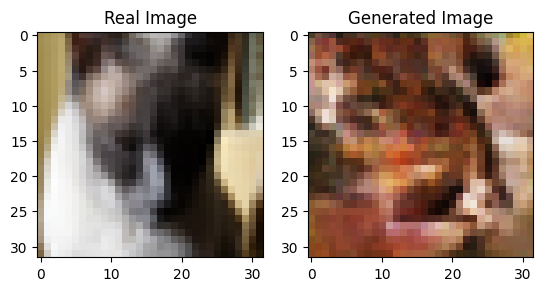

Epoch [266/300], Step [0/157], d_loss: 0.0026650521904230118, g_loss: 12.917110443115234
Epoch [266/300], Step [100/157], d_loss: 0.020062312483787537, g_loss: 24.465316772460938


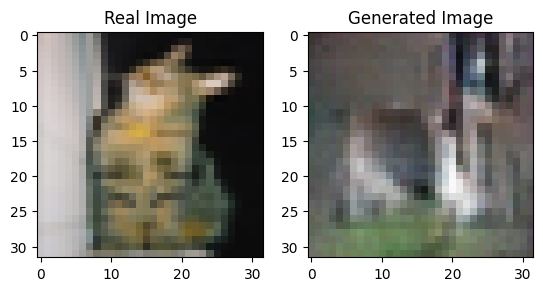

Epoch [267/300], Step [0/157], d_loss: 0.1348429173231125, g_loss: 17.158199310302734
Epoch [267/300], Step [100/157], d_loss: 0.007207631599158049, g_loss: 19.0163631439209


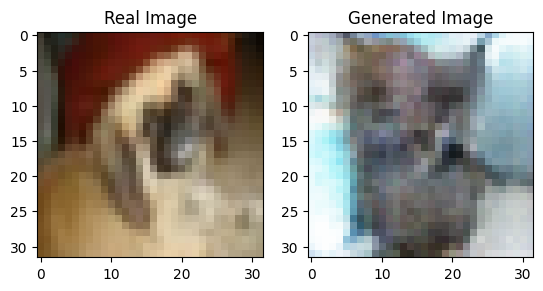

Epoch [268/300], Step [0/157], d_loss: 0.008446873165667057, g_loss: 12.487853050231934
Epoch [268/300], Step [100/157], d_loss: 0.004036715254187584, g_loss: 37.638389587402344


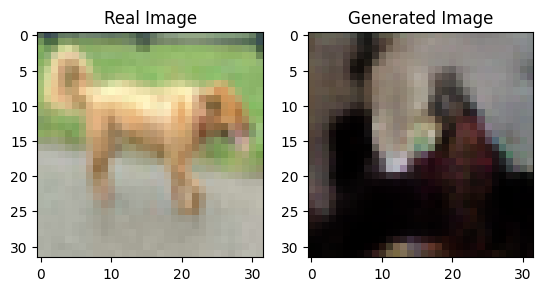

Epoch [269/300], Step [0/157], d_loss: 0.4348675608634949, g_loss: 28.347126007080078
Epoch [269/300], Step [100/157], d_loss: 0.05579793453216553, g_loss: 23.579185485839844


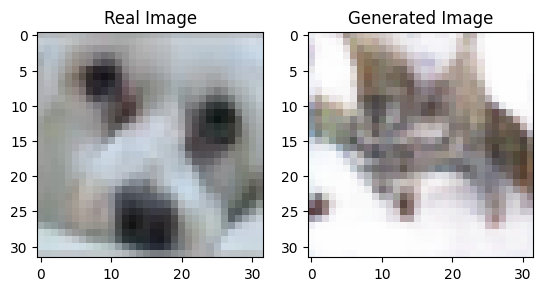

Epoch [270/300], Step [0/157], d_loss: 0.012006082572042942, g_loss: 34.47456359863281
Epoch [270/300], Step [100/157], d_loss: 0.0059194378554821014, g_loss: 13.906808853149414


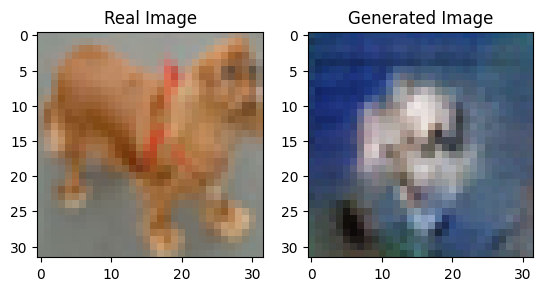

Epoch [271/300], Step [0/157], d_loss: 0.009824158623814583, g_loss: 15.848913192749023
Epoch [271/300], Step [100/157], d_loss: 0.003423364832997322, g_loss: 16.378376007080078


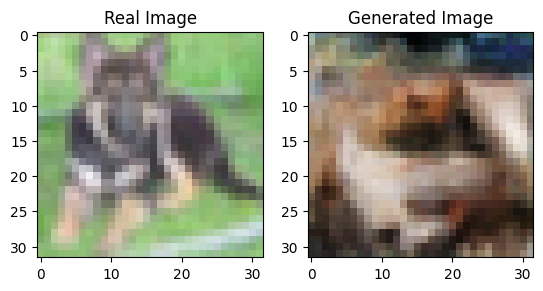

Epoch [272/300], Step [0/157], d_loss: 0.004224398173391819, g_loss: 21.559377670288086
Epoch [272/300], Step [100/157], d_loss: 0.05607261136174202, g_loss: 15.816831588745117


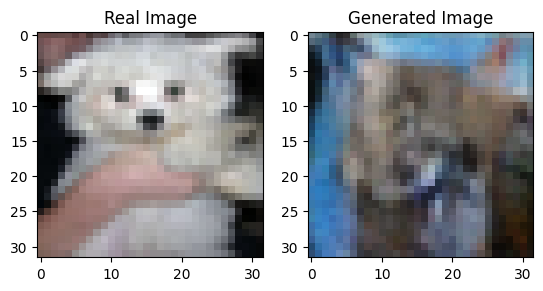

Epoch [273/300], Step [0/157], d_loss: 0.03758111968636513, g_loss: 28.376911163330078
Epoch [273/300], Step [100/157], d_loss: 0.007096748799085617, g_loss: 22.968008041381836


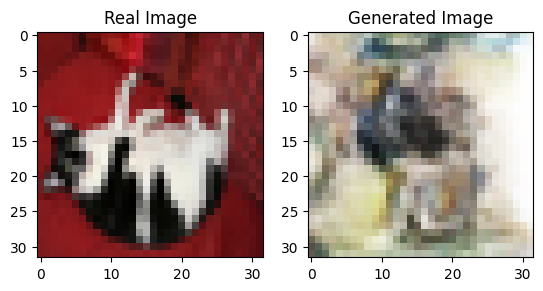

Epoch [274/300], Step [0/157], d_loss: 0.001369115780107677, g_loss: 22.713891983032227
Epoch [274/300], Step [100/157], d_loss: 0.0072635761462152, g_loss: 23.066253662109375


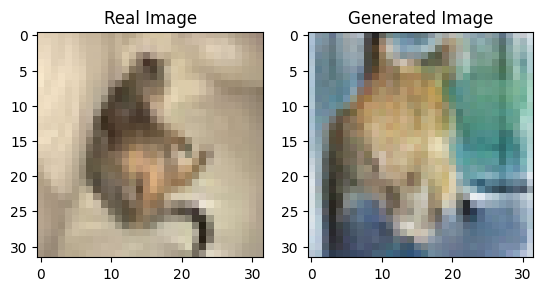

Epoch [275/300], Step [0/157], d_loss: 0.033836156129837036, g_loss: 27.367347717285156
Epoch [275/300], Step [100/157], d_loss: 0.013326460495591164, g_loss: 19.33860206604004


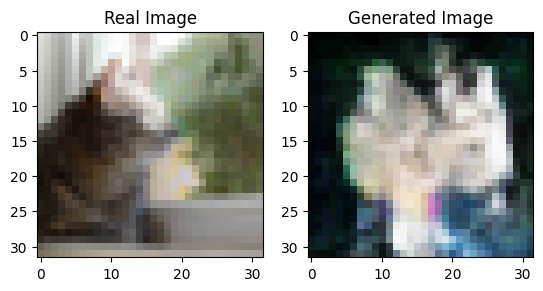

Epoch [276/300], Step [0/157], d_loss: 0.13569742441177368, g_loss: 36.731101989746094
Epoch [276/300], Step [100/157], d_loss: 0.02285342663526535, g_loss: 22.837310791015625


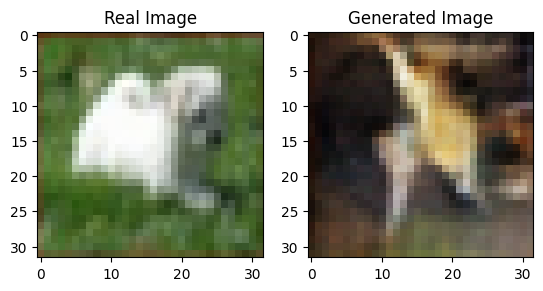

Epoch [277/300], Step [0/157], d_loss: 0.01893622800707817, g_loss: 23.190046310424805
Epoch [277/300], Step [100/157], d_loss: 0.00735880620777607, g_loss: 12.494186401367188


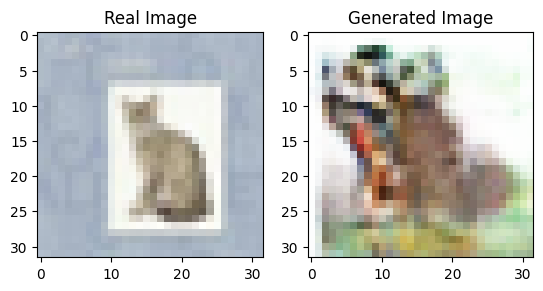

Epoch [278/300], Step [0/157], d_loss: 0.0037784669548273087, g_loss: 22.252695083618164
Epoch [278/300], Step [100/157], d_loss: 0.2277873456478119, g_loss: 23.872432708740234


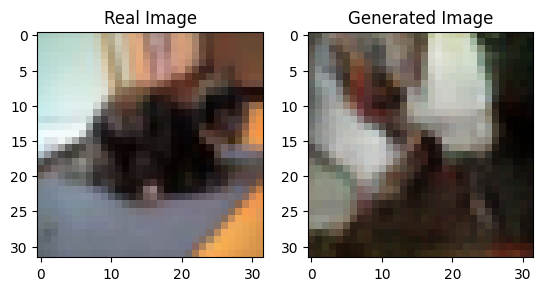

Epoch [279/300], Step [0/157], d_loss: 0.0015561145264655352, g_loss: 33.36650466918945
Epoch [279/300], Step [100/157], d_loss: 0.0027385533321648836, g_loss: 28.23282241821289


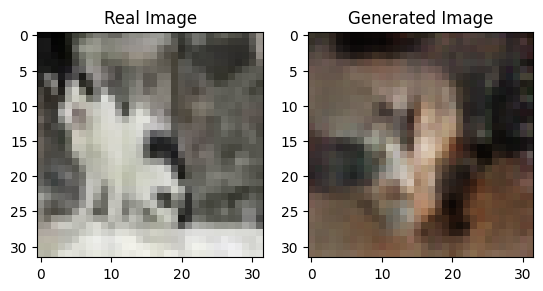

Epoch [280/300], Step [0/157], d_loss: 0.009319270960986614, g_loss: 27.51102066040039
Epoch [280/300], Step [100/157], d_loss: 0.0056708622723817825, g_loss: 26.251113891601562


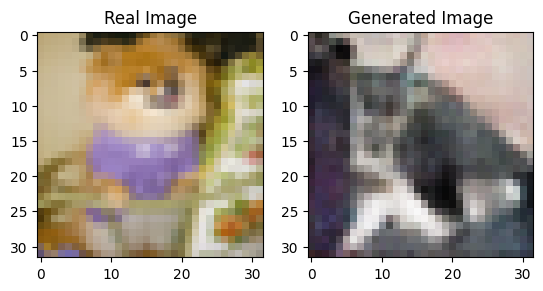

Epoch [281/300], Step [0/157], d_loss: 0.0011477547232061625, g_loss: 38.282936096191406
Epoch [281/300], Step [100/157], d_loss: 0.001299616415053606, g_loss: 19.607189178466797


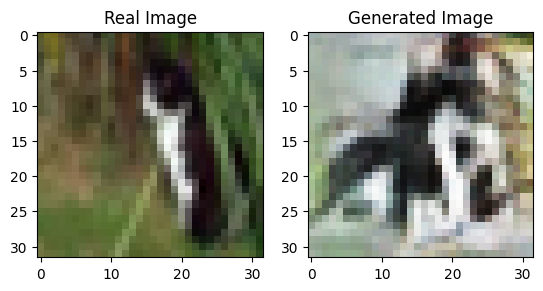

Epoch [282/300], Step [0/157], d_loss: 0.0007434459403157234, g_loss: 15.873700141906738
Epoch [282/300], Step [100/157], d_loss: 0.0010276873363181949, g_loss: 23.27004623413086


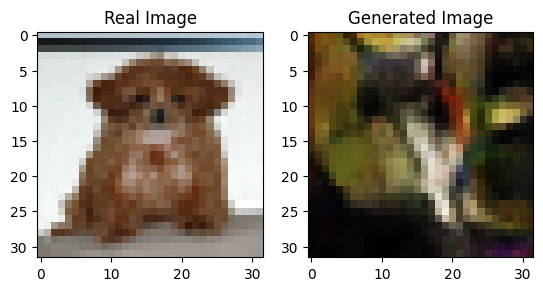

Epoch [283/300], Step [0/157], d_loss: 0.08311402797698975, g_loss: 19.774547576904297
Epoch [283/300], Step [100/157], d_loss: 0.0025135143660008907, g_loss: 26.050827026367188


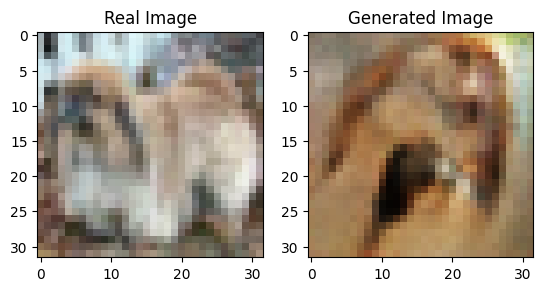

Epoch [284/300], Step [0/157], d_loss: 0.008427973836660385, g_loss: 36.14849853515625
Epoch [284/300], Step [100/157], d_loss: 0.01783229038119316, g_loss: 32.838829040527344


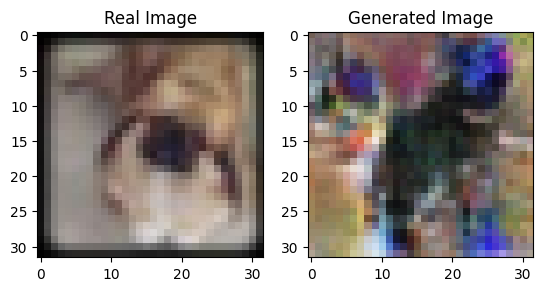

Epoch [285/300], Step [0/157], d_loss: 0.0020378672052174807, g_loss: 16.64928436279297
Epoch [285/300], Step [100/157], d_loss: 0.0005253400304354727, g_loss: 29.93812370300293


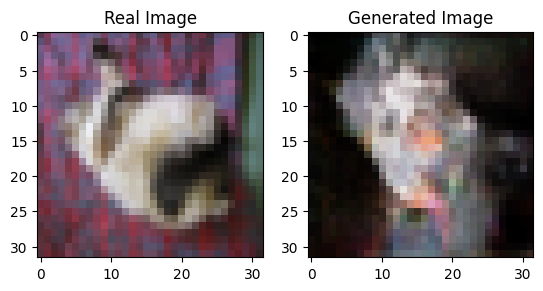

Epoch [286/300], Step [0/157], d_loss: 0.00133557862136513, g_loss: 22.242839813232422
Epoch [286/300], Step [100/157], d_loss: 0.0015727945137768984, g_loss: 21.98109245300293


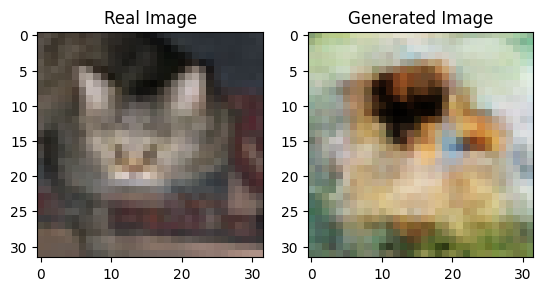

Epoch [287/300], Step [0/157], d_loss: 2.301032304763794, g_loss: 15.441157341003418
Epoch [287/300], Step [100/157], d_loss: 0.04723016172647476, g_loss: 14.13955307006836


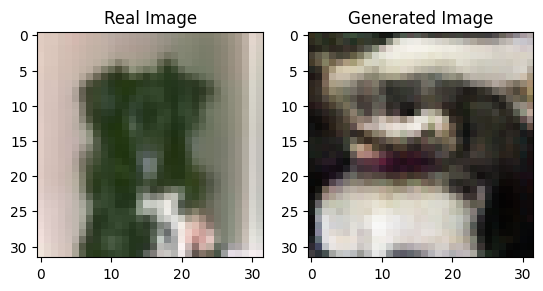

Epoch [288/300], Step [0/157], d_loss: 0.261238157749176, g_loss: 26.117034912109375
Epoch [288/300], Step [100/157], d_loss: 1.0015101432800293, g_loss: 40.910400390625


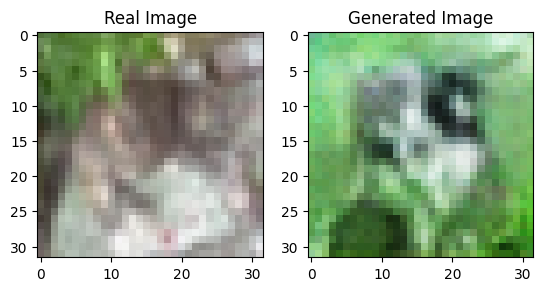

Epoch [289/300], Step [0/157], d_loss: 0.027046097442507744, g_loss: 29.370296478271484
Epoch [289/300], Step [100/157], d_loss: 0.017057951539754868, g_loss: 14.716300010681152


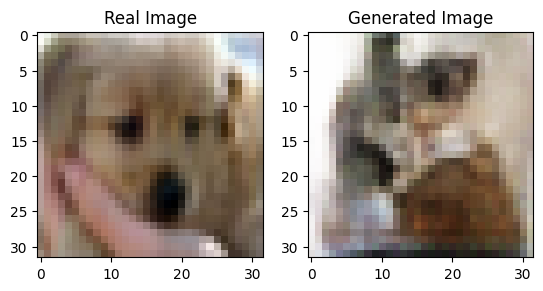

Epoch [290/300], Step [0/157], d_loss: 0.21617954969406128, g_loss: 35.13618850708008
Epoch [290/300], Step [100/157], d_loss: 0.005013784859329462, g_loss: 23.70181655883789


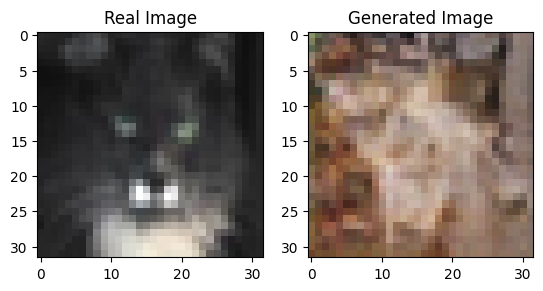

Epoch [291/300], Step [0/157], d_loss: 0.10364966094493866, g_loss: 25.606544494628906
Epoch [291/300], Step [100/157], d_loss: 0.012820074334740639, g_loss: 15.87321662902832


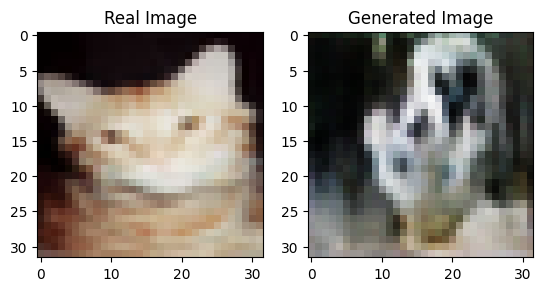

Epoch [292/300], Step [0/157], d_loss: 0.007491186261177063, g_loss: 30.26898193359375
Epoch [292/300], Step [100/157], d_loss: 0.03297564759850502, g_loss: 15.588991165161133


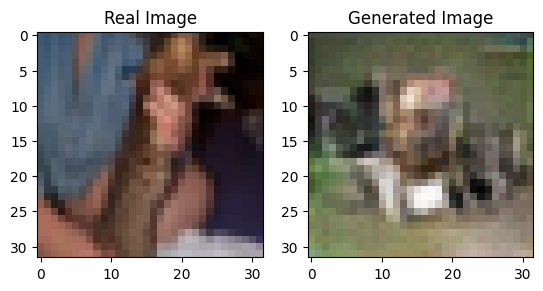

Epoch [293/300], Step [0/157], d_loss: 0.015633979812264442, g_loss: 21.285507202148438
Epoch [293/300], Step [100/157], d_loss: 0.0017893955809995532, g_loss: 21.37796401977539


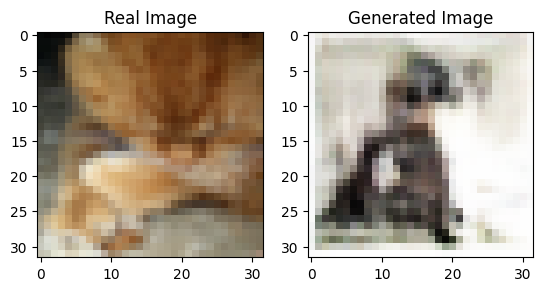

Epoch [294/300], Step [0/157], d_loss: 0.006127202417701483, g_loss: 20.985742568969727
Epoch [294/300], Step [100/157], d_loss: 0.0016454905271530151, g_loss: 20.61107635498047


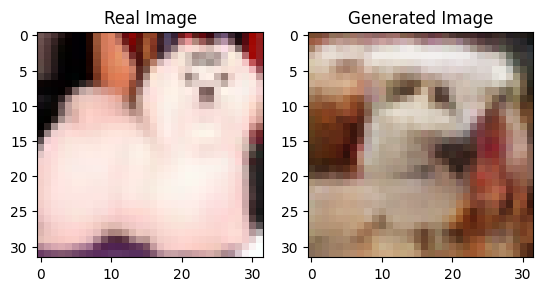

Epoch [295/300], Step [0/157], d_loss: 0.00522404070943594, g_loss: 29.920387268066406
Epoch [295/300], Step [100/157], d_loss: 0.09830358624458313, g_loss: 13.997713088989258


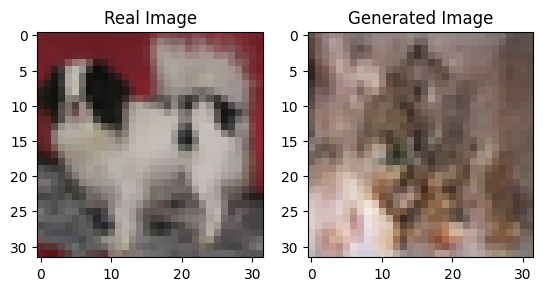

Epoch [296/300], Step [0/157], d_loss: 0.013932356610894203, g_loss: 15.509454727172852
Epoch [296/300], Step [100/157], d_loss: 0.015371238812804222, g_loss: 19.021303176879883


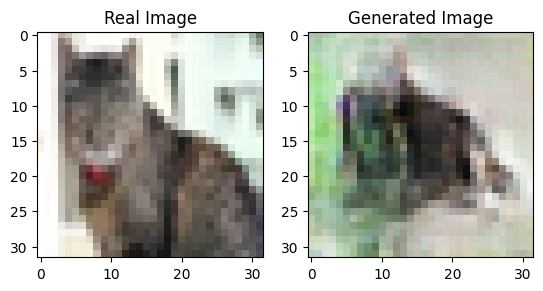

Epoch [297/300], Step [0/157], d_loss: 0.01080032903701067, g_loss: 33.399169921875
Epoch [297/300], Step [100/157], d_loss: 0.0010494025191292167, g_loss: 19.73019790649414


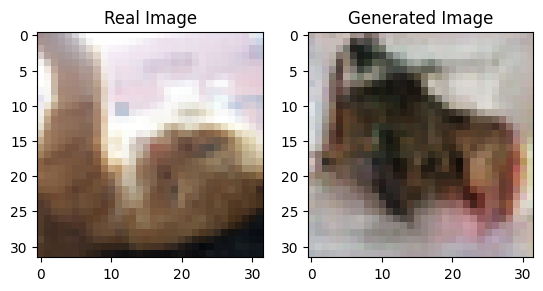

Epoch [298/300], Step [0/157], d_loss: 0.039546288549900055, g_loss: 22.16653823852539
Epoch [298/300], Step [100/157], d_loss: 0.00160321150906384, g_loss: 19.251832962036133


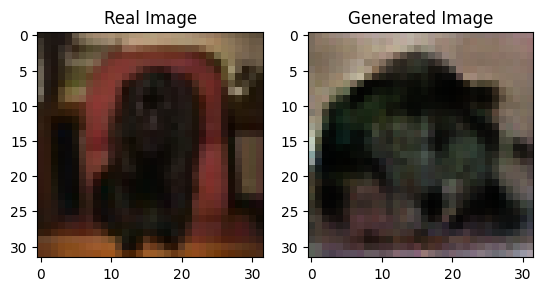

Epoch [299/300], Step [0/157], d_loss: 0.004521467722952366, g_loss: 20.318946838378906
Epoch [299/300], Step [100/157], d_loss: 0.0028601367957890034, g_loss: 18.430810928344727


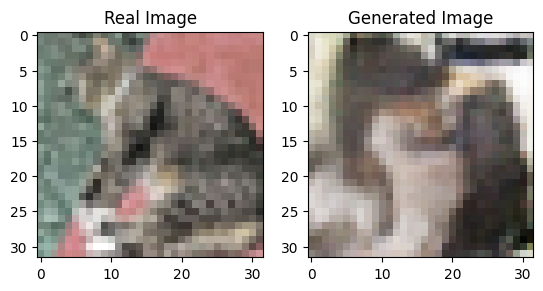

In [21]:
num_epochs = 300
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.cuda()

        # Generate random noise and generate fake images
        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_images = generator(z)

        # Train discriminator
        optimizer_D.zero_grad()

        # Real image similarity score
        real_sim_score = discriminator(real_images, real_images)
        # Fake image similarity score
        fake_sim_score = discriminator(real_images, fake_images.detach())

        # Compute discriminator loss
        d_loss = discriminator_loss(real_sim_score, fake_sim_score)
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()

        # Generator tries to minimize similarity score between real and generated images
        g_loss = generator_loss(discriminator(real_images, fake_images))
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    # Display real and generated images after each epoch
    real_image_sample = real_images[0].cpu().detach().numpy().transpose(1, 2, 0)
    fake_image_sample = fake_images[0].cpu().detach().numpy().transpose(1, 2, 0)

    real_image_sample = (real_image_sample + 1) / 2  # Denormalize
    fake_image_sample = (fake_image_sample + 1) / 2

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(real_image_sample)
    axs[0].set_title("Real Image")
    axs[1].imshow(fake_image_sample)
    axs[1].set_title("Generated Image")
    plt.show()


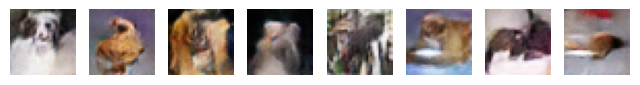

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and visualize images from the trained generator
def generate_images(generator, num_images=8, image_size=(32, 32), device='cuda'):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random noise
    latent_dim = 100  # Adjust this to match the latent dimension used in your generator
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Reshape noise to (batch_size, latent_dim, 1, 1)

    # Generate fake images
    with torch.no_grad():  # Disable gradient calculation
        fake_images = generator(noise).cpu()  # Move the generated images to the CPU

    # Rescale the images from [-1, 1] to [0, 1] for visualization
    fake_images = (fake_images + 1) / 2  # If your images are in range [-1, 1], scale them to [0, 1]

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 2))
    for i, img in enumerate(fake_images):
        img_np = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(img_np)
        axes[i].axis('off')

    plt.show()

# Example usage:
# Assuming 'generator' is your trained Generator model
generate_images(generator, num_images=8, image_size=(32, 32))